# Test YOLO Symbols Model

This notebook tests the YOLO model `models/YOLO_SYMBOLS.pt` on cell images (cells 1..24) focusing on `cell5` and `cell6` per row. Use the sections below to install/check dependencies, load the model, run single and batch inference, save annotated outputs, collect simple metrics, and run basic unit tests.

Example image path: `Module1GradesSheet/data/cells/17/row2_cell5.jpg`

## 1) Environment Setup & Dependencies

Install (if needed) and import required packages, check CUDA availability, and set the device.

Run this cell to ensure the environment is ready for inference.

In [3]:
# Install and import dependencies
import sys
import os
import time
import glob
import re
import json
from pathlib import Path

# Install packages if missing (uncomment the pip install lines if needed)
try:
    import torch
except Exception:
    print('torch missing — run: pip install torch')
try:
    from ultralytics import YOLO
except Exception:
    print('ultralytics not installed — run: pip install ultralytics')

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# Optional libraries
try:
    import ipywidgets as widgets
    from IPython.display import display
except Exception:
    print('ipywidgets/IPython missing — install ipywidgets for interactive widgets')

# Check torch/cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
print(f'Torch version: {torch.__version__}')


Device: cpu
Torch version: 2.9.1+cpu


## 2) Define Paths, Parameters & Helpers

Set the model and data location, define the cell range (1..24), columns to test (5 and 6), and helper functions to collect images and parse filenames.

In [4]:
# Paths and parameters
MODEL_PATH = r"C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\models\YOLO_SYMBOLS.pt"
DATA_ROOT = r"C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells"
OUTPUT_ROOT = os.path.join(os.getcwd(), "Module1GradesSheet", "notebooks", "outputs", "symbols_test")
os.makedirs(OUTPUT_ROOT, exist_ok=True)

CELL_RANGE = list(range(1, 25))  # 1..24
COLUMNS = [5, 6]

import glob
import re

def collect_images(data_root, cell_range=CELL_RANGE, columns=COLUMNS):
    images = []
    for cell_idx in cell_range:
        folder = os.path.join(data_root, str(cell_idx))
        if not os.path.isdir(folder):
            # print(f"Missing folder: {folder}")
            continue
        for col in columns:
            pattern = os.path.join(folder, f"*row*_cell{col}.*")
            found = glob.glob(pattern)
            for p in found:
                images.append(p)
    return sorted(images)


def parse_row_cell_from_filename(fp):
    b = os.path.basename(fp)
    m = re.search(r'row(\d+).*_cell(\d+)', b)
    if not m:
        return None, None
    return int(m.group(1)), int(m.group(2))

# Quick check
imgs = collect_images(DATA_ROOT, cell_range=[17], columns=[5])
print('Example images found (cell 17 col 5):', len(imgs))
if imgs:
    print(imgs[:3])


Example images found (cell 17 col 5): 17
['C:\\Users\\youse\\Desktop\\University\\Image\\GradesAutoFiller\\Module1GradesSheet\\data\\cells\\17\\row10_cell5.jpg', 'C:\\Users\\youse\\Desktop\\University\\Image\\GradesAutoFiller\\Module1GradesSheet\\data\\cells\\17\\row11_cell5.jpg', 'C:\\Users\\youse\\Desktop\\University\\Image\\GradesAutoFiller\\Module1GradesSheet\\data\\cells\\17\\row12_cell5.jpg']


## 3) Load YOLO .pt Model

Load the YOLO model (ultralytics YOLO if available). The code below attempts to load and performs a warm-up inference on a sample image (if found).

In [5]:
# Load model
model = None
try:
    from ultralytics import YOLO
    model = YOLO(MODEL_PATH)
    print('Loaded model:', MODEL_PATH)
except Exception as e:
    print('Failed to load with ultralytics.YOLO:', e)
    # Try torch.load as fallback
    try:
        import torch
        _ = torch.load(MODEL_PATH, map_location='cpu')
        print('torch.load succeeded — model file seems valid.')
    except Exception as e2:
        print('torch.load also failed:', e2)

# Warm-up inference (if possible)
sample_images = collect_images(DATA_ROOT, cell_range=[17], columns=[5,6])
if model is not None and sample_images:
    try:
        print('Running warm-up inference on:', sample_images[0])
        _ = model(sample_images[0], imgsz=640, conf=0.25)
        print('Warm-up inference completed.')
    except Exception as e:
        print('Warm-up failed:', e)


Loaded model: C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\models\YOLO_SYMBOLS.pt
Running warm-up inference on: C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row10_cell5.jpg

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row10_cell5.jpg: 288x640 1 check, 62.6ms
Speed: 28.5ms preprocess, 62.6ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)
Warm-up inference completed.


## 4) Load & Visualize Sample Images

Read an example image (e.g., `.../cells/17/row2_cell5.jpg`) and display it. Include a quick helper to show images using matplotlib.

Showing example: C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row10_cell5.jpg


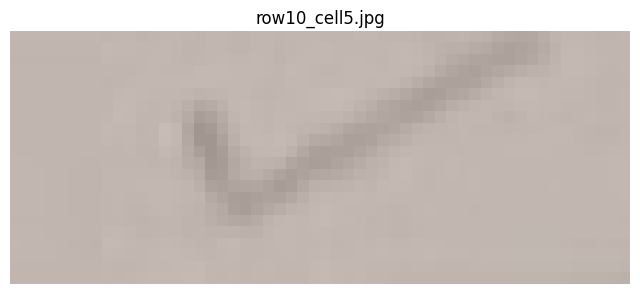

In [6]:
def imshow_cv2_rgb(img_or_path, figsize=(8,8), title=None):
    if isinstance(img_or_path, str):
        img = cv2.imread(img_or_path)
    else:
        img = img_or_path
    if img is None:
        print('Failed to read image:', img_or_path)
        return
    # cv2 reads BGR
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Display an example image if present
example = None
sample_imgs = collect_images(DATA_ROOT, cell_range=[17], columns=[5])
if sample_imgs:
    example = sample_imgs[0]
    print('Showing example:', example)
    imshow_cv2_rgb(example, title=os.path.basename(example))
else:
    print('No example images found for cell 17 col 5')


## 5) Single-Image Inference (example: cell 17 row2_cell5.jpg)

Run inference on a single image, print detections, and show annotated image.


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row10_cell5.jpg: 288x640 1 check, 46.3ms
Speed: 1.4ms preprocess, 46.3ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=4, conf=0.785, xyxy=[10.499419212341309, 0.0, 54.0, 21.328815460205078]


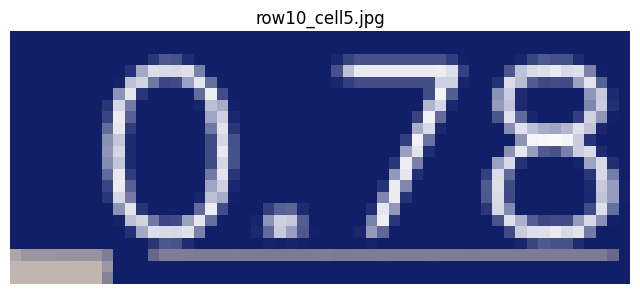

In [7]:
def run_and_display(model, img_path, conf=0.25, imgsz=640, show=True):
    """Run model on a single image, print detection summaries and display annotated image."""
    if model is None:
        print('Model is not loaded')
        return None
    try:
        res = model(img_path, imgsz=imgsz, conf=conf)
    except Exception as e:
        print('Inference failed:', e)
        return None

    r = res[0]
    # Print detections
    boxes = getattr(r, 'boxes', None)
    if boxes is not None and len(boxes) > 0:
        n = len(boxes)
        print(f"Detections: {n}")
        for i in range(n):
            try:
                cls = int(boxes.cls[i].item())
                score = float(boxes.conf[i].item())
                xyxy = [float(x) for x in boxes.xyxy[i].tolist()]
                print(f"  class={cls}, conf={score:.3f}, xyxy={xyxy}")
            except Exception:
                print('  <box parse error>')
    else:
        print('No detections')

    # Annotated image
    annotated = r.plot()
    if isinstance(annotated, np.ndarray):
        # if BGR, convert to RGB for matplotlib (ultralytics often returns BGR)
        im_show = annotated[..., ::-1]
        if show:
            plt.figure(figsize=(8,8))
            plt.imshow(im_show)
            plt.axis('off')
            plt.title(os.path.basename(img_path))
            plt.show()
    return r

# Run example single-image inference
if example:
    _ = run_and_display(model, example, conf=0.25)
else:
    print('No example available for single-image inference')

## 6) Batch Inference for Cells 1–24 (cells 5 & 6 of each row)

Run inference across all matching images, collect detection metadata (image_path, row, cell, class_id, score, bbox), and optionally save annotated images.

In [8]:
import pandas as pd
from tqdm import tqdm

all_images = collect_images(DATA_ROOT, cell_range=CELL_RANGE, columns=COLUMNS)
print(f'Found {len(all_images)} images matching cell columns {COLUMNS} across cells 1..24')

def batch_infer_and_save(model, images, out_root=OUTPUT_ROOT, conf=0.25, imgsz=640, save_csv=True):
    rows = []
    for img_path in tqdm(images):
        r = run_and_display(model, img_path, conf=conf, imgsz=imgsz, show=False)
        if r is None:
            continue
        boxes = getattr(r, 'boxes', None)
        row_num, cell_num = parse_row_cell_from_filename(img_path)
        # Save annotated image
        annotated = r.plot()
        out_subdir = os.path.join(out_root, os.path.relpath(os.path.dirname(img_path), DATA_ROOT))
        os.makedirs(out_subdir, exist_ok=True)
        out_img_path = os.path.join(out_subdir, os.path.basename(img_path))
        if isinstance(annotated, np.ndarray):
            # convert to RGB and save
            im_save = Image.fromarray(annotated[..., ::-1])
            im_save.save(out_img_path)
        # Collect metadata
        if boxes is not None and len(boxes) > 0:
            for i in range(len(boxes)):
                try:
                    cls = int(boxes.cls[i].item())
                    score = float(boxes.conf[i].item())
                    xyxy = [float(x) for x in boxes.xyxy[i].tolist()]
                    rows.append({
                        'image_path': img_path,
                        'row': row_num,
                        'cell': cell_num,
                        'class_id': cls,
                        'score': score,
                        'x1': xyxy[0], 'y1': xyxy[1], 'x2': xyxy[2], 'y2': xyxy[3]
                    })
                except Exception as e:
                    print('Box parse error:', e)
        else:
            rows.append({
                'image_path': img_path,
                'row': row_num,
                'cell': cell_num,
                'class_id': None,
                'score': None,
                'x1': None, 'y1': None, 'x2': None, 'y2': None
            })
    df = pd.DataFrame(rows)
    if save_csv:
        out_csv = os.path.join(out_root, 'detections.csv')
        df.to_csv(out_csv, index=False)
        print('Saved detections to', out_csv)
    return df

# Example run on first N images (change N as needed)
# small_df = batch_infer_and_save(model, all_images[:8], conf=0.25)



Found 692 images matching cell columns [5, 6] across cells 1..24


## 7) Annotate, Save Outputs & Write CSV/JSON Results

The previous `batch_infer_and_save` function saves annotated images and writes `detections.csv`. You can re-run with different thresholds and save locations. The cell below shows how to run the full batch and save results.

In [12]:
# Run batch on all images (uncomment to execute)
df_all = batch_infer_and_save(model, all_images, out_root=OUTPUT_ROOT, conf=0.7)
df_all.head()

print('To run the full batch, uncomment the previous lines and execute this cell. Saved outputs will be under:', OUTPUT_ROOT)


  0%|          | 0/692 [00:00<?, ?it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row10_cell5.jpg: 320x640 1 check, 147.5ms
Speed: 23.6ms preprocess, 147.5ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)


  0%|          | 1/692 [00:00<02:27,  4.69it/s]

Detections: 1
  class=4, conf=0.920, xyxy=[55.149803161621094, 0.0, 150.15428161621094, 86.81257629394531]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row10_cell6.jpg: 320x640 1 question, 123.5ms
Speed: 2.7ms preprocess, 123.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


  0%|          | 2/692 [00:00<01:56,  5.94it/s]

Detections: 1
  class=5, conf=0.891, xyxy=[76.72859191894531, 6.21995735168457, 154.1765899658203, 90.8189926147461]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row11_cell5.jpg: 320x640 1 check, 51.4ms
Speed: 2.4ms preprocess, 51.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.896, xyxy=[56.49446105957031, 0.0, 143.6953582763672, 80.57819366455078]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row11_cell6.jpg: 320x640 1 question, 40.5ms
Speed: 1.0ms preprocess, 40.5ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


  1%|          | 4/692 [00:00<01:07, 10.14it/s]

Detections: 1
  class=5, conf=0.907, xyxy=[82.49549865722656, 5.3376054763793945, 160.17137145996094, 85.63369750976562]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row12_cell5.jpg: 320x640 1 check, 44.0ms
Speed: 1.1ms preprocess, 44.0ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.908, xyxy=[68.82850646972656, 0.0, 161.8888397216797, 83.07524871826172]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row12_cell6.jpg: 320x640 1 question, 38.1ms
Speed: 0.9ms preprocess, 38.1ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.858, xyxy=[88.76309967041016, 0.0371125228703022, 157.28993225097656, 83.41232299804688]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row13_cell5.jpg: 320x640 1 check, 32.1ms
Speed: 1.1ms preprocess, 32.1m

  1%|          | 7/692 [00:00<00:47, 14.48it/s]

Detections: 1
  class=4, conf=0.877, xyxy=[70.24353790283203, 0.0, 154.903564453125, 83.19136047363281]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row13_cell6.jpg: 320x640 1 question, 39.1ms
Speed: 1.7ms preprocess, 39.1ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.857, xyxy=[78.12848663330078, 0.7314246296882629, 142.83990478515625, 85.43314361572266]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row14_cell5.jpg: 320x640 1 check, 50.0ms
Speed: 1.2ms preprocess, 50.0ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


  1%|▏         | 9/692 [00:00<00:43, 15.61it/s]

Detections: 1
  class=4, conf=0.910, xyxy=[80.86811828613281, 0.0, 163.53726196289062, 76.5109634399414]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row14_cell6.jpg: 320x640 1 question, 50.8ms
Speed: 1.7ms preprocess, 50.8ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.924, xyxy=[67.09278869628906, 0.0, 150.63873291015625, 85.52793884277344]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row15_cell5.jpg: 320x640 1 check, 43.0ms
Speed: 1.7ms preprocess, 43.0ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


  2%|▏         | 11/692 [00:00<00:42, 16.18it/s]

Detections: 1
  class=4, conf=0.878, xyxy=[68.53096771240234, 0.0, 150.41432189941406, 82.62808227539062]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row15_cell6.jpg: 320x640 1 question, 98.5ms
Speed: 1.0ms preprocess, 98.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.916, xyxy=[90.56929779052734, 4.439095497131348, 153.53237915039062, 86.26324462890625]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row16_cell5.jpg: 320x640 1 check, 28.9ms
Speed: 1.0ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)


  2%|▏         | 13/692 [00:00<00:44, 15.25it/s]

Detections: 1
  class=4, conf=0.868, xyxy=[66.6709213256836, 0.0, 151.2808837890625, 86.42684936523438]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row16_cell6.jpg: 320x640 1 question, 36.8ms
Speed: 1.1ms preprocess, 36.8ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.872, xyxy=[70.24679565429688, 6.559316158294678, 140.82521057128906, 83.72615051269531]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row17_cell5.jpg: 320x640 1 check, 31.2ms
Speed: 1.1ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.894, xyxy=[61.96175765991211, 0.0, 158.5797576904297, 82.25096130371094]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row17_cell6.jpg: 320x640 1 question, 32.6ms
Speed: 1.1ms preprocess, 32.6ms inference, 0.

  2%|▏         | 16/692 [00:01<00:37, 17.82it/s]

Detections: 1
  class=5, conf=0.865, xyxy=[82.12535858154297, 0.02761387825012207, 151.96153259277344, 79.49605560302734]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row18_cell5.jpg: 320x640 1 check, 37.0ms
Speed: 1.5ms preprocess, 37.0ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.868, xyxy=[60.259254455566406, 0.0, 139.3424835205078, 92.20803833007812]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row18_cell6.jpg: 320x640 1 question, 32.9ms
Speed: 1.5ms preprocess, 32.9ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.883, xyxy=[71.0683822631836, 0.0, 142.90557861328125, 78.24748992919922]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row1_cell5.jpg: 160x640 1 Vertical, 31.6ms
Speed: 0.7ms preprocess, 31.6ms inference,

  3%|▎         | 19/692 [00:01<00:34, 19.57it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row1_cell6.jpg: 160x640 (no detections), 40.7ms
Speed: 40.1ms preprocess, 40.7ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row2_cell5.jpg: 320x640 1 check, 44.8ms
Speed: 0.9ms preprocess, 44.8ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


  3%|▎         | 21/692 [00:01<00:38, 17.38it/s]

Detections: 1
  class=4, conf=0.878, xyxy=[58.21208953857422, 0.0, 149.80601501464844, 75.73772430419922]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row2_cell6.jpg: 320x640 1 question, 40.3ms
Speed: 2.3ms preprocess, 40.3ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.843, xyxy=[72.58610534667969, 1.000489592552185, 125.26345825195312, 83.27142333984375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row3_cell5.jpg: 320x640 1 check, 33.0ms
Speed: 3.6ms preprocess, 33.0ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.923, xyxy=[58.68013381958008, 0.0, 140.60182189941406, 73.95294189453125]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row3_cell6.jpg: 320x640 1 question, 35.4ms
Speed: 1.3ms preprocess, 35.4ms inference, 0.

  3%|▎         | 24/692 [00:01<00:35, 18.66it/s]

Detections: 1
  class=5, conf=0.871, xyxy=[79.05033111572266, 4.7554473876953125, 142.211181640625, 89.09070587158203]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row4_cell5.jpg: 320x640 1 check, 45.9ms
Speed: 1.5ms preprocess, 45.9ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.891, xyxy=[48.25204849243164, 0.14036178588867188, 129.95370483398438, 82.03961944580078]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row4_cell6.jpg: 320x640 1 question, 34.3ms
Speed: 1.1ms preprocess, 34.3ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.926, xyxy=[80.31086730957031, 5.718339920043945, 137.1947021484375, 85.61561584472656]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row5_cell5.jpg: 320x640 1 check, 87.4ms
Speed: 1.2ms preproc

  4%|▍         | 27/692 [00:01<00:38, 17.29it/s]

Detections: 1
  class=4, conf=0.914, xyxy=[59.270381927490234, 0.0, 149.761474609375, 79.35029602050781]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row5_cell6.jpg: 320x640 1 question, 38.5ms
Speed: 1.7ms preprocess, 38.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.911, xyxy=[70.47110748291016, 2.7465732097625732, 131.67796325683594, 82.8806381225586]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row6_cell5.jpg: 320x640 1 check, 34.9ms
Speed: 1.3ms preprocess, 34.9ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.872, xyxy=[60.68800735473633, 0.0, 150.8636474609375, 81.76380157470703]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row6_cell6.jpg: 320x640 1 question, 57.7ms
Speed: 1.9ms preprocess, 57.7ms inference, 0.7m

  4%|▍         | 30/692 [00:01<00:37, 17.65it/s]

Detections: 1
  class=5, conf=0.855, xyxy=[70.42840576171875, 4.904197692871094, 130.6208953857422, 85.73313903808594]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row7_cell5.jpg: 320x640 1 check, 32.9ms
Speed: 1.2ms preprocess, 32.9ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.801, xyxy=[61.7468376159668, 0.0, 152.60166931152344, 71.94679260253906]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row7_cell6.jpg: 320x640 1 question, 32.1ms
Speed: 1.1ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.865, xyxy=[82.7958984375, 3.2994964122772217, 139.1563262939453, 84.9566650390625]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row8_cell5.jpg: 320x640 1 check, 30.0ms
Speed: 1.5ms preprocess, 30.0ms inference

  5%|▍         | 33/692 [00:02<00:34, 19.34it/s]

Detections: 1
  class=4, conf=0.866, xyxy=[58.554691314697266, 0.0, 148.39332580566406, 83.8128890991211]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row8_cell6.jpg: 320x640 1 question, 41.8ms
Speed: 42.2ms preprocess, 41.8ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.890, xyxy=[84.13495635986328, 2.3267650604248047, 140.56497192382812, 81.40557098388672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row9_cell5.jpg: 320x640 1 check, 31.5ms
Speed: 1.1ms preprocess, 31.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


  5%|▌         | 35/692 [00:02<00:37, 17.74it/s]

Detections: 1
  class=4, conf=0.838, xyxy=[57.82204055786133, 0.0, 162.97312927246094, 85.73599243164062]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row9_cell6.jpg: 320x640 1 question, 39.0ms
Speed: 1.5ms preprocess, 39.0ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.900, xyxy=[64.59537506103516, 2.385468006134033, 131.43350219726562, 87.63616180419922]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row10_cell5.jpg: 320x640 4 Horizontals, 31.4ms
Speed: 1.3ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)
Detections: 4
  class=1, conf=0.914, xyxy=[89.6341552734375, 55.56232833862305, 171.500244140625, 72.22715759277344]
  class=1, conf=0.908, xyxy=[73.78886413574219, 35.267642974853516, 158.10906982421875, 54.97590255737305]
  class=1, conf=0.849, xyxy=[88.42606353759766, 72.8002014160156

  5%|▌         | 38/692 [00:02<00:34, 19.03it/s]

Detections: 1
  class=3, conf=0.787, xyxy=[49.47282028198242, 10.265477180480957, 152.96409606933594, 83.81803894042969]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row11_cell5.jpg: 320x640 4 Verticals, 77.4ms
Speed: 2.2ms preprocess, 77.4ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
Detections: 4
  class=2, conf=0.930, xyxy=[109.75965118408203, 13.18242073059082, 138.68153381347656, 77.69771575927734]
  class=2, conf=0.843, xyxy=[151.9113311767578, 7.083755016326904, 184.1719970703125, 81.80049133300781]
  class=2, conf=0.798, xyxy=[76.75071716308594, 10.21395492553711, 98.4928207397461, 83.0868911743164]
  class=2, conf=0.729, xyxy=[193.32623291015625, 2.5615427494049072, 206.0, 89.74051666259766]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row11_cell6.jpg: 320x640 1 box, 109.2ms
Speed: 2.5ms preprocess, 109.2ms inference, 0.6ms postprocess per image

  6%|▌         | 40/692 [00:02<00:42, 15.37it/s]

Detections: 1
  class=3, conf=0.879, xyxy=[54.57789611816406, 11.382589340209961, 148.30349731445312, 83.14813232421875]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row12_cell5.jpg: 320x640 2 Verticals, 37.2ms
Speed: 1.1ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)
Detections: 2
  class=2, conf=0.875, xyxy=[112.76573944091797, 6.473024368286133, 133.9583740234375, 75.95472717285156]
  class=2, conf=0.874, xyxy=[58.60850143432617, 4.674012184143066, 83.39810180664062, 74.72225952148438]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row12_cell6.jpg: 320x640 1 box, 35.4ms
Speed: 1.2ms preprocess, 35.4ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.887, xyxy=[68.57308197021484, 10.337641716003418, 161.03672790527344, 82.2441635131836]

image 1/1 C:\Users\youse\Desktop\University\Image\Gra

  6%|▌         | 43/692 [00:02<00:37, 17.27it/s]

Detections: 1
  class=2, conf=0.847, xyxy=[97.43513488769531, 8.029804229736328, 127.04293060302734, 81.32737731933594]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row13_cell6.jpg: 288x640 1 box, 40.0ms
Speed: 1.1ms preprocess, 40.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=3, conf=0.796, xyxy=[66.77259063720703, 8.863616943359375, 152.901611328125, 74.91477966308594]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row14_cell5.jpg: 320x640 1 Horizontal, 34.0ms
Speed: 1.1ms preprocess, 34.0ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=1, conf=0.846, xyxy=[69.86688232421875, 23.625131607055664, 175.91285705566406, 53.79108810424805]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row14_cell6.jpg: 288x640 1 box, 32.3ms
Speed: 1.2ms preproc

  7%|▋         | 46/692 [00:02<00:34, 18.50it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row15_cell5.jpg: 288x640 2 Horizontals, 54.4ms
Speed: 47.8ms preprocess, 54.4ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)
Detections: 2
  class=1, conf=0.928, xyxy=[48.46613693237305, 19.85449981689453, 175.04693603515625, 50.861061096191406]
  class=1, conf=0.825, xyxy=[51.813270568847656, 51.53968048095703, 181.69789123535156, 78.11424255371094]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row15_cell6.jpg: 320x640 1 box, 45.9ms
Speed: 1.4ms preprocess, 45.9ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


  7%|▋         | 48/692 [00:02<00:40, 15.84it/s]

Detections: 1
  class=3, conf=0.912, xyxy=[72.7798080444336, 8.626001358032227, 162.21669006347656, 85.45417785644531]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row16_cell5.jpg: 288x640 3 Horizontals, 47.9ms
Speed: 2.9ms preprocess, 47.9ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)
Detections: 3
  class=1, conf=0.845, xyxy=[70.1623306274414, 65.79151916503906, 188.46542358398438, 89.4096908569336]
  class=1, conf=0.835, xyxy=[58.6856689453125, 11.47513484954834, 167.999267578125, 40.094852447509766]
  class=1, conf=0.807, xyxy=[65.21859741210938, 41.87445831298828, 172.35043334960938, 63.96128845214844]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row16_cell6.jpg: 320x640 1 box, 47.0ms
Speed: 1.8ms preprocess, 47.0ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


  7%|▋         | 50/692 [00:03<00:40, 15.91it/s]

Detections: 1
  class=3, conf=0.894, xyxy=[57.959510803222656, 6.801702976226807, 153.5299835205078, 87.66223907470703]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row17_cell5.jpg: 320x640 3 Verticals, 62.6ms
Speed: 1.6ms preprocess, 62.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Detections: 3
  class=2, conf=0.923, xyxy=[113.37004089355469, 10.317936897277832, 137.1836395263672, 76.33229064941406]
  class=2, conf=0.897, xyxy=[83.13166809082031, 10.93809986114502, 105.94664001464844, 75.51651763916016]
  class=2, conf=0.891, xyxy=[151.4845428466797, 14.536603927612305, 176.92982482910156, 79.29291534423828]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row17_cell6.jpg: 288x640 1 box, 47.5ms
Speed: 1.9ms preprocess, 47.5ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


  8%|▊         | 52/692 [00:03<00:41, 15.51it/s]

Detections: 1
  class=3, conf=0.808, xyxy=[55.61771774291992, 6.667022705078125, 146.11343383789062, 87.24252319335938]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row18_cell5.jpg: 320x640 5 Verticals, 154.1ms
Speed: 1.8ms preprocess, 154.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)
Detections: 5
  class=2, conf=0.935, xyxy=[106.53915405273438, 20.802955627441406, 132.537353515625, 76.56609344482422]
  class=2, conf=0.921, xyxy=[30.730634689331055, 12.152230262756348, 59.033023834228516, 77.20326232910156]
  class=2, conf=0.882, xyxy=[159.9793701171875, 16.74045753479004, 184.414306640625, 73.93852233886719]
  class=2, conf=0.825, xyxy=[66.6461410522461, 16.148847579956055, 100.80740356445312, 80.23616027832031]
  class=2, conf=0.757, xyxy=[193.22708129882812, 6.261266231536865, 206.0, 86.90575408935547]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\ro

  8%|▊         | 54/692 [00:03<00:50, 12.60it/s]

Detections: 1
  class=3, conf=0.823, xyxy=[51.295047760009766, 13.637282371520996, 129.43418884277344, 88.08914184570312]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row1_cell5.jpg: 160x640 (no detections), 43.6ms
Speed: 2.3ms preprocess, 43.6ms inference, 0.6ms postprocess per image at shape (1, 3, 160, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row1_cell6.jpg: 160x640 (no detections), 40.4ms
Speed: 2.2ms preprocess, 40.4ms inference, 0.6ms postprocess per image at shape (1, 3, 160, 640)


  8%|▊         | 56/692 [00:03<00:45, 13.86it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row2_cell5.jpg: 320x640 4 Verticals, 58.3ms
Speed: 1.8ms preprocess, 58.3ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)
Detections: 4
  class=2, conf=0.910, xyxy=[150.12005615234375, 4.5015788078308105, 177.04867553710938, 78.67465209960938]
  class=2, conf=0.872, xyxy=[102.49727630615234, 5.468220233917236, 127.15859985351562, 76.27391052246094]
  class=2, conf=0.868, xyxy=[19.286245346069336, 0.9928274750709534, 46.91146469116211, 81.29582977294922]
  class=2, conf=0.784, xyxy=[55.02035140991211, 5.330384731292725, 84.24740600585938, 77.9789810180664]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row2_cell6.jpg: 320x640 1 Vertical, 1 box, 55.2ms
Speed: 3.0ms preprocess, 55.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


  8%|▊         | 58/692 [00:03<00:45, 13.83it/s]

Detections: 2
  class=3, conf=0.892, xyxy=[58.059303283691406, 7.248626708984375, 135.89678955078125, 75.8142318725586]
  class=2, conf=0.712, xyxy=[190.9329376220703, 2.0995547771453857, 206.0, 89.52140045166016]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row3_cell5.jpg: 320x640 3 Horizontals, 64.0ms
Speed: 1.6ms preprocess, 64.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)
Detections: 3
  class=1, conf=0.866, xyxy=[76.56880187988281, 53.24656677246094, 163.0792999267578, 77.13155364990234]
  class=1, conf=0.788, xyxy=[67.51056671142578, 29.314743041992188, 163.66697692871094, 51.78036880493164]
  class=1, conf=0.770, xyxy=[48.53646469116211, 3.8238370418548584, 155.7866668701172, 29.247896194458008]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row3_cell6.jpg: 320x640 1 Vertical, 1 box, 147.4ms
Speed: 2.1ms preprocess, 147.4ms inference, 1.0ms postpro

  9%|▊         | 60/692 [00:03<00:54, 11.60it/s]

Detections: 2
  class=3, conf=0.931, xyxy=[47.616207122802734, 10.16834831237793, 131.35736083984375, 82.95167541503906]
  class=2, conf=0.746, xyxy=[191.12469482421875, 1.9573003053665161, 205.0, 91.77328491210938]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row4_cell5.jpg: 320x640 3 Horizontals, 65.5ms
Speed: 1.8ms preprocess, 65.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Detections: 3
  class=1, conf=0.873, xyxy=[78.28858947753906, 57.76203536987305, 158.2981414794922, 82.31938171386719]
  class=1, conf=0.831, xyxy=[51.38784408569336, 11.255528450012207, 149.7769775390625, 37.7793083190918]
  class=1, conf=0.831, xyxy=[57.057708740234375, 37.393211364746094, 155.2525177001953, 59.468746185302734]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row4_cell6.jpg: 320x640 1 box, 52.7ms
Speed: 1.8ms preprocess, 52.7ms inference, 1.1ms postprocess per imag

  9%|▉         | 62/692 [00:04<00:52, 12.09it/s]

Detections: 1
  class=3, conf=0.893, xyxy=[35.91179656982422, 12.064945220947266, 132.67269897460938, 91.55831146240234]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row5_cell5.jpg: 320x640 3 Verticals, 66.2ms
Speed: 1.9ms preprocess, 66.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Detections: 3
  class=2, conf=0.869, xyxy=[121.24549865722656, 15.288888931274414, 146.9351806640625, 80.12774658203125]
  class=2, conf=0.830, xyxy=[47.363250732421875, 10.048299789428711, 76.45032501220703, 80.24286651611328]
  class=2, conf=0.806, xyxy=[80.28583526611328, 10.453295707702637, 113.3412094116211, 81.39546203613281]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row5_cell6.jpg: 320x640 1 box, 55.2ms
Speed: 2.7ms preprocess, 55.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


  9%|▉         | 64/692 [00:04<00:50, 12.35it/s]

Detections: 1
  class=3, conf=0.932, xyxy=[52.45246887207031, 7.388396263122559, 130.3162384033203, 77.04801940917969]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row6_cell5.jpg: 320x640 1 Vertical, 183.5ms
Speed: 1.8ms preprocess, 183.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=2, conf=0.760, xyxy=[98.30908203125, 3.1035711765289307, 125.49995422363281, 84.57020568847656]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row6_cell6.jpg: 320x640 1 box, 503.3ms
Speed: 1.8ms preprocess, 503.3ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)


 10%|▉         | 66/692 [00:04<01:42,  6.13it/s]

Detections: 1
  class=3, conf=0.913, xyxy=[53.614681243896484, 8.784369468688965, 146.29537963867188, 84.2883071899414]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row7_cell5.jpg: 320x640 1 Horizontal, 174.9ms
Speed: 16.7ms preprocess, 174.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 10%|▉         | 67/692 [00:05<01:46,  5.87it/s]

Detections: 1
  class=1, conf=0.782, xyxy=[66.4664077758789, 29.901662826538086, 167.31661987304688, 60.96035385131836]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row7_cell6.jpg: 320x640 1 box, 89.9ms
Speed: 4.3ms preprocess, 89.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 10%|▉         | 68/692 [00:05<01:38,  6.34it/s]

Detections: 1
  class=3, conf=0.920, xyxy=[49.520389556884766, 14.085232734680176, 132.17568969726562, 88.06060028076172]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row8_cell5.jpg: 320x640 2 Verticals, 83.5ms
Speed: 2.2ms preprocess, 83.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 10%|▉         | 69/692 [00:05<01:30,  6.89it/s]

Detections: 2
  class=2, conf=0.865, xyxy=[75.47801208496094, 12.40427017211914, 101.7523193359375, 77.32977294921875]
  class=2, conf=0.824, xyxy=[105.57788848876953, 14.416281700134277, 134.21951293945312, 83.21156311035156]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row8_cell6.jpg: 320x640 1 box, 183.5ms
Speed: 2.0ms preprocess, 183.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 10%|█         | 70/692 [00:05<01:38,  6.32it/s]

Detections: 1
  class=3, conf=0.874, xyxy=[45.090049743652344, 7.068263530731201, 145.0964813232422, 77.15833282470703]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row9_cell5.jpg: 320x640 2 Horizontals, 61.6ms
Speed: 2.0ms preprocess, 61.6ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)
Detections: 2
  class=1, conf=0.894, xyxy=[83.5346450805664, 34.5492057800293, 157.70777893066406, 54.51703643798828]
  class=1, conf=0.787, xyxy=[72.91207885742188, 12.598514556884766, 151.17010498046875, 34.71355438232422]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\12\row9_cell6.jpg: 320x640 1 box, 55.5ms
Speed: 2.3ms preprocess, 55.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 10%|█         | 72/692 [00:05<01:16,  8.07it/s]

Detections: 1
  class=3, conf=0.907, xyxy=[50.675376892089844, 10.6357421875, 142.79042053222656, 83.87207794189453]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row10_cell5.jpg: 352x640 4 Horizontals, 74.7ms
Speed: 1.6ms preprocess, 74.7ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)
Detections: 4
  class=1, conf=0.872, xyxy=[85.75493621826172, 61.118160247802734, 171.08349609375, 80.45962524414062]
  class=1, conf=0.777, xyxy=[71.70740509033203, 40.349281311035156, 156.8714141845703, 61.96524429321289]
  class=1, conf=0.773, xyxy=[86.36578369140625, 80.66107940673828, 174.5777587890625, 102.2396240234375]
  class=1, conf=0.770, xyxy=[67.06172180175781, 12.174355506896973, 150.01585388183594, 40.16831588745117]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row10_cell6.jpg: 352x640 1 box, 56.2ms
Speed: 2.8ms preprocess, 56.2ms inference, 1.0ms postprocess p

 11%|█         | 74/692 [00:05<01:06,  9.26it/s]

Detections: 1
  class=3, conf=0.877, xyxy=[51.347015380859375, 11.007535934448242, 155.23147583007812, 92.68142700195312]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row11_cell5.jpg: 352x640 3 Verticals, 167.4ms
Speed: 3.2ms preprocess, 167.4ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)
Detections: 3
  class=2, conf=0.854, xyxy=[110.73973846435547, 15.817062377929688, 141.6737518310547, 86.29740905761719]
  class=2, conf=0.830, xyxy=[156.54124450683594, 11.905111312866211, 184.05511474609375, 91.70670318603516]
  class=2, conf=0.798, xyxy=[77.08755493164062, 7.982182502746582, 100.13716888427734, 90.89154815673828]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row11_cell6.jpg: 352x640 1 box, 70.5ms
Speed: 2.8ms preprocess, 70.5ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


 11%|█         | 76/692 [00:06<01:12,  8.52it/s]

Detections: 1
  class=3, conf=0.908, xyxy=[51.906890869140625, 12.711566925048828, 151.19500732421875, 92.70240020751953]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row12_cell5.jpg: 352x640 2 Verticals, 81.5ms
Speed: 2.3ms preprocess, 81.5ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)
Detections: 2
  class=2, conf=0.851, xyxy=[59.397579193115234, 4.867779731750488, 85.0616226196289, 82.66771697998047]
  class=2, conf=0.789, xyxy=[114.1766357421875, 8.85356616973877, 137.55560302734375, 86.672607421875]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row12_cell6.jpg: 352x640 1 box, 68.3ms
Speed: 2.6ms preprocess, 68.3ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 11%|█▏        | 78/692 [00:06<01:06,  9.22it/s]

Detections: 1
  class=3, conf=0.885, xyxy=[62.62538528442383, 11.16494369506836, 161.01596069335938, 90.1694564819336]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row13_cell5.jpg: 352x640 1 Vertical, 88.7ms
Speed: 2.1ms preprocess, 88.7ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 11%|█▏        | 79/692 [00:06<01:05,  9.32it/s]

Detections: 1
  class=2, conf=0.726, xyxy=[89.65946960449219, 7.13380241394043, 133.63088989257812, 91.62007141113281]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row13_cell6.jpg: 352x640 1 box, 170.3ms
Speed: 2.1ms preprocess, 170.3ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


 12%|█▏        | 80/692 [00:06<01:16,  8.05it/s]

Detections: 1
  class=3, conf=0.934, xyxy=[64.5477523803711, 9.041409492492676, 156.90428161621094, 82.91471099853516]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row14_cell5.jpg: 352x640 1 Horizontal, 67.4ms
Speed: 2.5ms preprocess, 67.4ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)
Detections: 1
  class=1, conf=0.825, xyxy=[69.65367889404297, 30.992082595825195, 179.64248657226562, 62.73505783081055]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row14_cell6.jpg: 352x640 1 box, 58.1ms
Speed: 1.9ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 12%|█▏        | 82/692 [00:06<01:05,  9.38it/s]

Detections: 1
  class=3, conf=0.889, xyxy=[66.98590087890625, 14.983458518981934, 155.56369018554688, 92.12549591064453]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row15_cell5.jpg: 352x640 2 Horizontals, 62.0ms
Speed: 2.1ms preprocess, 62.0ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)
Detections: 2
  class=1, conf=0.908, xyxy=[44.88918685913086, 24.477275848388672, 176.35787963867188, 57.927913665771484]
  class=1, conf=0.807, xyxy=[52.16386795043945, 58.363304138183594, 181.9823760986328, 87.50774383544922]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row15_cell6.jpg: 352x640 1 box, 96.9ms
Speed: 2.1ms preprocess, 96.9ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


 12%|█▏        | 84/692 [00:06<01:02,  9.77it/s]

Detections: 1
  class=3, conf=0.913, xyxy=[69.37142944335938, 11.0450439453125, 162.27679443359375, 95.18041229248047]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row16_cell5.jpg: 352x640 3 Horizontals, 84.9ms
Speed: 3.4ms preprocess, 84.9ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)
Detections: 3
  class=1, conf=0.887, xyxy=[57.51555633544922, 15.159228324890137, 168.89572143554688, 46.17589569091797]
  class=1, conf=0.840, xyxy=[65.061279296875, 47.50722885131836, 173.07447814941406, 71.37924194335938]
  class=1, conf=0.828, xyxy=[73.80120086669922, 73.57601165771484, 189.71923828125, 100.85324096679688]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row16_cell6.jpg: 352x640 1 box, 192.2ms
Speed: 1.9ms preprocess, 192.2ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


 12%|█▏        | 86/692 [00:07<01:12,  8.33it/s]

Detections: 1
  class=3, conf=0.941, xyxy=[54.426597595214844, 8.82905387878418, 155.06040954589844, 101.01068878173828]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row17_cell5.jpg: 352x640 3 Verticals, 88.6ms
Speed: 2.3ms preprocess, 88.6ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


 13%|█▎        | 87/692 [00:07<01:10,  8.54it/s]

Detections: 3
  class=2, conf=0.910, xyxy=[113.76805877685547, 12.95327377319336, 139.53746032714844, 86.0794677734375]
  class=2, conf=0.859, xyxy=[82.69213104248047, 14.96662425994873, 109.50003051757812, 85.38365173339844]
  class=2, conf=0.828, xyxy=[153.2002716064453, 14.97374153137207, 179.37881469726562, 90.34619903564453]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row17_cell6.jpg: 352x640 1 box, 156.0ms
Speed: 2.7ms preprocess, 156.0ms inference, 2.9ms postprocess per image at shape (1, 3, 352, 640)
Detections: 1
  class=3, conf=0.899, xyxy=[55.685585021972656, 11.423097610473633, 144.87564086914062, 99.50173950195312]


 13%|█▎        | 88/692 [00:07<01:18,  7.67it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row18_cell5.jpg: 352x640 4 Verticals, 141.7ms
Speed: 5.2ms preprocess, 141.7ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


 13%|█▎        | 89/692 [00:07<01:23,  7.19it/s]

Detections: 4
  class=2, conf=0.920, xyxy=[160.05819702148438, 18.566654205322266, 186.05035400390625, 83.6778335571289]
  class=2, conf=0.879, xyxy=[67.02485656738281, 17.790145874023438, 102.12564849853516, 87.634521484375]
  class=2, conf=0.874, xyxy=[31.861120223999023, 12.059842109680176, 60.65386199951172, 90.11433410644531]
  class=2, conf=0.813, xyxy=[105.92097473144531, 16.42902374267578, 135.34767150878906, 88.50911712646484]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row18_cell6.jpg: 352x640 1 box, 281.2ms
Speed: 3.6ms preprocess, 281.2ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)


 13%|█▎        | 90/692 [00:08<01:48,  5.54it/s]

Detections: 1
  class=3, conf=0.868, xyxy=[51.12971878051758, 12.556268692016602, 137.4943389892578, 99.26390075683594]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row1_cell5.jpg: 160x640 (no detections), 78.4ms
Speed: 1.1ms preprocess, 78.4ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row1_cell6.jpg: 160x640 (no detections), 96.7ms
Speed: 1.6ms preprocess, 96.7ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 640)


 13%|█▎        | 92/692 [00:08<01:28,  6.81it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row2_cell5.jpg: 352x640 5 Verticals, 136.6ms
Speed: 7.4ms preprocess, 136.6ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 13%|█▎        | 93/692 [00:08<01:29,  6.67it/s]

Detections: 5
  class=2, conf=0.886, xyxy=[149.96994018554688, 1.3855721950531006, 177.91395568847656, 89.18339538574219]
  class=2, conf=0.882, xyxy=[17.739532470703125, 1.4847828149795532, 46.011844635009766, 92.54015350341797]
  class=2, conf=0.853, xyxy=[98.64990234375, 3.2493278980255127, 127.09623718261719, 85.8709487915039]
  class=2, conf=0.821, xyxy=[57.0459098815918, 6.375819206237793, 83.49735260009766, 86.18096160888672]
  class=2, conf=0.815, xyxy=[187.6818389892578, 2.2638370990753174, 204.0, 102.22250366210938]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row2_cell6.jpg: 352x640 1 Vertical, 1 box, 307.2ms
Speed: 4.6ms preprocess, 307.2ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


 14%|█▎        | 94/692 [00:08<01:56,  5.14it/s]

Detections: 2
  class=3, conf=0.888, xyxy=[56.014259338378906, 6.6220197677612305, 137.2140655517578, 84.6240005493164]
  class=2, conf=0.722, xyxy=[192.07675170898438, 0.37409543991088867, 205.0, 101.32162475585938]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row3_cell5.jpg: 352x640 3 Horizontals, 95.2ms
Speed: 2.1ms preprocess, 95.2ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


 14%|█▎        | 95/692 [00:08<01:43,  5.77it/s]

Detections: 3
  class=1, conf=0.860, xyxy=[76.96041870117188, 60.58449172973633, 164.89227294921875, 87.41878509521484]
  class=1, conf=0.802, xyxy=[53.13594055175781, 4.832574367523193, 157.76991271972656, 32.46118927001953]
  class=1, conf=0.787, xyxy=[64.67529296875, 33.835533142089844, 164.3883819580078, 57.31282043457031]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row3_cell6.jpg: 352x640 1 box, 103.9ms
Speed: 1.9ms preprocess, 103.9ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 14%|█▍        | 96/692 [00:08<01:34,  6.29it/s]

Detections: 1
  class=3, conf=0.905, xyxy=[48.044620513916016, 10.994232177734375, 134.48135375976562, 93.47112274169922]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row4_cell5.jpg: 352x640 3 Horizontals, 79.2ms
Speed: 1.9ms preprocess, 79.2ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)
Detections: 3
  class=1, conf=0.842, xyxy=[57.88995361328125, 42.162017822265625, 156.18951416015625, 64.34575653076172]
  class=1, conf=0.829, xyxy=[77.36998748779297, 66.18781280517578, 158.916748046875, 90.02320861816406]
  class=1, conf=0.822, xyxy=[43.33875274658203, 12.226617813110352, 150.7823486328125, 41.44320297241211]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row4_cell6.jpg: 352x640 1 Vertical, 1 box, 74.2ms
Speed: 2.7ms preprocess, 74.2ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


 14%|█▍        | 98/692 [00:09<01:17,  7.70it/s]

Detections: 2
  class=3, conf=0.900, xyxy=[36.2193603515625, 14.974698066711426, 133.94586181640625, 102.49418640136719]
  class=2, conf=0.720, xyxy=[190.9154815673828, 3.221473217010498, 205.0, 105.50492858886719]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row5_cell5.jpg: 352x640 4 Verticals, 862.4ms
Speed: 2.0ms preprocess, 862.4ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


 14%|█▍        | 99/692 [00:10<03:02,  3.25it/s]

Detections: 4
  class=2, conf=0.833, xyxy=[79.66229248046875, 12.362272262573242, 109.44100952148438, 88.75579071044922]
  class=2, conf=0.832, xyxy=[117.98307800292969, 12.965767860412598, 147.53924560546875, 89.25183868408203]
  class=2, conf=0.773, xyxy=[46.92264938354492, 11.454268455505371, 76.22940826416016, 90.14678192138672]
  class=2, conf=0.731, xyxy=[190.5723876953125, 0.0, 204.0, 101.23197174072266]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row5_cell6.jpg: 352x640 1 box, 125.8ms
Speed: 1.8ms preprocess, 125.8ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


 14%|█▍        | 100/692 [00:10<02:37,  3.76it/s]

Detections: 1
  class=3, conf=0.911, xyxy=[51.89474105834961, 6.968148708343506, 133.47274780273438, 87.9673843383789]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row6_cell5.jpg: 352x640 1 Vertical, 118.6ms
Speed: 1.9ms preprocess, 118.6ms inference, 1.7ms postprocess per image at shape (1, 3, 352, 640)


 15%|█▍        | 101/692 [00:10<02:16,  4.33it/s]

Detections: 1
  class=2, conf=0.805, xyxy=[97.70450592041016, 5.442134857177734, 125.69476318359375, 94.04442596435547]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row6_cell6.jpg: 352x640 1 box, 121.2ms
Speed: 13.5ms preprocess, 121.2ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 15%|█▍        | 102/692 [00:10<02:05,  4.72it/s]

Detections: 1
  class=3, conf=0.908, xyxy=[55.14594650268555, 9.29841136932373, 151.15232849121094, 90.41419219970703]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row7_cell5.jpg: 352x640 1 Horizontal, 288.8ms
Speed: 2.3ms preprocess, 288.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


 15%|█▍        | 103/692 [00:10<02:20,  4.19it/s]

Detections: 1
  class=1, conf=0.779, xyxy=[62.840084075927734, 29.247528076171875, 164.84754943847656, 67.82928466796875]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row7_cell6.jpg: 352x640 1 box, 173.0ms
Speed: 6.9ms preprocess, 173.0ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


 15%|█▌        | 104/692 [00:10<02:12,  4.43it/s]

Detections: 1
  class=3, conf=0.929, xyxy=[48.801788330078125, 17.719406127929688, 131.860595703125, 97.83441925048828]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row8_cell5.jpg: 352x640 2 Verticals, 254.5ms
Speed: 2.2ms preprocess, 254.5ms inference, 5.5ms postprocess per image at shape (1, 3, 352, 640)


 15%|█▌        | 105/692 [00:11<02:22,  4.12it/s]

Detections: 2
  class=2, conf=0.876, xyxy=[74.1156997680664, 15.484238624572754, 100.20570373535156, 87.02536010742188]
  class=2, conf=0.791, xyxy=[106.55606079101562, 17.570362091064453, 138.6134033203125, 96.09062194824219]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row8_cell6.jpg: 352x640 1 box, 146.0ms
Speed: 15.7ms preprocess, 146.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 15%|█▌        | 106/692 [00:11<02:10,  4.48it/s]

Detections: 1
  class=3, conf=0.936, xyxy=[44.320255279541016, 9.027456283569336, 147.77561950683594, 89.94741821289062]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row9_cell5.jpg: 352x640 2 Horizontals, 203.5ms
Speed: 2.0ms preprocess, 203.5ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


 15%|█▌        | 107/692 [00:11<02:10,  4.50it/s]

Detections: 2
  class=1, conf=0.878, xyxy=[83.09672546386719, 38.763736724853516, 158.11935424804688, 61.78560256958008]
  class=1, conf=0.815, xyxy=[73.30204772949219, 13.590011596679688, 148.78868103027344, 39.87153625488281]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\13\row9_cell6.jpg: 352x640 1 box, 99.4ms
Speed: 4.1ms preprocess, 99.4ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 16%|█▌        | 108/692 [00:11<01:51,  5.25it/s]

Detections: 1
  class=3, conf=0.897, xyxy=[52.5556526184082, 11.269526481628418, 142.93289184570312, 92.55856323242188]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row10_cell5.jpg: 320x640 4 Horizontals, 92.5ms
Speed: 1.5ms preprocess, 92.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 16%|█▌        | 109/692 [00:11<01:37,  5.99it/s]

Detections: 4
  class=1, conf=0.909, xyxy=[89.6140365600586, 58.73683166503906, 175.55015563964844, 77.38816833496094]
  class=1, conf=0.869, xyxy=[72.7620620727539, 38.08145523071289, 162.66525268554688, 58.59745788574219]
  class=1, conf=0.831, xyxy=[87.17689514160156, 78.02709197998047, 177.78823852539062, 97.98048400878906]
  class=1, conf=0.822, xyxy=[70.39775085449219, 12.151118278503418, 153.8620147705078, 37.505287170410156]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row10_cell6.jpg: 320x640 1 box, 108.7ms
Speed: 10.1ms preprocess, 108.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 16%|█▌        | 110/692 [00:12<01:32,  6.27it/s]

Detections: 1
  class=3, conf=0.878, xyxy=[52.202571868896484, 11.393041610717773, 153.88458251953125, 88.44695281982422]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row11_cell5.jpg: 320x640 3 Verticals, 218.0ms
Speed: 2.2ms preprocess, 218.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 16%|█▌        | 111/692 [00:12<01:45,  5.51it/s]

Detections: 3
  class=2, conf=0.942, xyxy=[114.18571472167969, 16.71717071533203, 144.77915954589844, 81.90917205810547]
  class=2, conf=0.874, xyxy=[77.50648498535156, 8.18580150604248, 101.57991027832031, 86.4133529663086]
  class=2, conf=0.818, xyxy=[160.7053985595703, 10.22485637664795, 188.39996337890625, 88.4773941040039]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row11_cell6.jpg: 320x640 1 box, 91.9ms
Speed: 1.6ms preprocess, 91.9ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 16%|█▌        | 112/692 [00:12<01:32,  6.28it/s]

Detections: 1
  class=3, conf=0.922, xyxy=[56.4388313293457, 14.398547172546387, 148.5906982421875, 90.7136001586914]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row12_cell5.jpg: 320x640 2 Verticals, 66.1ms
Speed: 1.8ms preprocess, 66.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)
Detections: 2
  class=2, conf=0.914, xyxy=[58.43791198730469, 2.6026835441589355, 83.90673065185547, 78.54497528076172]
  class=2, conf=0.790, xyxy=[115.06629943847656, 6.400846004486084, 139.5531463623047, 82.4259033203125]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row12_cell6.jpg: 320x640 1 box, 103.1ms
Speed: 1.6ms preprocess, 103.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 16%|█▋        | 114/692 [00:12<01:15,  7.61it/s]

Detections: 1
  class=3, conf=0.863, xyxy=[68.24209594726562, 11.871101379394531, 161.6807098388672, 88.69741821289062]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row13_cell5.jpg: 320x640 1 Vertical, 84.7ms
Speed: 12.4ms preprocess, 84.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 17%|█▋        | 115/692 [00:12<01:12,  7.92it/s]

Detections: 1
  class=2, conf=0.767, xyxy=[102.11188507080078, 7.135426998138428, 129.10316467285156, 85.39167785644531]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row13_cell6.jpg: 320x640 1 box, 189.9ms
Speed: 2.0ms preprocess, 189.9ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 17%|█▋        | 116/692 [00:12<01:24,  6.79it/s]

Detections: 1
  class=3, conf=0.837, xyxy=[66.73467254638672, 8.97904109954834, 156.5760498046875, 79.89773559570312]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row14_cell5.jpg: 320x640 1 Horizontal, 99.7ms
Speed: 1.9ms preprocess, 99.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 17%|█▋        | 117/692 [00:12<01:19,  7.20it/s]

Detections: 1
  class=1, conf=0.842, xyxy=[69.95828247070312, 27.897872924804688, 180.6417236328125, 59.96202850341797]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row14_cell6.jpg: 320x640 1 box, 86.3ms
Speed: 1.5ms preprocess, 86.3ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 17%|█▋        | 118/692 [00:13<01:13,  7.80it/s]

Detections: 1
  class=3, conf=0.890, xyxy=[67.6323013305664, 12.575496673583984, 156.4977264404297, 89.23483276367188]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row15_cell5.jpg: 320x640 2 Horizontals, 101.2ms
Speed: 1.8ms preprocess, 101.2ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 17%|█▋        | 119/692 [00:13<01:11,  8.00it/s]

Detections: 2
  class=1, conf=0.883, xyxy=[56.19210433959961, 55.5333137512207, 186.9864044189453, 83.01836395263672]
  class=1, conf=0.817, xyxy=[51.01885223388672, 21.019145965576172, 180.07989501953125, 54.6806755065918]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row15_cell6.jpg: 320x640 1 box, 195.6ms
Speed: 1.5ms preprocess, 195.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 17%|█▋        | 120/692 [00:13<01:25,  6.68it/s]

Detections: 1
  class=3, conf=0.904, xyxy=[71.44927978515625, 9.744715690612793, 163.1921844482422, 90.9718017578125]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row16_cell5.jpg: 320x640 3 Horizontals, 79.5ms
Speed: 1.9ms preprocess, 79.5ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)
Detections: 3
  class=1, conf=0.906, xyxy=[62.028018951416016, 16.604148864746094, 171.2184600830078, 44.313358306884766]
  class=1, conf=0.882, xyxy=[74.3769302368164, 70.8277359008789, 193.25843811035156, 96.41261291503906]
  class=1, conf=0.798, xyxy=[69.94519805908203, 44.75690841674805, 176.617919921875, 68.56988525390625]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row16_cell6.jpg: 320x640 1 box, 83.3ms
Speed: 2.6ms preprocess, 83.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 18%|█▊        | 122/692 [00:13<01:11,  7.95it/s]

Detections: 1
  class=3, conf=0.940, xyxy=[63.973392486572266, 8.479323387145996, 154.80471801757812, 95.2799301147461]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row17_cell5.jpg: 320x640 4 Verticals, 75.7ms
Speed: 3.1ms preprocess, 75.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)
Detections: 4
  class=2, conf=0.890, xyxy=[116.36158752441406, 14.005974769592285, 141.9022216796875, 81.07720184326172]
  class=2, conf=0.880, xyxy=[155.3144989013672, 17.14739418029785, 180.99171447753906, 86.87716674804688]
  class=2, conf=0.880, xyxy=[83.83609008789062, 14.568998336791992, 110.18799591064453, 81.17342376708984]
  class=2, conf=0.718, xyxy=[196.30577087402344, 2.6831889152526855, 210.0, 97.09068298339844]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row17_cell6.jpg: 320x640 1 box, 74.3ms
Speed: 2.0ms preprocess, 74.3ms inference, 1.0ms postprocess per ima

 18%|█▊        | 124/692 [00:13<01:03,  8.92it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row18_cell5.jpg: 320x640 4 Verticals, 230.5ms
Speed: 2.1ms preprocess, 230.5ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 18%|█▊        | 125/692 [00:14<01:20,  7.05it/s]

Detections: 4
  class=2, conf=0.900, xyxy=[162.7449493408203, 16.466487884521484, 187.29640197753906, 79.59727478027344]
  class=2, conf=0.832, xyxy=[107.36457824707031, 19.53160285949707, 142.7609100341797, 84.74122619628906]
  class=2, conf=0.828, xyxy=[71.87535858154297, 18.87531089782715, 104.56549072265625, 86.7598876953125]
  class=2, conf=0.819, xyxy=[32.59376907348633, 12.785943984985352, 61.80230712890625, 84.34602355957031]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row18_cell6.jpg: 320x640 1 box, 96.7ms
Speed: 1.9ms preprocess, 96.7ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 18%|█▊        | 126/692 [00:14<01:16,  7.41it/s]

Detections: 1
  class=3, conf=0.886, xyxy=[51.952178955078125, 13.707165718078613, 135.1092529296875, 94.6205825805664]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row1_cell5.jpg: 160x640 (no detections), 45.9ms
Speed: 1.2ms preprocess, 45.9ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row1_cell6.jpg: 160x640 1 Vertical, 488.1ms
Speed: 3.1ms preprocess, 488.1ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 640)


 18%|█▊        | 128/692 [00:14<01:49,  5.15it/s]

Detections: 1
  class=2, conf=0.792, xyxy=[92.00021362304688, 2.687204599380493, 123.1889419555664, 41.66770553588867]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row2_cell5.jpg: 320x640 4 Verticals, 195.3ms
Speed: 169.9ms preprocess, 195.3ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 19%|█▊        | 129/692 [00:15<02:12,  4.25it/s]

Detections: 4
  class=2, conf=0.877, xyxy=[16.464567184448242, 2.2150259017944336, 49.30573654174805, 87.30274200439453]
  class=2, conf=0.833, xyxy=[150.8926239013672, 0.8406137824058533, 180.76162719726562, 84.51546478271484]
  class=2, conf=0.821, xyxy=[99.17814636230469, 3.3493988513946533, 129.69403076171875, 82.94721984863281]
  class=2, conf=0.783, xyxy=[58.93651580810547, 5.71872091293335, 85.3093490600586, 82.72175598144531]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row2_cell6.jpg: 320x640 1 box, 61.6ms
Speed: 2.7ms preprocess, 61.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.883, xyxy=[59.29959487915039, 6.955759048461914, 137.65603637695312, 79.55325317382812]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row3_cell5.jpg: 320x640 3 Horizontals, 72.2ms
Speed: 1.8ms preprocess, 72.2ms inference, 2.0ms postproces

 19%|█▉        | 131/692 [00:15<01:38,  5.70it/s]

Detections: 3
  class=1, conf=0.841, xyxy=[79.79756164550781, 55.92966842651367, 167.5382843017578, 80.9926528930664]
  class=1, conf=0.814, xyxy=[54.916465759277344, 5.633819580078125, 158.88375854492188, 32.15222930908203]
  class=1, conf=0.799, xyxy=[62.468013763427734, 30.358978271484375, 165.6560821533203, 54.335716247558594]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row3_cell6.jpg: 320x640 1 box, 121.2ms
Speed: 1.7ms preprocess, 121.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 19%|█▉        | 132/692 [00:15<01:33,  6.00it/s]

Detections: 1
  class=3, conf=0.936, xyxy=[48.36195373535156, 11.00492000579834, 134.567626953125, 87.95885467529297]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row4_cell5.jpg: 320x640 3 Horizontals, 102.5ms
Speed: 2.7ms preprocess, 102.5ms inference, 3.1ms postprocess per image at shape (1, 3, 320, 640)


 19%|█▉        | 133/692 [00:15<01:26,  6.44it/s]

Detections: 3
  class=1, conf=0.846, xyxy=[80.69880676269531, 60.413108825683594, 161.3028564453125, 85.02840423583984]
  class=1, conf=0.799, xyxy=[45.967933654785156, 11.765152931213379, 154.72274780273438, 38.339107513427734]
  class=1, conf=0.797, xyxy=[61.865657806396484, 39.827880859375, 159.63560485839844, 60.637733459472656]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row4_cell6.jpg: 320x640 1 box, 179.0ms
Speed: 1.7ms preprocess, 179.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 19%|█▉        | 134/692 [00:15<01:32,  6.06it/s]

Detections: 1
  class=3, conf=0.876, xyxy=[30.608423233032227, 14.394330978393555, 134.10354614257812, 97.77265930175781]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row5_cell5.jpg: 320x640 3 Verticals, 64.6ms
Speed: 24.6ms preprocess, 64.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 20%|█▉        | 135/692 [00:15<01:22,  6.75it/s]

Detections: 3
  class=2, conf=0.840, xyxy=[46.19358825683594, 10.504501342773438, 75.94754028320312, 84.38318634033203]
  class=2, conf=0.830, xyxy=[80.65353393554688, 8.841438293457031, 112.05104064941406, 83.21632385253906]
  class=2, conf=0.806, xyxy=[122.86351776123047, 16.267444610595703, 148.73492431640625, 84.38335418701172]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row5_cell6.jpg: 320x640 1 box, 69.7ms
Speed: 1.7ms preprocess, 69.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.890, xyxy=[51.79889678955078, 8.825881958007812, 133.75331115722656, 83.4030532836914]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row6_cell5.jpg: 320x640 2 Verticals, 107.3ms
Speed: 1.8ms preprocess, 107.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 20%|█▉        | 137/692 [00:15<01:11,  7.81it/s]

Detections: 2
  class=2, conf=0.879, xyxy=[99.92779541015625, 5.43261194229126, 126.01547241210938, 90.57911682128906]
  class=2, conf=0.743, xyxy=[194.86294555664062, 0.27464523911476135, 208.0, 98.69547271728516]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row6_cell6.jpg: 320x640 1 box, 103.7ms
Speed: 1.6ms preprocess, 103.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 20%|█▉        | 138/692 [00:16<01:09,  7.92it/s]

Detections: 1
  class=3, conf=0.928, xyxy=[58.49687957763672, 9.38487434387207, 145.72877502441406, 89.36870574951172]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row7_cell5.jpg: 320x640 1 Horizontal, 224.7ms
Speed: 1.8ms preprocess, 224.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 20%|██        | 139/692 [00:16<01:25,  6.44it/s]

Detections: 1
  class=1, conf=0.829, xyxy=[67.26513671875, 30.089704513549805, 170.8171844482422, 64.48826599121094]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row7_cell6.jpg: 320x640 1 box, 55.3ms
Speed: 1.7ms preprocess, 55.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.883, xyxy=[52.050662994384766, 16.91490936279297, 133.25245666503906, 92.98090362548828]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row8_cell5.jpg: 320x640 2 Verticals, 75.4ms
Speed: 1.9ms preprocess, 75.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 20%|██        | 141/692 [00:16<01:08,  8.09it/s]

Detections: 2
  class=2, conf=0.901, xyxy=[78.9933090209961, 13.748589515686035, 102.00919342041016, 82.54823303222656]
  class=2, conf=0.817, xyxy=[108.77388000488281, 17.474205017089844, 135.1606903076172, 88.35798645019531]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row8_cell6.jpg: 320x640 1 box, 70.2ms
Speed: 2.0ms preprocess, 70.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.899, xyxy=[51.87855529785156, 9.09013557434082, 147.71678161621094, 83.57560729980469]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row9_cell5.jpg: 320x640 2 Horizontals, 101.2ms
Speed: 1.7ms preprocess, 101.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 21%|██        | 143/692 [00:16<01:02,  8.73it/s]

Detections: 2
  class=1, conf=0.916, xyxy=[81.58699798583984, 37.139808654785156, 159.87840270996094, 58.023162841796875]
  class=1, conf=0.782, xyxy=[73.46637725830078, 13.080866813659668, 154.5301971435547, 37.55096435546875]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\14\row9_cell6.jpg: 320x640 1 box, 73.3ms
Speed: 2.3ms preprocess, 73.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 21%|██        | 144/692 [00:16<01:01,  8.87it/s]

Detections: 1
  class=3, conf=0.934, xyxy=[57.42673873901367, 12.776798248291016, 143.93865966796875, 87.83441925048828]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row10_cell5.jpg: 320x640 4 Horizontals, 203.4ms
Speed: 1.5ms preprocess, 203.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


 21%|██        | 145/692 [00:17<01:14,  7.30it/s]

Detections: 4
  class=1, conf=0.912, xyxy=[81.6439437866211, 41.167362213134766, 172.7637176513672, 63.600830078125]
  class=1, conf=0.912, xyxy=[95.89999389648438, 63.086273193359375, 186.44436645507812, 82.61966705322266]
  class=1, conf=0.824, xyxy=[76.14509582519531, 12.262088775634766, 164.36940002441406, 40.891048431396484]
  class=1, conf=0.818, xyxy=[95.62433624267578, 83.26531219482422, 189.76756286621094, 105.60122680664062]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row10_cell6.jpg: 320x640 1 box, 69.5ms
Speed: 1.6ms preprocess, 69.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.940, xyxy=[55.216087341308594, 10.880304336547852, 166.4415740966797, 96.34246063232422]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row11_cell5.jpg: 320x640 3 Verticals, 53.5ms
Speed: 2.2ms preprocess, 53.5ms inference, 1.5ms postproc

 21%|██        | 147/692 [00:17<01:01,  8.86it/s]

Detections: 3
  class=2, conf=0.873, xyxy=[120.0984878540039, 15.519734382629395, 153.17953491210938, 89.6865005493164]
  class=2, conf=0.836, xyxy=[171.82550048828125, 11.76322078704834, 198.51759338378906, 93.61344146728516]
  class=2, conf=0.771, xyxy=[78.0420150756836, 6.711080551147461, 109.845947265625, 93.65957641601562]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row11_cell6.jpg: 320x640 1 box, 112.3ms
Speed: 1.4ms preprocess, 112.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 21%|██▏       | 148/692 [00:17<01:03,  8.60it/s]

Detections: 1
  class=3, conf=0.931, xyxy=[54.01819610595703, 15.1837739944458, 158.37042236328125, 96.38270568847656]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row12_cell5.jpg: 320x640 2 Verticals, 78.5ms
Speed: 1.9ms preprocess, 78.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 2
  class=2, conf=0.881, xyxy=[64.355224609375, 5.906666278839111, 91.15191650390625, 84.06645202636719]
  class=2, conf=0.827, xyxy=[121.2037353515625, 8.035329818725586, 149.07138061523438, 88.04163360595703]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row12_cell6.jpg: 320x640 1 box, 185.9ms
Speed: 1.8ms preprocess, 185.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 22%|██▏       | 150/692 [00:17<01:09,  7.78it/s]

Detections: 1
  class=3, conf=0.886, xyxy=[72.93391418457031, 10.485855102539062, 172.8624267578125, 92.73995971679688]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row13_cell5.jpg: 320x640 1 Vertical, 62.2ms
Speed: 1.7ms preprocess, 62.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=2, conf=0.794, xyxy=[105.62520599365234, 9.87832260131836, 139.39767456054688, 94.9402084350586]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row13_cell6.jpg: 320x640 1 box, 75.7ms
Speed: 1.6ms preprocess, 75.7ms inference, 2.3ms postprocess per image at shape (1, 3, 320, 640)


 22%|██▏       | 152/692 [00:17<01:00,  8.86it/s]

Detections: 1
  class=3, conf=0.887, xyxy=[72.93244934082031, 12.016549110412598, 164.81121826171875, 86.33255767822266]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row14_cell5.jpg: 320x640 1 Horizontal, 79.6ms
Speed: 1.5ms preprocess, 79.6ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=1, conf=0.853, xyxy=[75.39177703857422, 28.223737716674805, 193.9286651611328, 64.81767272949219]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row14_cell6.jpg: 320x640 1 box, 82.1ms
Speed: 1.5ms preprocess, 82.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 22%|██▏       | 154/692 [00:17<00:57,  9.41it/s]

Detections: 1
  class=3, conf=0.904, xyxy=[70.08573913574219, 18.509614944458008, 168.89068603515625, 96.77693176269531]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row15_cell5.jpg: 320x640 2 Horizontals, 208.9ms
Speed: 1.4ms preprocess, 208.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 22%|██▏       | 155/692 [00:18<01:09,  7.73it/s]

Detections: 2
  class=1, conf=0.877, xyxy=[53.02444839477539, 25.756383895874023, 190.28561401367188, 58.03325653076172]
  class=1, conf=0.870, xyxy=[60.10808563232422, 58.94447708129883, 197.6800537109375, 87.77406311035156]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row15_cell6.jpg: 320x640 1 box, 87.2ms
Speed: 1.6ms preprocess, 87.2ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 23%|██▎       | 156/692 [00:18<01:06,  8.10it/s]

Detections: 1
  class=3, conf=0.928, xyxy=[77.80282592773438, 12.273923873901367, 176.66090393066406, 97.28382873535156]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row16_cell5.jpg: 320x640 3 Horizontals, 68.1ms
Speed: 1.8ms preprocess, 68.1ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)
Detections: 3
  class=1, conf=0.915, xyxy=[66.06544494628906, 19.443090438842773, 181.8885955810547, 47.84193801879883]
  class=1, conf=0.891, xyxy=[78.52808380126953, 75.60842895507812, 205.7510986328125, 102.87528228759766]
  class=1, conf=0.828, xyxy=[73.66814422607422, 48.530494689941406, 186.63323974609375, 73.43792724609375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row16_cell6.jpg: 320x640 1 box, 86.9ms
Speed: 1.8ms preprocess, 86.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.931, xyxy=[64.47128295898438, 9.

 23%|██▎       | 158/692 [00:18<00:59,  9.00it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row17_cell5.jpg: 320x640 3 Verticals, 81.6ms
Speed: 1.7ms preprocess, 81.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 3
  class=2, conf=0.903, xyxy=[92.3281478881836, 13.613945007324219, 116.73612213134766, 86.0508804321289]
  class=2, conf=0.896, xyxy=[123.75033569335938, 11.907432556152344, 153.26454162597656, 90.1590576171875]
  class=2, conf=0.885, xyxy=[167.34197998046875, 15.204191207885742, 195.1947021484375, 93.00467681884766]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row17_cell6.jpg: 320x640 1 box, 157.8ms
Speed: 1.7ms preprocess, 157.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.938, xyxy=[59.9174690246582, 12.905638694763184, 156.35183715820312, 98.7126235961914]


 23%|██▎       | 160/692 [00:18<01:04,  8.25it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row18_cell5.jpg: 320x640 4 Verticals, 79.2ms
Speed: 20.4ms preprocess, 79.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 23%|██▎       | 161/692 [00:18<01:03,  8.34it/s]

Detections: 4
  class=2, conf=0.929, xyxy=[173.3284454345703, 18.83526039123535, 203.16188049316406, 85.3945083618164]
  class=2, conf=0.827, xyxy=[74.90392303466797, 19.782262802124023, 111.20378112792969, 91.93270111083984]
  class=2, conf=0.807, xyxy=[34.00588607788086, 14.069458961486816, 72.41658782958984, 91.94549560546875]
  class=2, conf=0.800, xyxy=[114.01020812988281, 22.551799774169922, 148.00674438476562, 90.79791259765625]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row18_cell6.jpg: 320x640 1 box, 68.5ms
Speed: 1.8ms preprocess, 68.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.825, xyxy=[55.51994323730469, 16.023279190063477, 144.67941284179688, 101.53923034667969]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row1_cell5.jpg: 160x640 1 Vertical, 40.4ms
Speed: 1.1ms preprocess, 40.4ms inference, 0.9ms postproc

 24%|██▎       | 163/692 [00:19<00:53,  9.92it/s]

Detections: 1
  class=2, conf=0.881, xyxy=[92.1531982421875, 3.1975741386413574, 130.5111083984375, 46.32036209106445]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row1_cell6.jpg: 160x640 (no detections), 531.9ms
Speed: 7.2ms preprocess, 531.9ms inference, 0.6ms postprocess per image at shape (1, 3, 160, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row2_cell5.jpg: 320x640 5 Verticals, 146.9ms
Speed: 111.9ms preprocess, 146.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 24%|██▍       | 165/692 [00:19<01:49,  4.83it/s]

Detections: 5
  class=2, conf=0.913, xyxy=[23.50223159790039, 2.306507110595703, 51.43218994140625, 92.49746704101562]
  class=2, conf=0.825, xyxy=[161.9403533935547, 3.6383285522460938, 192.77589416503906, 87.76309967041016]
  class=2, conf=0.819, xyxy=[102.8882064819336, 4.53989315032959, 139.6605987548828, 87.29185485839844]
  class=2, conf=0.767, xyxy=[61.0777473449707, 6.449180603027344, 92.92369842529297, 89.14611053466797]
  class=2, conf=0.752, xyxy=[204.78453063964844, 2.1321353912353516, 220.0, 101.80322265625]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row2_cell6.jpg: 320x640 1 box, 98.1ms
Speed: 2.1ms preprocess, 98.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 24%|██▍       | 166/692 [00:19<01:39,  5.30it/s]

Detections: 1
  class=3, conf=0.921, xyxy=[63.04563903808594, 9.750005722045898, 152.45199584960938, 87.82452392578125]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row3_cell5.jpg: 320x640 3 Horizontals, 77.9ms
Speed: 2.2ms preprocess, 77.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 3
  class=1, conf=0.878, xyxy=[83.71621704101562, 60.40306854248047, 177.40460205078125, 85.6593017578125]
  class=1, conf=0.825, xyxy=[68.27438354492188, 32.600460052490234, 178.04400634765625, 58.73286819458008]
  class=1, conf=0.817, xyxy=[57.21599578857422, 5.848326206207275, 170.21771240234375, 34.590171813964844]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row3_cell6.jpg: 320x640 1 box, 53.9ms
Speed: 1.6ms preprocess, 53.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 24%|██▍       | 168/692 [00:20<01:18,  6.67it/s]

Detections: 1
  class=3, conf=0.936, xyxy=[50.20817184448242, 12.94150447845459, 143.57852172851562, 93.4966049194336]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row4_cell5.jpg: 320x640 3 Horizontals, 212.1ms
Speed: 1.8ms preprocess, 212.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 24%|██▍       | 169/692 [00:20<01:26,  6.02it/s]

Detections: 3
  class=1, conf=0.887, xyxy=[84.66674041748047, 64.86891174316406, 169.49261474609375, 91.09923553466797]
  class=1, conf=0.811, xyxy=[62.95494079589844, 42.37761306762695, 167.5867462158203, 66.30501556396484]
  class=1, conf=0.805, xyxy=[45.75787353515625, 13.152533531188965, 163.2712860107422, 40.84697723388672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row4_cell6.jpg: 320x640 1 box, 208.5ms
Speed: 2.2ms preprocess, 208.5ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 25%|██▍       | 170/692 [00:20<01:33,  5.58it/s]

Detections: 1
  class=3, conf=0.895, xyxy=[35.6722297668457, 15.756444931030273, 142.44483947753906, 102.94023895263672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row5_cell5.jpg: 320x640 3 Verticals, 135.4ms
Speed: 28.9ms preprocess, 135.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 25%|██▍       | 171/692 [00:20<01:33,  5.59it/s]

Detections: 3
  class=2, conf=0.817, xyxy=[130.05836486816406, 18.18851661682129, 159.3603515625, 90.18635559082031]
  class=2, conf=0.806, xyxy=[86.0590591430664, 11.479581832885742, 118.43156433105469, 90.81761932373047]
  class=2, conf=0.783, xyxy=[47.40595245361328, 9.50927734375, 85.41555786132812, 92.3790054321289]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row5_cell6.jpg: 320x640 1 box, 229.5ms
Speed: 1.8ms preprocess, 229.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 25%|██▍       | 172/692 [00:20<01:42,  5.09it/s]

Detections: 1
  class=3, conf=0.915, xyxy=[55.41954803466797, 8.826105117797852, 142.41123962402344, 90.10065460205078]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row6_cell5.jpg: 320x640 1 Vertical, 122.9ms
Speed: 3.0ms preprocess, 122.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 25%|██▌       | 173/692 [00:21<01:33,  5.52it/s]

Detections: 1
  class=2, conf=0.789, xyxy=[107.67892456054688, 7.358450412750244, 137.69384765625, 95.76622772216797]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row6_cell6.jpg: 320x640 1 box, 217.2ms
Speed: 2.1ms preprocess, 217.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 25%|██▌       | 174/692 [00:21<01:41,  5.13it/s]

Detections: 1
  class=3, conf=0.944, xyxy=[62.498104095458984, 11.394532203674316, 157.15931701660156, 93.12284088134766]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row7_cell5.jpg: 320x640 1 Horizontal, 114.6ms
Speed: 1.7ms preprocess, 114.6ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 25%|██▌       | 175/692 [00:21<01:31,  5.66it/s]

Detections: 1
  class=1, conf=0.809, xyxy=[71.18018341064453, 36.07174301147461, 179.93701171875, 68.60090637207031]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row7_cell6.jpg: 320x640 1 box, 97.7ms
Speed: 5.2ms preprocess, 97.7ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 25%|██▌       | 176/692 [00:21<01:22,  6.24it/s]

Detections: 1
  class=3, conf=0.901, xyxy=[55.343746185302734, 17.163623809814453, 143.27822875976562, 98.6635513305664]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row8_cell5.jpg: 320x640 2 Verticals, 142.5ms
Speed: 2.0ms preprocess, 142.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 26%|██▌       | 177/692 [00:21<01:22,  6.26it/s]

Detections: 2
  class=2, conf=0.838, xyxy=[82.4980697631836, 17.308595657348633, 109.07402038574219, 88.39122772216797]
  class=2, conf=0.835, xyxy=[115.48493957519531, 18.536149978637695, 147.28399658203125, 96.72935485839844]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row8_cell6.jpg: 320x640 1 box, 272.3ms
Speed: 1.9ms preprocess, 272.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 26%|██▌       | 178/692 [00:22<01:41,  5.05it/s]

Detections: 1
  class=3, conf=0.896, xyxy=[52.693946838378906, 9.48684310913086, 156.42970275878906, 89.53034210205078]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row9_cell5.jpg: 320x640 2 Horizontals, 101.0ms
Speed: 2.0ms preprocess, 101.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 26%|██▌       | 179/692 [00:22<01:29,  5.72it/s]

Detections: 2
  class=1, conf=0.908, xyxy=[87.89122009277344, 39.651920318603516, 170.03857421875, 62.75780487060547]
  class=1, conf=0.793, xyxy=[78.42362213134766, 14.482365608215332, 164.2061004638672, 40.157752990722656]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\15\row9_cell6.jpg: 320x640 1 box, 176.9ms
Speed: 2.1ms preprocess, 176.9ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 26%|██▌       | 180/692 [00:22<01:32,  5.55it/s]

Detections: 1
  class=3, conf=0.932, xyxy=[57.415409088134766, 13.406722068786621, 154.54112243652344, 96.40982055664062]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row10_cell5.jpg: 320x640 1 check, 191.5ms
Speed: 4.2ms preprocess, 191.5ms inference, 3.7ms postprocess per image at shape (1, 3, 320, 640)


 26%|██▌       | 181/692 [00:22<01:36,  5.27it/s]

Detections: 1
  class=4, conf=0.828, xyxy=[10.533973693847656, 0.0, 38.48891067504883, 22.917600631713867]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row10_cell6.jpg: 320x640 1 box, 284.0ms
Speed: 8.8ms preprocess, 284.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 26%|██▋       | 182/692 [00:22<01:54,  4.44it/s]

Detections: 1
  class=3, conf=0.837, xyxy=[15.012994766235352, 2.868623733520508, 41.277061462402344, 24.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row11_cell5.jpg: 320x640 1 Empty, 139.8ms
Speed: 1.5ms preprocess, 139.8ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)


 26%|██▋       | 183/692 [00:23<01:44,  4.89it/s]

Detections: 1
  class=0, conf=0.913, xyxy=[0.0, 0.0, 50.921966552734375, 23.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row11_cell6.jpg: 320x640 1 Empty, 121.6ms
Speed: 3.8ms preprocess, 121.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 27%|██▋       | 184/692 [00:23<01:33,  5.41it/s]

Detections: 1
  class=0, conf=0.910, xyxy=[0.0, 0.0, 52.97535705566406, 24.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row12_cell5.jpg: 320x640 1 Horizontal, 148.0ms
Speed: 2.0ms preprocess, 148.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 27%|██▋       | 185/692 [00:23<01:30,  5.60it/s]

Detections: 1
  class=1, conf=0.864, xyxy=[5.796942234039307, 5.831827163696289, 36.2969856262207, 14.496011734008789]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row12_cell6.jpg: 288x640 1 check, 218.9ms
Speed: 3.1ms preprocess, 218.9ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 27%|██▋       | 186/692 [00:23<01:38,  5.12it/s]

Detections: 1
  class=4, conf=0.851, xyxy=[8.387024879455566, 0.0, 44.653629302978516, 22.655864715576172]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row13_cell5.jpg: 320x640 1 check, 132.7ms
Speed: 1.8ms preprocess, 132.7ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 27%|██▋       | 187/692 [00:23<01:31,  5.54it/s]

Detections: 1
  class=4, conf=0.811, xyxy=[12.335030555725098, 0.0, 47.074459075927734, 20.33588981628418]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row13_cell6.jpg: 288x640 1 check, 744.4ms
Speed: 2.4ms preprocess, 744.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 27%|██▋       | 188/692 [00:24<02:58,  2.82it/s]

Detections: 1
  class=4, conf=0.844, xyxy=[11.613590240478516, 0.0, 44.305419921875, 22.013961791992188]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row14_cell5.jpg: 320x640 (no detections), 83.0ms
Speed: 1.7ms preprocess, 83.0ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row14_cell6.jpg: 288x640 (no detections), 71.6ms
Speed: 1.5ms preprocess, 71.6ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
No detections


 27%|██▋       | 190/692 [00:24<01:56,  4.30it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row15_cell5.jpg: 320x640 1 check, 227.5ms
Speed: 3.1ms preprocess, 227.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 28%|██▊       | 191/692 [00:24<01:57,  4.25it/s]

Detections: 1
  class=4, conf=0.892, xyxy=[10.965100288391113, 0.0, 46.83967971801758, 23.93775749206543]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row15_cell6.jpg: 288x640 (no detections), 85.5ms
Speed: 10.5ms preprocess, 85.5ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 28%|██▊       | 192/692 [00:25<01:40,  4.97it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row16_cell5.jpg: 320x640 1 box, 87.9ms
Speed: 1.6ms preprocess, 87.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 28%|██▊       | 193/692 [00:25<01:27,  5.73it/s]

Detections: 1
  class=3, conf=0.855, xyxy=[12.954131126403809, 2.3750998973846436, 38.608482360839844, 23.21807098388672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row16_cell6.jpg: 320x640 1 Empty, 109.5ms
Speed: 2.0ms preprocess, 109.5ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 28%|██▊       | 194/692 [00:25<01:20,  6.20it/s]

Detections: 1
  class=0, conf=0.904, xyxy=[0.699511706829071, 0.18500690162181854, 51.85542297363281, 24.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row17_cell5.jpg: 320x640 1 question, 343.5ms
Speed: 2.2ms preprocess, 343.5ms inference, 3.2ms postprocess per image at shape (1, 3, 320, 640)


 28%|██▊       | 195/692 [00:25<01:48,  4.58it/s]

Detections: 1
  class=5, conf=0.853, xyxy=[14.101371765136719, 0.3500238358974457, 34.3096809387207, 22.970409393310547]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row17_cell6.jpg: 320x640 1 check, 145.1ms
Speed: 2.9ms preprocess, 145.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 28%|██▊       | 196/692 [00:25<01:40,  4.95it/s]

Detections: 1
  class=4, conf=0.782, xyxy=[12.295087814331055, 0.0, 40.97801971435547, 21.221023559570312]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row1_cell5.jpg: 320x640 1 check, 261.5ms
Speed: 2.2ms preprocess, 261.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 28%|██▊       | 197/692 [00:26<01:50,  4.46it/s]

Detections: 1
  class=4, conf=0.853, xyxy=[10.758819580078125, 0.0, 44.70637130737305, 21.32339859008789]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row1_cell6.jpg: 640x288 (no detections), 120.5ms
Speed: 1.9ms preprocess, 120.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 288)


 29%|██▊       | 198/692 [00:26<01:37,  5.05it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row2_cell5.jpg: 320x640 2 Verticals, 185.9ms
Speed: 3.9ms preprocess, 185.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 29%|██▉       | 199/692 [00:26<01:38,  5.02it/s]

Detections: 2
  class=2, conf=0.763, xyxy=[21.79918098449707, 0.21456241607666016, 27.61594581604004, 21.511993408203125]
  class=2, conf=0.755, xyxy=[13.313798904418945, 0.3717827796936035, 21.811904907226562, 21.42744255065918]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row3_cell5.jpg: 320x640 1 check, 129.1ms
Speed: 2.7ms preprocess, 129.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 29%|██▉       | 200/692 [00:26<01:29,  5.47it/s]

Detections: 1
  class=4, conf=0.855, xyxy=[12.813140869140625, 0.09729862213134766, 38.810184478759766, 22.542118072509766]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row4_cell5.jpg: 320x640 (no detections), 90.4ms
Speed: 4.8ms preprocess, 90.4ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


 29%|██▉       | 201/692 [00:26<01:18,  6.26it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row5_cell5.jpg: 320x640 1 check, 99.5ms
Speed: 2.8ms preprocess, 99.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 29%|██▉       | 202/692 [00:26<01:11,  6.84it/s]

Detections: 1
  class=4, conf=0.799, xyxy=[9.343181610107422, 0.0, 40.413307189941406, 22.775964736938477]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row5_cell6.jpg: 320x640 2 Verticals, 220.1ms
Speed: 2.4ms preprocess, 220.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 29%|██▉       | 203/692 [00:26<01:24,  5.76it/s]

Detections: 2
  class=2, conf=0.800, xyxy=[13.264103889465332, 1.0793439149856567, 19.201566696166992, 23.30805015563965]
  class=2, conf=0.795, xyxy=[19.470977783203125, 0.9563594460487366, 25.344924926757812, 23.295000076293945]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row6_cell5.jpg: 320x640 1 box, 144.4ms
Speed: 1.8ms preprocess, 144.4ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)


 29%|██▉       | 204/692 [00:27<01:22,  5.89it/s]

Detections: 1
  class=3, conf=0.874, xyxy=[10.774134635925293, 0.18872280418872833, 38.13033676147461, 23.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row6_cell6.jpg: 320x640 (no detections), 372.1ms
Speed: 5.4ms preprocess, 372.1ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 30%|██▉       | 205/692 [00:27<01:54,  4.25it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row7_cell5.jpg: 320x640 2 Horizontals, 109.7ms
Speed: 31.5ms preprocess, 109.7ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


 30%|██▉       | 206/692 [00:27<01:42,  4.74it/s]

Detections: 2
  class=1, conf=0.887, xyxy=[8.81486988067627, 4.757681369781494, 42.09933090209961, 12.318596839904785]
  class=1, conf=0.815, xyxy=[10.260995864868164, 12.132181167602539, 44.62113571166992, 19.254785537719727]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row7_cell6.jpg: 320x640 1 check, 207.4ms
Speed: 1.4ms preprocess, 207.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 30%|██▉       | 207/692 [00:27<01:43,  4.68it/s]

Detections: 1
  class=4, conf=0.868, xyxy=[10.450325012207031, 0.0, 41.5147705078125, 23.22118377685547]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row8_cell5.jpg: 320x640 1 Empty, 78.6ms
Speed: 1.6ms preprocess, 78.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=0, conf=0.893, xyxy=[0.6207979321479797, 0.0, 50.81247329711914, 23.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row8_cell6.jpg: 320x640 1 check, 74.2ms
Speed: 2.3ms preprocess, 74.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.862, xyxy=[15.315778732299805, 0.0, 43.86890411376953, 23.114572525024414]


 30%|███       | 209/692 [00:28<01:15,  6.41it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row9_cell5.jpg: 320x640 (no detections), 69.8ms
Speed: 1.8ms preprocess, 69.8ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\16\row9_cell6.jpg: 320x640 1 Empty, 96.3ms
Speed: 2.7ms preprocess, 96.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1


 30%|███       | 211/692 [00:28<01:03,  7.56it/s]

  class=0, conf=0.905, xyxy=[0.0, 0.12352637946605682, 52.0, 24.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row10_cell5.jpg: 288x640 1 check, 174.7ms
Speed: 2.3ms preprocess, 174.7ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 31%|███       | 212/692 [00:28<01:09,  6.92it/s]

Detections: 1
  class=4, conf=0.785, xyxy=[10.499419212341309, 0.0, 54.0, 21.328815460205078]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row10_cell6.jpg: 320x640 1 box, 71.2ms
Speed: 1.7ms preprocess, 71.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.753, xyxy=[12.942803382873535, 0.2445974349975586, 45.2268180847168, 23.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row11_cell5.jpg: 288x640 (no detections), 104.8ms
Speed: 1.7ms preprocess, 104.8ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 31%|███       | 214/692 [00:28<01:01,  7.83it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row11_cell6.jpg: 288x640 (no detections), 738.4ms
Speed: 3.4ms preprocess, 738.4ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 31%|███       | 215/692 [00:29<02:05,  3.80it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row12_cell5.jpg: 256x640 (no detections), 102.2ms
Speed: 5.4ms preprocess, 102.2ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 640)


 31%|███       | 216/692 [00:29<01:48,  4.37it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row12_cell6.jpg: 288x640 (no detections), 241.0ms
Speed: 1.6ms preprocess, 241.0ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 31%|███▏      | 217/692 [00:29<01:51,  4.26it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row13_cell5.jpg: 288x640 (no detections), 139.7ms
Speed: 1.9ms preprocess, 139.7ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 32%|███▏      | 218/692 [00:29<01:40,  4.70it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row13_cell6.jpg: 288x640 (no detections), 92.3ms
Speed: 4.2ms preprocess, 92.3ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 32%|███▏      | 219/692 [00:30<01:27,  5.43it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row14_cell5.jpg: 288x640 (no detections), 89.9ms
Speed: 5.6ms preprocess, 89.9ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 32%|███▏      | 220/692 [00:30<01:18,  6.03it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row15_cell5.jpg: 288x640 1 check, 178.2ms
Speed: 1.7ms preprocess, 178.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 32%|███▏      | 221/692 [00:30<01:21,  5.78it/s]

Detections: 1
  class=4, conf=0.783, xyxy=[14.604249954223633, 4.122615337371826, 53.487823486328125, 21.791208267211914]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row15_cell6.jpg: 288x640 (no detections), 80.9ms
Speed: 3.7ms preprocess, 80.9ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row16_cell5.jpg: 256x640 1 box, 615.3ms
Speed: 1.9ms preprocess, 615.3ms inference, 3.3ms postprocess per image at shape (1, 3, 256, 640)


 32%|███▏      | 223/692 [00:31<02:01,  3.86it/s]

Detections: 1
  class=3, conf=0.769, xyxy=[9.889772415161133, 0.04341187700629234, 39.990234375, 20.945222854614258]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row16_cell6.jpg: 288x640 (no detections), 212.4ms
Speed: 3.0ms preprocess, 212.4ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 32%|███▏      | 224/692 [00:31<01:57,  3.99it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row17_cell5.jpg: 288x640 (no detections), 190.2ms
Speed: 2.0ms preprocess, 190.2ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 33%|███▎      | 225/692 [00:31<01:51,  4.20it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row17_cell6.jpg: 288x640 (no detections), 180.2ms
Speed: 3.3ms preprocess, 180.2ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 33%|███▎      | 226/692 [00:31<01:45,  4.43it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row1_cell5.jpg: 256x640 (no detections), 96.6ms
Speed: 1.8ms preprocess, 96.6ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


 33%|███▎      | 227/692 [00:31<01:30,  5.16it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row1_cell6.jpg: 320x640 1 box, 87.5ms
Speed: 2.9ms preprocess, 87.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 33%|███▎      | 228/692 [00:31<01:18,  5.94it/s]

Detections: 1
  class=3, conf=0.894, xyxy=[9.599024772644043, 0.8213745355606079, 37.318153381347656, 21.623258590698242]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row2_cell5.jpg: 288x640 (no detections), 78.0ms
Speed: 3.0ms preprocess, 78.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row2_cell6.jpg: 288x640 (no detections), 103.5ms
Speed: 6.1ms preprocess, 103.5ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 33%|███▎      | 230/692 [00:32<01:04,  7.13it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row3_cell5.jpg: 288x640 1 check, 262.1ms
Speed: 3.2ms preprocess, 262.1ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 33%|███▎      | 231/692 [00:32<01:20,  5.75it/s]

Detections: 1
  class=4, conf=0.787, xyxy=[14.093879699707031, 6.87531852722168, 47.774749755859375, 22.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row3_cell6.jpg: 288x640 1 check, 140.7ms
Speed: 2.1ms preprocess, 140.7ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 34%|███▎      | 232/692 [00:32<01:17,  5.91it/s]

Detections: 1
  class=4, conf=0.790, xyxy=[14.197129249572754, 0.0, 48.186439514160156, 21.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row4_cell5.jpg: 288x640 (no detections), 102.3ms
Speed: 2.4ms preprocess, 102.3ms inference, 2.9ms postprocess per image at shape (1, 3, 288, 640)


 34%|███▎      | 233/692 [00:32<01:11,  6.40it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row4_cell6.jpg: 288x640 (no detections), 101.7ms
Speed: 2.0ms preprocess, 101.7ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 34%|███▍      | 234/692 [00:32<01:06,  6.87it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row5_cell5.jpg: 288x640 1 check, 241.0ms
Speed: 8.2ms preprocess, 241.0ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 34%|███▍      | 235/692 [00:33<01:21,  5.59it/s]

Detections: 1
  class=4, conf=0.821, xyxy=[13.23556137084961, 0.5429683923721313, 49.07083511352539, 23.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row5_cell6.jpg: 288x640 1 Vertical, 61.4ms
Speed: 1.6ms preprocess, 61.4ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=2, conf=0.768, xyxy=[39.4888916015625, 0.16051535308361053, 48.08964920043945, 19.94013023376465]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row6_cell5.jpg: 256x640 (no detections), 66.6ms
Speed: 1.6ms preprocess, 66.6ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 640)


 34%|███▍      | 237/692 [00:33<01:00,  7.52it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row6_cell6.jpg: 288x640 (no detections), 94.7ms
Speed: 6.2ms preprocess, 94.7ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 34%|███▍      | 238/692 [00:33<00:58,  7.81it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row7_cell5.jpg: 288x640 (no detections), 105.8ms
Speed: 1.5ms preprocess, 105.8ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


 35%|███▍      | 239/692 [00:33<00:56,  7.96it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row7_cell6.jpg: 288x640 1 check, 196.1ms
Speed: 3.3ms preprocess, 196.1ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 35%|███▍      | 240/692 [00:33<01:07,  6.74it/s]

Detections: 1
  class=4, conf=0.844, xyxy=[17.601083755493164, 6.208670139312744, 49.600242614746094, 21.986553192138672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row8_cell5.jpg: 288x640 (no detections), 493.5ms
Speed: 1.4ms preprocess, 493.5ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 35%|███▍      | 241/692 [00:34<01:51,  4.04it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row8_cell6.jpg: 288x640 1 check, 85.8ms
Speed: 1.9ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 35%|███▍      | 242/692 [00:34<01:32,  4.85it/s]

Detections: 1
  class=4, conf=0.709, xyxy=[13.989686965942383, 3.691887855529785, 49.81806564331055, 21.79027557373047]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row9_cell5.jpg: 288x640 (no detections), 158.5ms
Speed: 62.8ms preprocess, 158.5ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 35%|███▌      | 243/692 [00:34<01:35,  4.68it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\17\row9_cell6.jpg: 320x640 (no detections), 194.7ms
Speed: 2.0ms preprocess, 194.7ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


 35%|███▌      | 244/692 [00:34<01:34,  4.72it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\18\row1_cell5.jpg: 288x640 (no detections), 135.7ms
Speed: 3.7ms preprocess, 135.7ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 35%|███▌      | 245/692 [00:34<01:26,  5.17it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\18\row2_cell5.jpg: 256x640 1 check, 124.0ms
Speed: 2.5ms preprocess, 124.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 640)


 36%|███▌      | 246/692 [00:35<01:19,  5.62it/s]

Detections: 1
  class=4, conf=0.796, xyxy=[11.641724586486816, 3.125845432281494, 50.26449966430664, 21.924617767333984]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\18\row3_cell5.jpg: 288x640 (no detections), 128.2ms
Speed: 1.6ms preprocess, 128.2ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 36%|███▌      | 247/692 [00:35<01:14,  5.98it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\18\row4_cell5.jpg: 288x640 (no detections), 338.7ms
Speed: 1.7ms preprocess, 338.7ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 36%|███▌      | 248/692 [00:35<01:38,  4.51it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\18\row5_cell5.jpg: 288x640 (no detections), 201.8ms
Speed: 2.3ms preprocess, 201.8ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 36%|███▌      | 249/692 [00:35<01:37,  4.55it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\18\row6_cell5.jpg: 288x640 1 check, 169.7ms
Speed: 5.5ms preprocess, 169.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 36%|███▌      | 250/692 [00:35<01:33,  4.75it/s]

Detections: 1
  class=4, conf=0.832, xyxy=[10.498855590820312, 0.42621850967407227, 45.703163146972656, 22.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\18\row6_cell6.jpg: 288x640 1 question, 146.4ms
Speed: 6.6ms preprocess, 146.4ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 36%|███▋      | 251/692 [00:36<01:27,  5.07it/s]

Detections: 1
  class=5, conf=0.906, xyxy=[9.807263374328613, 1.3199044466018677, 35.777103424072266, 21.483949661254883]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\18\row7_cell5.jpg: 256x640 (no detections), 361.9ms
Speed: 3.8ms preprocess, 361.9ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 640)


 36%|███▋      | 252/692 [00:36<01:50,  3.97it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\18\row8_cell5.jpg: 96x640 (no detections), 151.6ms
Speed: 10.4ms preprocess, 151.6ms inference, 0.6ms postprocess per image at shape (1, 3, 96, 640)
No detections


 37%|███▋      | 253/692 [00:36<01:40,  4.36it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\18\row8_cell6.jpg: 96x640 (no detections), 158.8ms
Speed: 9.8ms preprocess, 158.8ms inference, 0.6ms postprocess per image at shape (1, 3, 96, 640)


 37%|███▋      | 254/692 [00:36<01:33,  4.66it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\18\row9_cell5.jpg: 96x640 (no detections), 87.8ms
Speed: 1.1ms preprocess, 87.8ms inference, 0.6ms postprocess per image at shape (1, 3, 96, 640)


 37%|███▋      | 255/692 [00:36<01:18,  5.54it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\18\row9_cell6.jpg: 288x640 (no detections), 645.3ms
Speed: 5.8ms preprocess, 645.3ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 37%|███▋      | 256/692 [00:37<02:21,  3.08it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row10_cell5.jpg: 320x640 1 check, 598.7ms
Speed: 4.4ms preprocess, 598.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 37%|███▋      | 257/692 [00:38<02:59,  2.43it/s]

Detections: 1
  class=4, conf=0.877, xyxy=[11.545913696289062, 0.017025375738739967, 46.70751190185547, 24.538705825805664]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row10_cell6.jpg: 320x640 1 box, 306.5ms
Speed: 5.4ms preprocess, 306.5ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 37%|███▋      | 258/692 [00:38<02:47,  2.59it/s]

Detections: 1
  class=3, conf=0.891, xyxy=[11.839512825012207, 0.5016229152679443, 41.175132751464844, 26.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row11_cell5.jpg: 320x640 1 Empty, 151.7ms
Speed: 4.7ms preprocess, 151.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 37%|███▋      | 259/692 [00:38<02:18,  3.12it/s]

Detections: 1
  class=0, conf=0.915, xyxy=[0.02040882222354412, 0.1330306977033615, 54.0, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row11_cell6.jpg: 320x640 1 Empty, 414.1ms
Speed: 6.9ms preprocess, 414.1ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 38%|███▊      | 260/692 [00:39<02:33,  2.82it/s]

Detections: 1
  class=0, conf=0.902, xyxy=[0.06786775588989258, 0.18873310089111328, 55.0, 26.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row12_cell5.jpg: 320x640 2 Horizontals, 190.2ms
Speed: 7.5ms preprocess, 190.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 38%|███▊      | 261/692 [00:39<02:14,  3.21it/s]

Detections: 2
  class=1, conf=0.854, xyxy=[1.0968801975250244, 4.32738733291626, 50.04418182373047, 12.713668823242188]
  class=1, conf=0.826, xyxy=[4.2778754234313965, 12.595458984375, 49.86227035522461, 21.922658920288086]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row12_cell6.jpg: 320x640 1 check, 330.7ms
Speed: 7.3ms preprocess, 330.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 38%|███▊      | 262/692 [00:39<02:18,  3.09it/s]

Detections: 1
  class=4, conf=0.858, xyxy=[14.560504913330078, 0.0, 48.80924987792969, 24.292621612548828]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row13_cell5.jpg: 320x640 1 check, 252.2ms
Speed: 4.0ms preprocess, 252.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 38%|███▊      | 263/692 [00:39<02:11,  3.26it/s]

Detections: 1
  class=4, conf=0.873, xyxy=[8.595749855041504, 0.0, 43.68354034423828, 24.35248565673828]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row13_cell6.jpg: 320x640 1 check, 968.8ms
Speed: 6.3ms preprocess, 968.8ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)


 38%|███▊      | 264/692 [00:40<03:38,  1.96it/s]

Detections: 1
  class=4, conf=0.829, xyxy=[12.765789031982422, 0.0, 43.91169738769531, 23.345951080322266]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row14_cell5.jpg: 320x640 3 Horizontals, 279.0ms
Speed: 7.3ms preprocess, 279.0ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 38%|███▊      | 265/692 [00:41<03:11,  2.23it/s]

Detections: 3
  class=1, conf=0.838, xyxy=[6.199721336364746, 17.609371185302734, 50.17631912231445, 24.949668884277344]
  class=1, conf=0.780, xyxy=[1.0776963233947754, 1.9121050834655762, 50.103424072265625, 9.744630813598633]
  class=1, conf=0.774, xyxy=[5.6181535720825195, 9.663121223449707, 49.936893463134766, 17.336257934570312]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row15_cell5.jpg: 320x640 1 check, 197.6ms
Speed: 2.0ms preprocess, 197.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 38%|███▊      | 266/692 [00:41<02:40,  2.65it/s]

Detections: 1
  class=4, conf=0.863, xyxy=[11.178284645080566, 0.0, 44.267704010009766, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row15_cell6.jpg: 320x640 (no detections), 275.1ms
Speed: 4.8ms preprocess, 275.1ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)


 39%|███▊      | 267/692 [00:41<02:29,  2.85it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row16_cell5.jpg: 320x640 1 box, 638.6ms
Speed: 7.5ms preprocess, 638.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 39%|███▊      | 268/692 [00:42<03:07,  2.26it/s]

Detections: 1
  class=3, conf=0.908, xyxy=[11.320432662963867, 2.1998398303985596, 40.811546325683594, 26.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row16_cell6.jpg: 320x640 1 Empty, 378.3ms
Speed: 3.8ms preprocess, 378.3ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


 39%|███▉      | 269/692 [00:42<03:01,  2.33it/s]

Detections: 1
  class=0, conf=0.910, xyxy=[0.8564468026161194, 0.2707672119140625, 55.87453842163086, 26.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row17_cell5.jpg: 320x640 (no detections), 268.6ms
Speed: 13.9ms preprocess, 268.6ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


 39%|███▉      | 270/692 [00:43<02:43,  2.58it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row17_cell6.jpg: 320x640 1 check, 191.5ms
Speed: 4.4ms preprocess, 191.5ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)


 39%|███▉      | 271/692 [00:43<02:20,  2.99it/s]

Detections: 1
  class=4, conf=0.827, xyxy=[10.632990837097168, 0.1526644229888916, 42.773521423339844, 25.43206787109375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row1_cell5.jpg: 320x640 1 question, 402.1ms
Speed: 5.8ms preprocess, 402.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 39%|███▉      | 272/692 [00:43<02:31,  2.78it/s]

Detections: 1
  class=5, conf=0.739, xyxy=[8.681059837341309, 0.806011974811554, 34.5327033996582, 23.417972564697266]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row1_cell6.jpg: 320x640 1 check, 273.4ms
Speed: 7.5ms preprocess, 273.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 39%|███▉      | 273/692 [00:43<02:22,  2.94it/s]

Detections: 1
  class=4, conf=0.804, xyxy=[11.03353500366211, 0.053249359130859375, 47.96609115600586, 24.79951286315918]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row2_cell5.jpg: 320x640 1 Vertical, 285.3ms
Speed: 8.5ms preprocess, 285.3ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


 40%|███▉      | 274/692 [00:44<02:17,  3.04it/s]

Detections: 1
  class=2, conf=0.704, xyxy=[15.88337516784668, 1.236045002937317, 22.86701011657715, 22.602216720581055]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row3_cell5.jpg: 320x640 1 check, 235.0ms
Speed: 4.7ms preprocess, 235.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 40%|███▉      | 275/692 [00:44<02:07,  3.26it/s]

Detections: 1
  class=4, conf=0.771, xyxy=[5.81943941116333, 0.18304596841335297, 45.76518249511719, 24.33853530883789]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row4_cell5.jpg: 320x640 (no detections), 424.5ms
Speed: 5.3ms preprocess, 424.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 40%|███▉      | 276/692 [00:44<02:24,  2.88it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row5_cell5.jpg: 320x640 1 check, 298.0ms
Speed: 7.6ms preprocess, 298.0ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 40%|████      | 277/692 [00:45<02:20,  2.95it/s]

Detections: 1
  class=4, conf=0.880, xyxy=[13.463248252868652, 0.007978486828505993, 45.422760009765625, 24.98794937133789]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row5_cell6.jpg: 320x640 2 Verticals, 245.1ms
Speed: 10.8ms preprocess, 245.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 40%|████      | 278/692 [00:45<02:11,  3.15it/s]

Detections: 2
  class=2, conf=0.855, xyxy=[14.726127624511719, 2.375033140182495, 21.21798324584961, 24.87117576599121]
  class=2, conf=0.824, xyxy=[21.257577896118164, 1.3864057064056396, 29.463045120239258, 23.841522216796875]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row6_cell5.jpg: 320x640 1 box, 235.6ms
Speed: 3.9ms preprocess, 235.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 40%|████      | 279/692 [00:45<02:02,  3.37it/s]

Detections: 1
  class=3, conf=0.859, xyxy=[7.4023356437683105, 0.14053402841091156, 37.701881408691406, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row6_cell6.jpg: 320x640 (no detections), 583.3ms
Speed: 8.1ms preprocess, 583.3ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


 40%|████      | 280/692 [00:46<02:40,  2.57it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row7_cell5.jpg: 320x640 2 Horizontals, 321.1ms
Speed: 5.7ms preprocess, 321.1ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 41%|████      | 281/692 [00:46<02:33,  2.67it/s]

Detections: 2
  class=1, conf=0.834, xyxy=[6.236427307128906, 3.337512254714966, 52.32788848876953, 10.306496620178223]
  class=1, conf=0.726, xyxy=[5.228273391723633, 10.104547500610352, 51.50077438354492, 18.924236297607422]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row7_cell6.jpg: 320x640 1 check, 279.4ms
Speed: 7.5ms preprocess, 279.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 41%|████      | 282/692 [00:47<02:24,  2.84it/s]

Detections: 1
  class=4, conf=0.847, xyxy=[13.45771598815918, 0.0, 43.84126281738281, 23.939132690429688]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row8_cell5.jpg: 320x640 1 Empty, 161.9ms
Speed: 7.3ms preprocess, 161.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 41%|████      | 283/692 [00:47<02:02,  3.33it/s]

Detections: 1
  class=0, conf=0.914, xyxy=[0.06012440100312233, 0.10429201275110245, 54.0, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row8_cell6.jpg: 320x640 1 check, 615.5ms
Speed: 1.4ms preprocess, 615.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 41%|████      | 284/692 [00:47<02:42,  2.51it/s]

Detections: 1
  class=4, conf=0.838, xyxy=[10.724491119384766, 0.0, 49.267616271972656, 24.741397857666016]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row9_cell5.jpg: 320x640 (no detections), 119.8ms
Speed: 4.3ms preprocess, 119.8ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


 41%|████      | 285/692 [00:48<02:09,  3.13it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\19\row9_cell6.jpg: 320x640 1 Empty, 124.0ms
Speed: 4.2ms preprocess, 124.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 41%|████▏     | 286/692 [00:48<01:47,  3.77it/s]

Detections: 1
  class=0, conf=0.936, xyxy=[0.0, 0.0, 54.860233306884766, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row10_cell5.jpg: 256x640 1 check, 96.4ms
Speed: 2.4ms preprocess, 96.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)


 41%|████▏     | 287/692 [00:48<01:28,  4.56it/s]

Detections: 1
  class=4, conf=0.812, xyxy=[60.41969680786133, 7.214225769042969, 132.80096435546875, 62.49663543701172]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row10_cell6.jpg: 256x640 (no detections), 239.8ms
Speed: 1.6ms preprocess, 239.8ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


 42%|████▏     | 288/692 [00:48<01:32,  4.35it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row11_cell5.jpg: 256x640 4 Verticals, 94.1ms
Speed: 1.4ms preprocess, 94.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 640)


 42%|████▏     | 289/692 [00:48<01:18,  5.14it/s]

Detections: 4
  class=2, conf=0.869, xyxy=[74.55842590332031, 3.5481884479522705, 97.26216888427734, 61.108863830566406]
  class=2, conf=0.850, xyxy=[148.8548126220703, 1.4452199935913086, 173.97320556640625, 63.28500747680664]
  class=2, conf=0.845, xyxy=[38.43760681152344, 4.274630546569824, 57.63409423828125, 65.47970581054688]
  class=2, conf=0.821, xyxy=[117.63348388671875, 2.9269967079162598, 136.0179443359375, 65.72240447998047]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row11_cell6.jpg: 256x640 (no detections), 135.5ms
Speed: 1.7ms preprocess, 135.5ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


 42%|████▏     | 290/692 [00:48<01:12,  5.52it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row12_cell5.jpg: 256x640 2 Horizontals, 88.5ms
Speed: 1.5ms preprocess, 88.5ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 640)


 42%|████▏     | 291/692 [00:48<01:03,  6.35it/s]

Detections: 2
  class=1, conf=0.858, xyxy=[62.36407470703125, 47.35009765625, 157.4021759033203, 67.5693130493164]
  class=1, conf=0.732, xyxy=[49.03696060180664, 7.675965309143066, 152.0027618408203, 28.5463924407959]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row12_cell6.jpg: 256x640 (no detections), 88.2ms
Speed: 1.5ms preprocess, 88.2ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


 42%|████▏     | 292/692 [00:48<00:56,  7.11it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row13_cell5.jpg: 256x640 1 question, 176.1ms
Speed: 1.4ms preprocess, 176.1ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 640)


 42%|████▏     | 293/692 [00:49<01:01,  6.44it/s]

Detections: 1
  class=5, conf=0.873, xyxy=[87.63780975341797, 0.040059398859739304, 136.65286254882812, 63.84749984741211]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row13_cell6.jpg: 256x640 (no detections), 75.3ms
Speed: 5.8ms preprocess, 75.3ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row14_cell5.jpg: 256x640 1 question, 206.4ms
Speed: 2.9ms preprocess, 206.4ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 640)


 43%|████▎     | 295/692 [00:49<01:02,  6.40it/s]

Detections: 1
  class=5, conf=0.774, xyxy=[101.09896850585938, 0.028819799423217773, 147.52723693847656, 70.81188201904297]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row14_cell6.jpg: 256x640 (no detections), 232.4ms
Speed: 1.3ms preprocess, 232.4ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)


 43%|████▎     | 296/692 [00:49<01:10,  5.62it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row15_cell5.jpg: 256x640 1 box, 93.4ms
Speed: 8.9ms preprocess, 93.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)


 43%|████▎     | 297/692 [00:49<01:03,  6.21it/s]

Detections: 1
  class=3, conf=0.873, xyxy=[83.65400695800781, 5.8493475914001465, 157.32412719726562, 64.62622833251953]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row15_cell6.jpg: 256x640 (no detections), 85.6ms
Speed: 3.1ms preprocess, 85.6ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row16_cell5.jpg: 256x640 1 box, 128.7ms
Speed: 1.6ms preprocess, 128.7ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 640)


 43%|████▎     | 299/692 [00:50<00:56,  6.96it/s]

Detections: 1
  class=3, conf=0.823, xyxy=[65.4548110961914, 11.107108116149902, 137.56781005859375, 71.20244598388672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row16_cell6.jpg: 256x640 (no detections), 72.8ms
Speed: 1.7ms preprocess, 72.8ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row17_cell5.jpg: 256x640 2 Verticals, 98.1ms
Speed: 2.0ms preprocess, 98.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)


 43%|████▎     | 301/692 [00:50<00:49,  7.88it/s]

Detections: 2
  class=2, conf=0.960, xyxy=[86.792724609375, 2.1742565631866455, 109.06590270996094, 60.87047576904297]
  class=2, conf=0.950, xyxy=[109.15217590332031, 1.83686363697052, 128.93394470214844, 59.870140075683594]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row17_cell6.jpg: 256x640 (no detections), 113.3ms
Speed: 1.3ms preprocess, 113.3ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


 44%|████▎     | 302/692 [00:50<00:49,  7.88it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row18_cell5.jpg: 256x640 1 question, 84.7ms
Speed: 2.4ms preprocess, 84.7ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)
Detections: 1
  class=5, conf=0.710, xyxy=[84.9557113647461, 0.11845150589942932, 135.54434204101562, 59.157047271728516]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row18_cell6.jpg: 256x640 (no detections), 191.9ms
Speed: 1.8ms preprocess, 191.9ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 640)


 44%|████▍     | 304/692 [00:50<00:52,  7.35it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row1_cell5.jpg: 160x640 (no detections), 397.1ms
Speed: 1.7ms preprocess, 397.1ms inference, 0.6ms postprocess per image at shape (1, 3, 160, 640)


 44%|████▍     | 305/692 [00:51<01:15,  5.14it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row1_cell6.jpg: 160x640 (no detections), 269.4ms
Speed: 2.4ms preprocess, 269.4ms inference, 0.6ms postprocess per image at shape (1, 3, 160, 640)


 44%|████▍     | 306/692 [00:51<01:23,  4.64it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row2_cell5.jpg: 256x640 3 Verticals, 148.7ms
Speed: 3.7ms preprocess, 148.7ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 640)


 44%|████▍     | 307/692 [00:51<01:18,  4.92it/s]

Detections: 3
  class=2, conf=0.926, xyxy=[54.52974319458008, 1.97486412525177, 78.84673309326172, 65.29337310791016]
  class=2, conf=0.874, xyxy=[93.14505004882812, 1.090556025505066, 111.74043273925781, 66.65045166015625]
  class=2, conf=0.831, xyxy=[118.8309326171875, 0.997581958770752, 141.80589294433594, 64.52249145507812]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row2_cell6.jpg: 256x640 (no detections), 294.3ms
Speed: 2.9ms preprocess, 294.3ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


 45%|████▍     | 308/692 [00:51<01:28,  4.33it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row3_cell5.jpg: 256x640 1 box, 297.4ms
Speed: 10.8ms preprocess, 297.4ms inference, 2.4ms postprocess per image at shape (1, 3, 256, 640)


 45%|████▍     | 309/692 [00:52<01:37,  3.91it/s]

Detections: 1
  class=3, conf=0.811, xyxy=[66.61636352539062, 4.612656593322754, 138.50161743164062, 64.33094024658203]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row3_cell6.jpg: 256x640 (no detections), 167.4ms
Speed: 8.1ms preprocess, 167.4ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


 45%|████▍     | 310/692 [00:52<01:30,  4.24it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row4_cell5.jpg: 256x640 1 question, 661.2ms
Speed: 3.7ms preprocess, 661.2ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 640)


 45%|████▍     | 311/692 [00:53<02:17,  2.76it/s]

Detections: 1
  class=5, conf=0.849, xyxy=[78.95397186279297, 0.16227006912231445, 126.81127166748047, 64.89886474609375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row4_cell6.jpg: 256x640 (no detections), 337.9ms
Speed: 47.0ms preprocess, 337.9ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


 45%|████▌     | 312/692 [00:53<02:21,  2.69it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row5_cell5.jpg: 256x640 1 box, 237.3ms
Speed: 5.2ms preprocess, 237.3ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 640)


 45%|████▌     | 313/692 [00:53<02:08,  2.95it/s]

Detections: 1
  class=3, conf=0.851, xyxy=[60.48106002807617, 5.503822326660156, 134.8848114013672, 63.767459869384766]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row5_cell6.jpg: 256x640 (no detections), 153.8ms
Speed: 3.7ms preprocess, 153.8ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)


 45%|████▌     | 314/692 [00:53<01:49,  3.46it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row6_cell5.jpg: 256x640 2 Horizontals, 184.1ms
Speed: 20.8ms preprocess, 184.1ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 640)


 46%|████▌     | 315/692 [00:54<01:41,  3.73it/s]

Detections: 2
  class=1, conf=0.898, xyxy=[60.6849479675293, 28.69209098815918, 135.12451171875, 49.684932708740234]
  class=1, conf=0.859, xyxy=[56.662899017333984, 3.4008114337921143, 138.54148864746094, 27.30120277404785]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row6_cell6.jpg: 256x640 (no detections), 189.3ms
Speed: 4.3ms preprocess, 189.3ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


 46%|████▌     | 316/692 [00:54<01:33,  4.01it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row7_cell5.jpg: 256x640 1 Vertical, 189.3ms
Speed: 11.0ms preprocess, 189.3ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 640)


 46%|████▌     | 317/692 [00:54<01:29,  4.17it/s]

Detections: 1
  class=2, conf=0.847, xyxy=[89.97637176513672, 1.4092633724212646, 119.34732055664062, 62.98307418823242]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row7_cell6.jpg: 256x640 (no detections), 172.5ms
Speed: 2.6ms preprocess, 172.5ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


 46%|████▌     | 318/692 [00:54<01:23,  4.48it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row8_cell5.jpg: 256x640 1 check, 160.0ms
Speed: 2.0ms preprocess, 160.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 640)


 46%|████▌     | 319/692 [00:54<01:17,  4.79it/s]

Detections: 1
  class=4, conf=0.725, xyxy=[72.83358764648438, 11.028275489807129, 151.03590393066406, 57.32433319091797]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row8_cell6.jpg: 256x640 (no detections), 305.8ms
Speed: 1.9ms preprocess, 305.8ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)


 46%|████▌     | 320/692 [00:55<01:29,  4.15it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row9_cell5.jpg: 256x640 (no detections), 171.0ms
Speed: 1.5ms preprocess, 171.0ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


 46%|████▋     | 321/692 [00:55<01:23,  4.46it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\1\row9_cell6.jpg: 256x640 (no detections), 98.9ms
Speed: 1.5ms preprocess, 98.9ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)


 47%|████▋     | 322/692 [00:55<01:10,  5.26it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row10_cell5.jpg: 288x640 1 check, 294.0ms
Speed: 6.5ms preprocess, 294.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 47%|████▋     | 323/692 [00:55<01:23,  4.40it/s]

Detections: 1
  class=4, conf=0.830, xyxy=[14.667479515075684, 5.3117780685424805, 52.07969284057617, 21.829971313476562]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row11_cell5.jpg: 288x640 (no detections), 194.9ms
Speed: 2.5ms preprocess, 194.9ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)


 47%|████▋     | 324/692 [00:56<01:21,  4.51it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row11_cell6.jpg: 256x640 (no detections), 181.7ms
Speed: 4.4ms preprocess, 181.7ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


 47%|████▋     | 325/692 [00:56<01:18,  4.67it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row12_cell5.jpg: 288x640 (no detections), 96.7ms
Speed: 4.1ms preprocess, 96.7ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 47%|████▋     | 326/692 [00:56<01:07,  5.46it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row12_cell6.jpg: 288x640 (no detections), 117.8ms
Speed: 1.3ms preprocess, 117.8ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 47%|████▋     | 327/692 [00:56<01:00,  6.00it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row13_cell5.jpg: 288x640 1 check, 97.3ms
Speed: 1.5ms preprocess, 97.3ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 47%|████▋     | 328/692 [00:56<00:54,  6.66it/s]

Detections: 1
  class=4, conf=0.808, xyxy=[8.91211986541748, 6.065133094787598, 45.9676399230957, 21.708477020263672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row13_cell6.jpg: 288x640 (no detections), 147.8ms
Speed: 3.3ms preprocess, 147.8ms inference, 2.2ms postprocess per image at shape (1, 3, 288, 640)


 48%|████▊     | 329/692 [00:56<00:56,  6.46it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row14_cell5.jpg: 288x640 (no detections), 147.4ms
Speed: 13.6ms preprocess, 147.4ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
No detections


 48%|████▊     | 330/692 [00:56<00:57,  6.26it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row14_cell6.jpg: 256x640 (no detections), 150.0ms
Speed: 16.5ms preprocess, 150.0ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)


 48%|████▊     | 331/692 [00:57<00:59,  6.04it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row15_cell5.jpg: 288x640 1 check, 79.6ms
Speed: 4.9ms preprocess, 79.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=4, conf=0.820, xyxy=[12.097075462341309, 4.992712020874023, 50.143760681152344, 21.873281478881836]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row15_cell6.jpg: 256x640 (no detections), 180.1ms
Speed: 1.7ms preprocess, 180.1ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 640)


 48%|████▊     | 333/692 [00:57<00:55,  6.44it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row16_cell5.jpg: 288x640 (no detections), 84.8ms
Speed: 1.5ms preprocess, 84.8ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row16_cell6.jpg: 288x640 (no detections), 76.8ms
Speed: 3.5ms preprocess, 76.8ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 48%|████▊     | 335/692 [00:57<00:46,  7.66it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row17_cell5.jpg: 288x640 (no detections), 87.6ms
Speed: 2.0ms preprocess, 87.6ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row17_cell6.jpg: 288x640 (no detections), 64.1ms
Speed: 2.1ms preprocess, 64.1ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 49%|████▊     | 337/692 [00:57<00:40,  8.71it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row1_cell5.jpg: 288x640 1 check, 75.5ms
Speed: 2.9ms preprocess, 75.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=4, conf=0.886, xyxy=[15.634088516235352, 0.5680937767028809, 45.68877410888672, 20.221996307373047]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row1_cell6.jpg: 288x640 1 box, 89.3ms
Speed: 1.5ms preprocess, 89.3ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 49%|████▉     | 339/692 [00:57<00:38,  9.20it/s]

Detections: 1
  class=3, conf=0.881, xyxy=[10.946054458618164, 1.9163784980773926, 39.18984603881836, 22.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row2_cell5.jpg: 256x640 1 Vertical, 185.1ms
Speed: 1.3ms preprocess, 185.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)


 49%|████▉     | 340/692 [00:58<00:44,  7.91it/s]

Detections: 1
  class=2, conf=0.732, xyxy=[25.234291076660156, 3.081252098083496, 32.68346405029297, 21.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row2_cell6.jpg: 288x640 (no detections), 96.2ms
Speed: 1.7ms preprocess, 96.2ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 49%|████▉     | 341/692 [00:58<00:42,  8.19it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row3_cell5.jpg: 256x640 1 check, 126.2ms
Speed: 1.3ms preprocess, 126.2ms inference, 4.8ms postprocess per image at shape (1, 3, 256, 640)


 49%|████▉     | 342/692 [00:58<00:44,  7.86it/s]

Detections: 1
  class=4, conf=0.881, xyxy=[13.93403148651123, 0.024869274348020554, 48.29644775390625, 20.686914443969727]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row3_cell6.jpg: 288x640 1 check, 94.4ms
Speed: 2.3ms preprocess, 94.4ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


 50%|████▉     | 343/692 [00:58<00:42,  8.18it/s]

Detections: 1
  class=4, conf=0.832, xyxy=[15.76865005493164, 0.0, 52.469886779785156, 22.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row4_cell5.jpg: 288x640 (no detections), 73.1ms
Speed: 2.4ms preprocess, 73.1ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row4_cell6.jpg: 288x640 (no detections), 179.2ms
Speed: 3.4ms preprocess, 179.2ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 50%|████▉     | 345/692 [00:58<00:44,  7.75it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row5_cell5.jpg: 288x640 1 check, 73.0ms
Speed: 1.8ms preprocess, 73.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=4, conf=0.812, xyxy=[8.990812301635742, 5.921426773071289, 40.49781036376953, 22.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row5_cell6.jpg: 288x640 3 Verticals, 77.8ms
Speed: 1.6ms preprocess, 77.8ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


 50%|█████     | 347/692 [00:58<00:39,  8.82it/s]

Detections: 3
  class=2, conf=0.880, xyxy=[1.2085236310958862, 6.001956939697266, 8.559111595153809, 22.323881149291992]
  class=2, conf=0.775, xyxy=[8.681418418884277, 5.486496925354004, 17.978282928466797, 22.736513137817383]
  class=2, conf=0.708, xyxy=[20.26378631591797, 4.1652021408081055, 30.136568069458008, 22.548791885375977]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row6_cell5.jpg: 288x640 1 box, 94.2ms
Speed: 4.9ms preprocess, 94.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 50%|█████     | 348/692 [00:59<00:38,  8.84it/s]

Detections: 1
  class=3, conf=0.900, xyxy=[6.288484573364258, 0.39857053756713867, 36.450218200683594, 22.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row6_cell6.jpg: 288x640 (no detections), 86.6ms
Speed: 1.4ms preprocess, 86.6ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row7_cell5.jpg: 288x640 (no detections), 84.5ms
Speed: 2.2ms preprocess, 84.5ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 51%|█████     | 350/692 [00:59<00:36,  9.40it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row7_cell6.jpg: 288x640 1 check, 200.5ms
Speed: 5.6ms preprocess, 200.5ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


 51%|█████     | 351/692 [00:59<00:44,  7.67it/s]

Detections: 1
  class=4, conf=0.711, xyxy=[10.58870792388916, 7.370273113250732, 49.95787048339844, 23.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row8_cell5.jpg: 288x640 (no detections), 89.9ms
Speed: 2.7ms preprocess, 89.9ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 51%|█████     | 352/692 [00:59<00:42,  8.05it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row8_cell6.jpg: 288x640 1 check, 99.4ms
Speed: 1.4ms preprocess, 99.4ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


 51%|█████     | 353/692 [00:59<00:40,  8.28it/s]

Detections: 1
  class=4, conf=0.774, xyxy=[13.864850997924805, 4.939645767211914, 53.43084716796875, 22.559581756591797]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row9_cell5.jpg: 288x640 (no detections), 87.7ms
Speed: 3.3ms preprocess, 87.7ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 51%|█████     | 354/692 [00:59<00:39,  8.66it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\20\row9_cell6.jpg: 608x640 1 box, 687.3ms
Speed: 5.3ms preprocess, 687.3ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


 51%|█████▏    | 355/692 [01:00<01:33,  3.62it/s]

Detections: 1
  class=3, conf=0.757, xyxy=[15.117399215698242, 32.031280517578125, 44.98333740234375, 51.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row10_cell5.jpg: 288x640 1 check, 202.6ms
Speed: 1.4ms preprocess, 202.6ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


 51%|█████▏    | 356/692 [01:00<01:27,  3.84it/s]

Detections: 1
  class=4, conf=0.825, xyxy=[8.618351936340332, 0.0, 47.0916633605957, 24.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row10_cell6.jpg: 320x640 1 box, 84.0ms
Speed: 1.5ms preprocess, 84.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.842, xyxy=[12.796667098999023, 2.4045872688293457, 41.07369613647461, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row11_cell5.jpg: 320x640 1 Empty, 84.8ms
Speed: 1.6ms preprocess, 84.8ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 52%|█████▏    | 358/692 [01:00<01:02,  5.31it/s]

Detections: 1
  class=0, conf=0.915, xyxy=[0.03786163404583931, 0.14005251228809357, 54.0, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row11_cell6.jpg: 320x640 1 Empty, 89.9ms
Speed: 1.5ms preprocess, 89.9ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)


 52%|█████▏    | 359/692 [01:01<00:56,  5.94it/s]

Detections: 1
  class=0, conf=0.911, xyxy=[0.0, 0.0, 54.9961051940918, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row12_cell5.jpg: 320x640 2 Horizontals, 86.1ms
Speed: 2.0ms preprocess, 86.1ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)


 52%|█████▏    | 360/692 [01:01<00:50,  6.61it/s]

Detections: 2
  class=1, conf=0.760, xyxy=[7.262022972106934, 5.408829689025879, 51.39620590209961, 13.668063163757324]
  class=1, conf=0.749, xyxy=[8.159017562866211, 13.443184852600098, 52.27272415161133, 22.184316635131836]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row12_cell6.jpg: 320x640 1 check, 183.6ms
Speed: 1.9ms preprocess, 183.6ms inference, 3.2ms postprocess per image at shape (1, 3, 320, 640)


 52%|█████▏    | 361/692 [01:01<00:54,  6.09it/s]

Detections: 1
  class=4, conf=0.748, xyxy=[10.76463508605957, 0.0, 45.800994873046875, 23.122177124023438]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row13_cell5.jpg: 320x640 1 check, 114.3ms
Speed: 1.5ms preprocess, 114.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 52%|█████▏    | 362/692 [01:01<00:50,  6.48it/s]

Detections: 1
  class=4, conf=0.815, xyxy=[11.717650413513184, 0.09445066750049591, 42.45240020751953, 24.99245834350586]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row13_cell6.jpg: 320x640 1 check, 96.0ms
Speed: 1.5ms preprocess, 96.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 52%|█████▏    | 363/692 [01:01<00:46,  7.06it/s]

Detections: 1
  class=4, conf=0.855, xyxy=[15.111639976501465, 0.05769991874694824, 45.93833923339844, 24.951202392578125]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row14_cell5.jpg: 320x640 3 Horizontals, 109.6ms
Speed: 4.0ms preprocess, 109.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 53%|█████▎    | 364/692 [01:01<00:45,  7.27it/s]

Detections: 3
  class=1, conf=0.878, xyxy=[7.359607696533203, 16.45185661315918, 50.46470642089844, 24.720430374145508]
  class=1, conf=0.815, xyxy=[5.419173240661621, 8.75607681274414, 51.26878356933594, 15.356160163879395]
  class=1, conf=0.741, xyxy=[2.573834180831909, 0.24711354076862335, 52.22161102294922, 8.957122802734375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row14_cell6.jpg: 320x640 1 Vertical, 136.0ms
Speed: 4.9ms preprocess, 136.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 53%|█████▎    | 365/692 [01:01<00:47,  6.94it/s]

Detections: 1
  class=2, conf=0.783, xyxy=[19.736392974853516, 0.5487222671508789, 27.66719627380371, 24.807140350341797]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row15_cell5.jpg: 320x640 1 check, 218.2ms
Speed: 2.3ms preprocess, 218.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 53%|█████▎    | 366/692 [01:02<00:55,  5.87it/s]

Detections: 1
  class=4, conf=0.853, xyxy=[11.463383674621582, 0.0, 42.917564392089844, 24.58612823486328]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row15_cell6.jpg: 288x640 (no detections), 90.3ms
Speed: 1.8ms preprocess, 90.3ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 53%|█████▎    | 367/692 [01:02<00:49,  6.62it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row16_cell5.jpg: 320x640 1 box, 103.4ms
Speed: 1.7ms preprocess, 103.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 53%|█████▎    | 368/692 [01:02<00:45,  7.08it/s]

Detections: 1
  class=3, conf=0.876, xyxy=[8.932165145874023, 5.5070037841796875, 35.092742919921875, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row16_cell6.jpg: 320x640 1 Empty, 130.0ms
Speed: 1.5ms preprocess, 130.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 53%|█████▎    | 369/692 [01:02<00:45,  7.03it/s]

Detections: 1
  class=0, conf=0.927, xyxy=[0.015439224429428577, 0.11695290356874466, 54.0, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row17_cell5.jpg: 320x640 (no detections), 205.8ms
Speed: 1.6ms preprocess, 205.8ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


 53%|█████▎    | 370/692 [01:02<00:53,  6.02it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row17_cell6.jpg: 320x640 1 check, 101.3ms
Speed: 2.2ms preprocess, 101.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 54%|█████▎    | 371/692 [01:02<00:48,  6.61it/s]

Detections: 1
  class=4, conf=0.802, xyxy=[11.627909660339355, 0.0, 47.451393127441406, 23.38252067565918]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row1_cell5.jpg: 320x640 (no detections), 97.3ms
Speed: 1.8ms preprocess, 97.3ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


 54%|█████▍    | 372/692 [01:02<00:44,  7.19it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row1_cell6.jpg: 320x640 1 check, 88.5ms
Speed: 2.0ms preprocess, 88.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 54%|█████▍    | 373/692 [01:02<00:41,  7.74it/s]

Detections: 1
  class=4, conf=0.831, xyxy=[11.368487358093262, 0.0, 40.487022399902344, 23.211706161499023]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row2_cell5.jpg: 320x640 (no detections), 107.8ms
Speed: 1.5ms preprocess, 107.8ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 54%|█████▍    | 374/692 [01:03<00:40,  7.92it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row3_cell5.jpg: 320x640 1 check, 207.0ms
Speed: 1.8ms preprocess, 207.0ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 54%|█████▍    | 375/692 [01:03<00:48,  6.49it/s]

Detections: 1
  class=4, conf=0.809, xyxy=[10.187050819396973, 0.04606647416949272, 44.50675582885742, 24.714466094970703]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row4_cell5.jpg: 320x640 (no detections), 87.9ms
Speed: 4.4ms preprocess, 87.9ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


 54%|█████▍    | 376/692 [01:03<00:43,  7.20it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row5_cell5.jpg: 320x640 1 check, 108.1ms
Speed: 2.8ms preprocess, 108.1ms inference, 3.2ms postprocess per image at shape (1, 3, 320, 640)


 54%|█████▍    | 377/692 [01:03<00:42,  7.40it/s]

Detections: 1
  class=4, conf=0.839, xyxy=[11.118255615234375, 0.0, 43.3446044921875, 23.780677795410156]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row6_cell5.jpg: 320x640 1 box, 114.6ms
Speed: 2.5ms preprocess, 114.6ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 55%|█████▍    | 378/692 [01:03<00:42,  7.47it/s]

Detections: 1
  class=3, conf=0.842, xyxy=[13.751219749450684, 1.5635665655136108, 40.60564422607422, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row6_cell6.jpg: 320x640 (no detections), 248.8ms
Speed: 1.5ms preprocess, 248.8ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 55%|█████▍    | 379/692 [01:03<00:53,  5.82it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row7_cell5.jpg: 320x640 2 Horizontals, 131.2ms
Speed: 3.5ms preprocess, 131.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 55%|█████▍    | 380/692 [01:04<00:51,  6.03it/s]

Detections: 2
  class=1, conf=0.794, xyxy=[7.1782660484313965, 2.6521027088165283, 52.14860916137695, 10.244779586791992]
  class=1, conf=0.775, xyxy=[7.004876136779785, 10.063370704650879, 51.5428581237793, 19.222129821777344]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row7_cell6.jpg: 320x640 1 check, 89.3ms
Speed: 2.2ms preprocess, 89.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 55%|█████▌    | 381/692 [01:04<00:45,  6.78it/s]

Detections: 1
  class=4, conf=0.779, xyxy=[7.4682488441467285, 0.0, 44.7769660949707, 24.712627410888672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row8_cell5.jpg: 320x640 1 Empty, 101.4ms
Speed: 3.1ms preprocess, 101.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 55%|█████▌    | 382/692 [01:04<00:42,  7.25it/s]

Detections: 1
  class=0, conf=0.916, xyxy=[0.05001525953412056, 0.1247343122959137, 54.0, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row8_cell6.jpg: 320x640 1 check, 214.0ms
Speed: 4.1ms preprocess, 214.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 55%|█████▌    | 383/692 [01:04<00:51,  6.03it/s]

Detections: 1
  class=4, conf=0.774, xyxy=[6.0015363693237305, 0.0, 41.95037078857422, 25.414274215698242]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row9_cell5.jpg: 320x640 (no detections), 79.6ms
Speed: 2.8ms preprocess, 79.6ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\21\row9_cell6.jpg: 320x640 1 Empty, 606.8ms
Speed: 4.1ms preprocess, 606.8ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 56%|█████▌    | 385/692 [01:05<01:17,  3.95it/s]

Detections: 1
  class=0, conf=0.937, xyxy=[0.0, 0.0, 54.882816314697266, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\22\row11_cell5.jpg: 320x640 1 check, 82.4ms
Speed: 7.7ms preprocess, 82.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 56%|█████▌    | 386/692 [01:05<01:06,  4.61it/s]

Detections: 1
  class=4, conf=0.880, xyxy=[57.82448959350586, 10.404946327209473, 136.58163452148438, 75.31551361083984]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\22\row12_cell5.jpg: 320x640 (no detections), 64.9ms
Speed: 2.5ms preprocess, 64.9ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\22\row13_cell5.jpg: 320x640 2 Horizontals, 60.0ms
Speed: 2.0ms preprocess, 60.0ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


 56%|█████▌    | 388/692 [01:05<00:48,  6.29it/s]

Detections: 2
  class=1, conf=0.894, xyxy=[26.810548782348633, 10.996382713317871, 150.5509490966797, 34.33591079711914]
  class=1, conf=0.768, xyxy=[26.970458984375, 32.949649810791016, 153.9807891845703, 57.154876708984375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\22\row14_cell5.jpg: 320x640 1 check, 144.9ms
Speed: 2.3ms preprocess, 144.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 56%|█████▌    | 389/692 [01:05<00:48,  6.28it/s]

Detections: 1
  class=4, conf=0.876, xyxy=[44.17659378051758, 9.84653377532959, 123.24335479736328, 68.13253021240234]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\22\row15_cell5.jpg: 320x640 3 Horizontals, 59.3ms
Speed: 2.1ms preprocess, 59.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)
Detections: 3
  class=1, conf=0.903, xyxy=[23.76002311706543, 49.98965835571289, 150.7651824951172, 73.22097778320312]
  class=1, conf=0.875, xyxy=[22.23931884765625, 11.08095645904541, 144.25267028808594, 32.54745864868164]
  class=1, conf=0.763, xyxy=[22.86553382873535, 29.759000778198242, 146.31947326660156, 49.15851974487305]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\22\row16_cell5.jpg: 320x640 1 check, 58.9ms
Speed: 1.4ms preprocess, 58.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 57%|█████▋    | 391/692 [01:05<00:37,  8.01it/s]

Detections: 1
  class=4, conf=0.798, xyxy=[45.41924285888672, 7.242038726806641, 124.99867248535156, 66.7532958984375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\22\row17_cell5.jpg: 320x640 1 box, 61.9ms
Speed: 2.0ms preprocess, 61.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.848, xyxy=[54.40072250366211, 14.09688663482666, 123.69517517089844, 79.67391204833984]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\22\row17_cell6.jpg: 320x640 (no detections), 65.5ms
Speed: 1.9ms preprocess, 65.5ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


 57%|█████▋    | 393/692 [01:05<00:32,  9.33it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\22\row18_cell5.jpg: 320x640 (no detections), 76.1ms
Speed: 2.0ms preprocess, 76.1ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\22\row18_cell6.jpg: 320x640 1 check, 182.2ms
Speed: 1.7ms preprocess, 182.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 57%|█████▋    | 395/692 [01:06<00:35,  8.38it/s]

Detections: 1
  class=4, conf=0.798, xyxy=[47.32506561279297, 1.2004625797271729, 135.08416748046875, 63.167823791503906]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\22\row1_cell5.jpg: 160x640 (no detections), 52.9ms
Speed: 1.5ms preprocess, 52.9ms inference, 0.6ms postprocess per image at shape (1, 3, 160, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\23\row11_cell5.jpg: 288x640 1 check, 57.3ms
Speed: 2.5ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 57%|█████▋    | 397/692 [01:06<00:30,  9.75it/s]

Detections: 1
  class=4, conf=0.894, xyxy=[49.14193344116211, 1.2556790113449097, 146.06187438964844, 71.87078857421875]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\23\row12_cell5.jpg: 288x640 (no detections), 68.6ms
Speed: 3.0ms preprocess, 68.6ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\23\row13_cell5.jpg: 288x640 2 Horizontals, 62.3ms
Speed: 2.7ms preprocess, 62.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 58%|█████▊    | 399/692 [01:06<00:27, 10.49it/s]

Detections: 2
  class=1, conf=0.921, xyxy=[17.792707443237305, 10.603492736816406, 159.3131866455078, 34.713741302490234]
  class=1, conf=0.810, xyxy=[21.531774520874023, 34.55540466308594, 161.93994140625, 55.393856048583984]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\23\row14_cell5.jpg: 288x640 1 check, 103.3ms
Speed: 6.9ms preprocess, 103.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=4, conf=0.855, xyxy=[50.747528076171875, 0.6113342642784119, 151.65164184570312, 73.88199615478516]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\23\row15_cell5.jpg: 288x640 3 Horizontals, 189.3ms
Speed: 1.8ms preprocess, 189.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 58%|█████▊    | 401/692 [01:06<00:34,  8.53it/s]

Detections: 3
  class=1, conf=0.903, xyxy=[24.061264038085938, 10.050752639770508, 163.56106567382812, 36.10411834716797]
  class=1, conf=0.807, xyxy=[26.675676345825195, 50.10013198852539, 165.70343017578125, 72.9923324584961]
  class=1, conf=0.759, xyxy=[26.28856658935547, 21.051902770996094, 163.6924591064453, 50.295291900634766]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\23\row16_cell5.jpg: 288x640 1 check, 58.9ms
Speed: 3.6ms preprocess, 58.9ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=4, conf=0.902, xyxy=[55.16276931762695, 0.980782687664032, 145.93072509765625, 70.56507873535156]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\23\row17_cell5.jpg: 288x640 (no detections), 51.5ms
Speed: 1.7ms preprocess, 51.5ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 58%|█████▊    | 403/692 [01:07<00:29,  9.76it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\23\row18_cell5.jpg: 288x640 (no detections), 55.1ms
Speed: 2.0ms preprocess, 55.1ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\23\row1_cell5.jpg: 128x640 (no detections), 43.2ms
Speed: 0.9ms preprocess, 43.2ms inference, 0.8ms postprocess per image at shape (1, 3, 128, 640)


 59%|█████▊    | 405/692 [01:07<00:25, 11.16it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\23\row8_cell5.jpg: 288x640 1 question, 72.5ms
Speed: 1.9ms preprocess, 72.5ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=5, conf=0.749, xyxy=[54.02255630493164, 11.456609725952148, 123.75513458251953, 76.91983795166016]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row10_cell5.jpg: 320x640 1 question, 68.2ms
Speed: 2.9ms preprocess, 68.2ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.842, xyxy=[61.868900299072266, 10.89995288848877, 121.03288269042969, 78.88675689697266]


 59%|█████▉    | 407/692 [01:07<00:25, 11.32it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row10_cell6.jpg: 320x640 (no detections), 206.6ms
Speed: 10.1ms preprocess, 206.6ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row11_cell5.jpg: 320x640 1 check, 65.3ms
Speed: 2.2ms preprocess, 65.3ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 59%|█████▉    | 409/692 [01:07<00:30,  9.24it/s]

Detections: 1
  class=4, conf=0.872, xyxy=[48.219383239746094, 0.999066174030304, 152.29225158691406, 80.8252182006836]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row12_cell5.jpg: 320x640 (no detections), 66.4ms
Speed: 1.7ms preprocess, 66.4ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row13_cell5.jpg: 320x640 2 Horizontals, 59.7ms
Speed: 4.2ms preprocess, 59.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 59%|█████▉    | 411/692 [01:07<00:27, 10.12it/s]

Detections: 2
  class=1, conf=0.889, xyxy=[18.51353645324707, 9.731098175048828, 167.03285217285156, 32.82393264770508]
  class=1, conf=0.863, xyxy=[20.413848876953125, 32.737449645996094, 168.96786499023438, 54.97767639160156]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row14_cell5.jpg: 320x640 1 check, 61.0ms
Speed: 1.7ms preprocess, 61.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.903, xyxy=[48.057456970214844, 1.2414191961288452, 144.26319885253906, 83.88233947753906]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row15_cell5.jpg: 320x640 3 Horizontals, 50.0ms
Speed: 2.7ms preprocess, 50.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 60%|█████▉    | 413/692 [01:07<00:25, 11.09it/s]

Detections: 3
  class=1, conf=0.919, xyxy=[36.03934860229492, 51.5721549987793, 164.6048126220703, 75.47071838378906]
  class=1, conf=0.884, xyxy=[24.141677856445312, 8.933388710021973, 163.02667236328125, 32.44071960449219]
  class=1, conf=0.783, xyxy=[27.54642677307129, 32.75383758544922, 164.46917724609375, 50.88395309448242]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row16_cell5.jpg: 320x640 1 check, 52.3ms
Speed: 2.9ms preprocess, 52.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.925, xyxy=[48.2883415222168, 1.2466340065002441, 144.33355712890625, 81.67798614501953]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row17_cell5.jpg: 320x640 1 box, 158.6ms
Speed: 1.6ms preprocess, 158.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 60%|█████▉    | 415/692 [01:08<00:27, 10.11it/s]

Detections: 1
  class=3, conf=0.891, xyxy=[54.3385124206543, 8.48183822631836, 133.05889892578125, 84.81380462646484]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row17_cell6.jpg: 320x640 (no detections), 63.0ms
Speed: 2.1ms preprocess, 63.0ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row18_cell5.jpg: 320x640 (no detections), 48.6ms
Speed: 1.9ms preprocess, 48.6ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


 60%|██████    | 417/692 [01:08<00:24, 11.13it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row18_cell6.jpg: 288x640 1 check, 100.0ms
Speed: 1.6ms preprocess, 100.0ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=4, conf=0.825, xyxy=[43.43254089355469, 9.357735633850098, 138.02157592773438, 70.22742462158203]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row1_cell5.jpg: 160x640 1 Vertical, 62.0ms
Speed: 1.3ms preprocess, 62.0ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 640)


 61%|██████    | 419/692 [01:08<00:24, 10.94it/s]

Detections: 1
  class=2, conf=0.919, xyxy=[83.86591339111328, 1.911645531654358, 111.17406463623047, 39.14098358154297]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row7_cell5.jpg: 320x640 1 box, 174.4ms
Speed: 1.7ms preprocess, 174.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.850, xyxy=[38.73733139038086, 11.29848861694336, 113.78709411621094, 78.3553466796875]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\24\row8_cell5.jpg: 640x640 3 Horizontals, 181.7ms
Speed: 4.9ms preprocess, 181.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


 61%|██████    | 421/692 [01:08<00:33,  8.18it/s]

Detections: 3
  class=1, conf=0.860, xyxy=[7.420299530029297, 34.972225189208984, 165.53834533691406, 61.591278076171875]
  class=1, conf=0.828, xyxy=[3.857956886291504, 10.628366470336914, 168.55764770507812, 33.2083854675293]
  class=1, conf=0.764, xyxy=[2.7135517597198486, 77.25602722167969, 181.884033203125, 107.73892974853516]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row10_cell5.jpg: 320x640 1 check, 89.2ms
Speed: 1.9ms preprocess, 89.2ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 61%|██████    | 422/692 [01:08<00:32,  8.39it/s]

Detections: 1
  class=4, conf=0.828, xyxy=[10.533973693847656, 0.0, 38.48891067504883, 22.917600631713867]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row10_cell6.jpg: 320x640 1 box, 122.5ms
Speed: 2.2ms preprocess, 122.5ms inference, 5.9ms postprocess per image at shape (1, 3, 320, 640)


 61%|██████    | 423/692 [01:09<00:33,  8.07it/s]

Detections: 1
  class=3, conf=0.837, xyxy=[15.012994766235352, 2.868623733520508, 41.277061462402344, 24.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row11_cell5.jpg: 320x640 1 Empty, 224.3ms
Speed: 4.3ms preprocess, 224.3ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 640)


 61%|██████▏   | 424/692 [01:09<00:40,  6.63it/s]

Detections: 1
  class=0, conf=0.913, xyxy=[0.0, 0.0, 50.921966552734375, 23.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row11_cell6.jpg: 320x640 1 Empty, 737.9ms
Speed: 11.4ms preprocess, 737.9ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


 61%|██████▏   | 425/692 [01:10<01:19,  3.35it/s]

Detections: 1
  class=0, conf=0.910, xyxy=[0.0, 0.0, 52.97535705566406, 24.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row12_cell5.jpg: 320x640 1 Horizontal, 109.4ms
Speed: 8.4ms preprocess, 109.4ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 62%|██████▏   | 426/692 [01:10<01:07,  3.92it/s]

Detections: 1
  class=1, conf=0.864, xyxy=[5.796942234039307, 5.831827163696289, 36.2969856262207, 14.496011734008789]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row12_cell6.jpg: 288x640 1 check, 65.4ms
Speed: 2.8ms preprocess, 65.4ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=4, conf=0.851, xyxy=[8.387024879455566, 0.0, 44.653629302978516, 22.655864715576172]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row13_cell5.jpg: 320x640 1 check, 64.2ms
Speed: 2.3ms preprocess, 64.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 62%|██████▏   | 428/692 [01:10<00:47,  5.53it/s]

Detections: 1
  class=4, conf=0.811, xyxy=[12.335030555725098, 0.0, 47.074459075927734, 20.33588981628418]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row13_cell6.jpg: 288x640 1 check, 76.5ms
Speed: 1.6ms preprocess, 76.5ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=4, conf=0.844, xyxy=[11.613590240478516, 0.0, 44.305419921875, 22.013961791992188]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row14_cell5.jpg: 320x640 (no detections), 86.7ms
Speed: 1.8ms preprocess, 86.7ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


 62%|██████▏   | 430/692 [01:10<00:38,  6.77it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row14_cell6.jpg: 288x640 (no detections), 174.0ms
Speed: 3.5ms preprocess, 174.0ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


 62%|██████▏   | 431/692 [01:10<00:41,  6.36it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row15_cell5.jpg: 320x640 1 check, 358.5ms
Speed: 4.3ms preprocess, 358.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


 62%|██████▏   | 432/692 [01:11<00:54,  4.81it/s]

Detections: 1
  class=4, conf=0.892, xyxy=[10.965100288391113, 0.0, 46.83967971801758, 23.93775749206543]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row15_cell6.jpg: 288x640 (no detections), 126.5ms
Speed: 3.6ms preprocess, 126.5ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 63%|██████▎   | 433/692 [01:11<00:49,  5.23it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row16_cell5.jpg: 320x640 1 box, 133.3ms
Speed: 4.2ms preprocess, 133.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 63%|██████▎   | 434/692 [01:11<00:46,  5.52it/s]

Detections: 1
  class=3, conf=0.855, xyxy=[12.954131126403809, 2.3750998973846436, 38.608482360839844, 23.21807098388672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row16_cell6.jpg: 320x640 1 Empty, 113.0ms
Speed: 1.5ms preprocess, 113.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 63%|██████▎   | 435/692 [01:11<00:42,  6.02it/s]

Detections: 1
  class=0, conf=0.904, xyxy=[0.699511706829071, 0.18500690162181854, 51.85542297363281, 24.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row17_cell5.jpg: 320x640 1 question, 83.4ms
Speed: 3.3ms preprocess, 83.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.853, xyxy=[14.101371765136719, 0.3500238358974457, 34.3096809387207, 22.970409393310547]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row17_cell6.jpg: 320x640 1 check, 79.0ms
Speed: 4.4ms preprocess, 79.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 63%|██████▎   | 437/692 [01:11<00:34,  7.35it/s]

Detections: 1
  class=4, conf=0.782, xyxy=[12.295087814331055, 0.0, 40.97801971435547, 21.221023559570312]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row1_cell5.jpg: 320x640 1 check, 206.2ms
Speed: 2.3ms preprocess, 206.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 63%|██████▎   | 438/692 [01:12<00:39,  6.39it/s]

Detections: 1
  class=4, conf=0.853, xyxy=[10.758819580078125, 0.0, 44.70637130737305, 21.32339859008789]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row1_cell6.jpg: 640x288 (no detections), 112.4ms
Speed: 1.5ms preprocess, 112.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 288)


 63%|██████▎   | 439/692 [01:12<00:37,  6.72it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row2_cell5.jpg: 320x640 2 Verticals, 89.0ms
Speed: 2.6ms preprocess, 89.0ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)


 64%|██████▎   | 440/692 [01:12<00:34,  7.27it/s]

Detections: 2
  class=2, conf=0.763, xyxy=[21.79918098449707, 0.21456241607666016, 27.61594581604004, 21.511993408203125]
  class=2, conf=0.755, xyxy=[13.313798904418945, 0.3717827796936035, 21.811904907226562, 21.42744255065918]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row3_cell5.jpg: 320x640 1 check, 85.2ms
Speed: 1.9ms preprocess, 85.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.855, xyxy=[12.813140869140625, 0.09729862213134766, 38.810184478759766, 22.542118072509766]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row4_cell5.jpg: 320x640 (no detections), 79.2ms
Speed: 2.6ms preprocess, 79.2ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


 64%|██████▍   | 442/692 [01:12<00:29,  8.36it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row5_cell5.jpg: 320x640 1 check, 76.0ms
Speed: 1.7ms preprocess, 76.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.799, xyxy=[9.343181610107422, 0.0, 40.413307189941406, 22.775964736938477]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row5_cell6.jpg: 320x640 2 Verticals, 110.9ms
Speed: 2.0ms preprocess, 110.9ms inference, 4.0ms postprocess per image at shape (1, 3, 320, 640)


 64%|██████▍   | 444/692 [01:12<00:28,  8.55it/s]

Detections: 2
  class=2, conf=0.800, xyxy=[13.264103889465332, 1.0793439149856567, 19.201566696166992, 23.30805015563965]
  class=2, conf=0.795, xyxy=[19.470977783203125, 0.9563594460487366, 25.344924926757812, 23.295000076293945]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row6_cell5.jpg: 320x640 1 box, 133.8ms
Speed: 2.9ms preprocess, 133.8ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 64%|██████▍   | 445/692 [01:12<00:30,  8.06it/s]

Detections: 1
  class=3, conf=0.874, xyxy=[10.774134635925293, 0.18872280418872833, 38.13033676147461, 23.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row6_cell6.jpg: 320x640 (no detections), 78.4ms
Speed: 1.7ms preprocess, 78.4ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row7_cell5.jpg: 320x640 2 Horizontals, 102.4ms
Speed: 1.8ms preprocess, 102.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 65%|██████▍   | 447/692 [01:13<00:28,  8.62it/s]

Detections: 2
  class=1, conf=0.887, xyxy=[8.81486988067627, 4.757681369781494, 42.09933090209961, 12.318596839904785]
  class=1, conf=0.815, xyxy=[10.260995864868164, 12.132181167602539, 44.62113571166992, 19.254785537719727]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row7_cell6.jpg: 320x640 1 check, 85.0ms
Speed: 1.9ms preprocess, 85.0ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)


 65%|██████▍   | 448/692 [01:13<00:27,  8.85it/s]

Detections: 1
  class=4, conf=0.868, xyxy=[10.450325012207031, 0.0, 41.5147705078125, 23.22118377685547]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row8_cell5.jpg: 320x640 1 Empty, 349.5ms
Speed: 27.8ms preprocess, 349.5ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)


 65%|██████▍   | 449/692 [01:13<00:43,  5.62it/s]

Detections: 1
  class=0, conf=0.893, xyxy=[0.6207979321479797, 0.0, 50.81247329711914, 23.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row8_cell6.jpg: 320x640 1 check, 113.6ms
Speed: 34.1ms preprocess, 113.6ms inference, 3.2ms postprocess per image at shape (1, 3, 320, 640)


 65%|██████▌   | 450/692 [01:13<00:42,  5.74it/s]

Detections: 1
  class=4, conf=0.862, xyxy=[15.315778732299805, 0.0, 43.86890411376953, 23.114572525024414]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row9_cell5.jpg: 320x640 (no detections), 144.2ms
Speed: 8.8ms preprocess, 144.2ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


 65%|██████▌   | 451/692 [01:13<00:41,  5.84it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\2\row9_cell6.jpg: 320x640 1 Empty, 70.9ms
Speed: 2.2ms preprocess, 70.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=0, conf=0.905, xyxy=[0.0, 0.12352637946605682, 52.0, 24.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row10_cell5.jpg: 320x640 1 check, 61.4ms
Speed: 4.3ms preprocess, 61.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 65%|██████▌   | 453/692 [01:14<00:31,  7.55it/s]

Detections: 1
  class=4, conf=0.877, xyxy=[11.545913696289062, 0.017025375738739967, 46.70751190185547, 24.538705825805664]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row10_cell6.jpg: 320x640 1 box, 67.3ms
Speed: 2.7ms preprocess, 67.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=3, conf=0.891, xyxy=[11.839512825012207, 0.5016229152679443, 41.175132751464844, 26.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row11_cell5.jpg: 320x640 1 Empty, 63.7ms
Speed: 4.8ms preprocess, 63.7ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 66%|██████▌   | 455/692 [01:14<00:26,  8.88it/s]

Detections: 1
  class=0, conf=0.915, xyxy=[0.02040882222354412, 0.1330306977033615, 54.0, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row11_cell6.jpg: 320x640 1 Empty, 88.9ms
Speed: 6.0ms preprocess, 88.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 66%|██████▌   | 456/692 [01:14<00:26,  8.94it/s]

Detections: 1
  class=0, conf=0.902, xyxy=[0.06786775588989258, 0.18873310089111328, 55.0, 26.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row12_cell5.jpg: 320x640 2 Horizontals, 89.6ms
Speed: 1.7ms preprocess, 89.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 66%|██████▌   | 457/692 [01:14<00:25,  9.10it/s]

Detections: 2
  class=1, conf=0.854, xyxy=[1.0968801975250244, 4.32738733291626, 50.04418182373047, 12.713668823242188]
  class=1, conf=0.826, xyxy=[4.2778754234313965, 12.595458984375, 49.86227035522461, 21.922658920288086]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row12_cell6.jpg: 320x640 1 check, 755.0ms
Speed: 9.4ms preprocess, 755.0ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 66%|██████▌   | 458/692 [01:15<01:04,  3.62it/s]

Detections: 1
  class=4, conf=0.858, xyxy=[14.560504913330078, 0.0, 48.80924987792969, 24.292621612548828]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row13_cell5.jpg: 320x640 1 check, 222.1ms
Speed: 2.8ms preprocess, 222.1ms inference, 2.6ms postprocess per image at shape (1, 3, 320, 640)


 66%|██████▋   | 459/692 [01:15<01:02,  3.74it/s]

Detections: 1
  class=4, conf=0.873, xyxy=[8.595749855041504, 0.0, 43.68354034423828, 24.35248565673828]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row13_cell6.jpg: 320x640 1 check, 90.8ms
Speed: 3.6ms preprocess, 90.8ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 66%|██████▋   | 460/692 [01:15<00:51,  4.48it/s]

Detections: 1
  class=4, conf=0.829, xyxy=[12.765789031982422, 0.0, 43.91169738769531, 23.345951080322266]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row14_cell5.jpg: 320x640 3 Horizontals, 119.8ms
Speed: 3.8ms preprocess, 119.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 67%|██████▋   | 461/692 [01:15<00:46,  5.01it/s]

Detections: 3
  class=1, conf=0.838, xyxy=[6.199721336364746, 17.609371185302734, 50.17631912231445, 24.949668884277344]
  class=1, conf=0.780, xyxy=[1.0776963233947754, 1.9121050834655762, 50.103424072265625, 9.744630813598633]
  class=1, conf=0.774, xyxy=[5.6181535720825195, 9.663121223449707, 49.936893463134766, 17.336257934570312]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row15_cell5.jpg: 320x640 1 check, 121.1ms
Speed: 1.8ms preprocess, 121.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 67%|██████▋   | 462/692 [01:15<00:41,  5.50it/s]

Detections: 1
  class=4, conf=0.863, xyxy=[11.178284645080566, 0.0, 44.267704010009766, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row15_cell6.jpg: 320x640 (no detections), 80.4ms
Speed: 7.4ms preprocess, 80.4ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row16_cell5.jpg: 320x640 1 box, 83.7ms
Speed: 8.5ms preprocess, 83.7ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


 67%|██████▋   | 464/692 [01:15<00:33,  6.89it/s]

Detections: 1
  class=3, conf=0.908, xyxy=[11.320432662963867, 2.1998398303985596, 40.811546325683594, 26.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row16_cell6.jpg: 320x640 1 Empty, 123.4ms
Speed: 4.0ms preprocess, 123.4ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)


 67%|██████▋   | 465/692 [01:16<00:32,  6.94it/s]

Detections: 1
  class=0, conf=0.910, xyxy=[0.8564468026161194, 0.2707672119140625, 55.87453842163086, 26.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row17_cell5.jpg: 320x640 (no detections), 167.5ms
Speed: 3.7ms preprocess, 167.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 67%|██████▋   | 466/692 [01:16<00:34,  6.50it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row17_cell6.jpg: 320x640 1 check, 137.3ms
Speed: 9.1ms preprocess, 137.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 67%|██████▋   | 467/692 [01:16<00:34,  6.45it/s]

Detections: 1
  class=4, conf=0.827, xyxy=[10.632990837097168, 0.1526644229888916, 42.773521423339844, 25.43206787109375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row1_cell5.jpg: 320x640 1 question, 170.2ms
Speed: 14.2ms preprocess, 170.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 68%|██████▊   | 468/692 [01:16<00:37,  6.01it/s]

Detections: 1
  class=5, conf=0.739, xyxy=[8.681059837341309, 0.806011974811554, 34.5327033996582, 23.417972564697266]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row1_cell6.jpg: 320x640 1 check, 99.9ms
Speed: 3.9ms preprocess, 99.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 68%|██████▊   | 469/692 [01:16<00:33,  6.57it/s]

Detections: 1
  class=4, conf=0.804, xyxy=[11.03353500366211, 0.053249359130859375, 47.96609115600586, 24.79951286315918]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row2_cell5.jpg: 320x640 1 Vertical, 109.9ms
Speed: 4.9ms preprocess, 109.9ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)


 68%|██████▊   | 470/692 [01:16<00:32,  6.89it/s]

Detections: 1
  class=2, conf=0.704, xyxy=[15.88337516784668, 1.236045002937317, 22.86701011657715, 22.602216720581055]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row3_cell5.jpg: 320x640 1 check, 126.5ms
Speed: 9.2ms preprocess, 126.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 68%|██████▊   | 471/692 [01:17<00:32,  6.83it/s]

Detections: 1
  class=4, conf=0.771, xyxy=[5.81943941116333, 0.18304596841335297, 45.76518249511719, 24.33853530883789]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row4_cell5.jpg: 320x640 (no detections), 141.0ms
Speed: 4.2ms preprocess, 141.0ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


 68%|██████▊   | 472/692 [01:17<00:32,  6.73it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row5_cell5.jpg: 320x640 1 check, 103.0ms
Speed: 4.1ms preprocess, 103.0ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 68%|██████▊   | 473/692 [01:17<00:30,  7.14it/s]

Detections: 1
  class=4, conf=0.880, xyxy=[13.463248252868652, 0.007978486828505993, 45.422760009765625, 24.98794937133789]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row5_cell6.jpg: 320x640 2 Verticals, 84.3ms
Speed: 2.4ms preprocess, 84.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 2
  class=2, conf=0.855, xyxy=[14.726127624511719, 2.375033140182495, 21.21798324584961, 24.87117576599121]
  class=2, conf=0.824, xyxy=[21.257577896118164, 1.3864057064056396, 29.463045120239258, 23.841522216796875]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row6_cell5.jpg: 320x640 1 box, 144.4ms
Speed: 2.8ms preprocess, 144.4ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 69%|██████▊   | 475/692 [01:17<00:29,  7.40it/s]

Detections: 1
  class=3, conf=0.859, xyxy=[7.4023356437683105, 0.14053402841091156, 37.701881408691406, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row6_cell6.jpg: 320x640 (no detections), 171.0ms
Speed: 2.6ms preprocess, 171.0ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)
No detections


 69%|██████▉   | 476/692 [01:17<00:31,  6.80it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row7_cell5.jpg: 320x640 2 Horizontals, 132.1ms
Speed: 2.9ms preprocess, 132.1ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 640)


 69%|██████▉   | 477/692 [01:17<00:31,  6.81it/s]

Detections: 2
  class=1, conf=0.834, xyxy=[6.236427307128906, 3.337512254714966, 52.32788848876953, 10.306496620178223]
  class=1, conf=0.726, xyxy=[5.228273391723633, 10.104547500610352, 51.50077438354492, 18.924236297607422]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row7_cell6.jpg: 320x640 1 check, 98.7ms
Speed: 1.6ms preprocess, 98.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 69%|██████▉   | 478/692 [01:18<00:29,  7.24it/s]

Detections: 1
  class=4, conf=0.847, xyxy=[13.45771598815918, 0.0, 43.84126281738281, 23.939132690429688]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row8_cell5.jpg: 320x640 1 Empty, 267.4ms
Speed: 15.9ms preprocess, 267.4ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 69%|██████▉   | 479/692 [01:18<00:38,  5.48it/s]

Detections: 1
  class=0, conf=0.914, xyxy=[0.06012440100312233, 0.10429201275110245, 54.0, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row8_cell6.jpg: 320x640 1 check, 285.3ms
Speed: 18.0ms preprocess, 285.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 69%|██████▉   | 480/692 [01:18<00:46,  4.54it/s]

Detections: 1
  class=4, conf=0.838, xyxy=[10.724491119384766, 0.0, 49.267616271972656, 24.741397857666016]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row9_cell5.jpg: 320x640 (no detections), 82.2ms
Speed: 1.9ms preprocess, 82.2ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\3\row9_cell6.jpg: 320x640 1 Empty, 73.2ms
Speed: 4.6ms preprocess, 73.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 70%|██████▉   | 482/692 [01:18<00:34,  6.16it/s]

Detections: 1
  class=0, conf=0.936, xyxy=[0.0, 0.0, 54.860233306884766, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row10_cell5.jpg: 288x640 1 check, 72.0ms
Speed: 2.9ms preprocess, 72.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=4, conf=0.825, xyxy=[8.618351936340332, 0.0, 47.0916633605957, 24.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row10_cell6.jpg: 320x640 1 box, 82.4ms
Speed: 2.7ms preprocess, 82.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 70%|██████▉   | 484/692 [01:19<00:28,  7.40it/s]

Detections: 1
  class=3, conf=0.842, xyxy=[12.796667098999023, 2.4045872688293457, 41.07369613647461, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row11_cell5.jpg: 320x640 1 Empty, 147.3ms
Speed: 2.6ms preprocess, 147.3ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 640)


 70%|███████   | 485/692 [01:19<00:29,  7.06it/s]

Detections: 1
  class=0, conf=0.915, xyxy=[0.03786163404583931, 0.14005251228809357, 54.0, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row11_cell6.jpg: 320x640 1 Empty, 1099.6ms
Speed: 2.2ms preprocess, 1099.6ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 70%|███████   | 486/692 [01:20<01:16,  2.68it/s]

Detections: 1
  class=0, conf=0.911, xyxy=[0.0, 0.0, 54.9961051940918, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row12_cell5.jpg: 320x640 2 Horizontals, 378.2ms
Speed: 2.4ms preprocess, 378.2ms inference, 8.7ms postprocess per image at shape (1, 3, 320, 640)


 70%|███████   | 487/692 [01:20<01:17,  2.63it/s]

Detections: 2
  class=1, conf=0.760, xyxy=[7.262022972106934, 5.408829689025879, 51.39620590209961, 13.668063163757324]
  class=1, conf=0.749, xyxy=[8.159017562866211, 13.443184852600098, 52.27272415161133, 22.184316635131836]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row12_cell6.jpg: 320x640 1 check, 113.0ms
Speed: 23.2ms preprocess, 113.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 71%|███████   | 488/692 [01:20<01:04,  3.14it/s]

Detections: 1
  class=4, conf=0.748, xyxy=[10.76463508605957, 0.0, 45.800994873046875, 23.122177124023438]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row13_cell5.jpg: 320x640 1 check, 91.0ms
Speed: 2.7ms preprocess, 91.0ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 71%|███████   | 489/692 [01:20<00:52,  3.84it/s]

Detections: 1
  class=4, conf=0.815, xyxy=[11.717650413513184, 0.09445066750049591, 42.45240020751953, 24.99245834350586]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row13_cell6.jpg: 320x640 1 check, 85.3ms
Speed: 1.5ms preprocess, 85.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 71%|███████   | 490/692 [01:21<00:43,  4.64it/s]

Detections: 1
  class=4, conf=0.855, xyxy=[15.111639976501465, 0.05769991874694824, 45.93833923339844, 24.951202392578125]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row14_cell5.jpg: 320x640 3 Horizontals, 105.0ms
Speed: 3.0ms preprocess, 105.0ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 71%|███████   | 491/692 [01:21<00:37,  5.30it/s]

Detections: 3
  class=1, conf=0.878, xyxy=[7.359607696533203, 16.45185661315918, 50.46470642089844, 24.720430374145508]
  class=1, conf=0.815, xyxy=[5.419173240661621, 8.75607681274414, 51.26878356933594, 15.356160163879395]
  class=1, conf=0.741, xyxy=[2.573834180831909, 0.24711354076862335, 52.22161102294922, 8.957122802734375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row14_cell6.jpg: 320x640 1 Vertical, 68.5ms
Speed: 2.1ms preprocess, 68.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=2, conf=0.783, xyxy=[19.736392974853516, 0.5487222671508789, 27.66719627380371, 24.807140350341797]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row15_cell5.jpg: 320x640 1 check, 73.2ms
Speed: 2.6ms preprocess, 73.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 71%|███████   | 493/692 [01:21<00:28,  7.05it/s]

Detections: 1
  class=4, conf=0.853, xyxy=[11.463383674621582, 0.0, 42.917564392089844, 24.58612823486328]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row15_cell6.jpg: 288x640 (no detections), 159.3ms
Speed: 5.5ms preprocess, 159.3ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 71%|███████▏  | 494/692 [01:21<00:29,  6.65it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row16_cell5.jpg: 320x640 1 box, 108.3ms
Speed: 1.7ms preprocess, 108.3ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 72%|███████▏  | 495/692 [01:21<00:28,  6.96it/s]

Detections: 1
  class=3, conf=0.876, xyxy=[8.932165145874023, 5.5070037841796875, 35.092742919921875, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row16_cell6.jpg: 320x640 1 Empty, 111.1ms
Speed: 2.1ms preprocess, 111.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 72%|███████▏  | 496/692 [01:21<00:27,  7.19it/s]

Detections: 1
  class=0, conf=0.927, xyxy=[0.015439224429428577, 0.11695290356874466, 54.0, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row17_cell5.jpg: 320x640 (no detections), 138.8ms
Speed: 1.4ms preprocess, 138.8ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


 72%|███████▏  | 497/692 [01:21<00:27,  7.02it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row17_cell6.jpg: 320x640 1 check, 376.3ms
Speed: 2.1ms preprocess, 376.3ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 72%|███████▏  | 498/692 [01:22<00:41,  4.69it/s]

Detections: 1
  class=4, conf=0.802, xyxy=[11.627909660339355, 0.0, 47.451393127441406, 23.38252067565918]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row1_cell5.jpg: 320x640 (no detections), 233.4ms
Speed: 24.3ms preprocess, 233.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


 72%|███████▏  | 499/692 [01:22<00:44,  4.36it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row1_cell6.jpg: 320x640 1 check, 74.0ms
Speed: 19.2ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 72%|███████▏  | 500/692 [01:22<00:36,  5.19it/s]

Detections: 1
  class=4, conf=0.831, xyxy=[11.368487358093262, 0.0, 40.487022399902344, 23.211706161499023]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row2_cell5.jpg: 320x640 (no detections), 65.2ms
Speed: 6.3ms preprocess, 65.2ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row3_cell5.jpg: 320x640 1 check, 66.1ms
Speed: 2.8ms preprocess, 66.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 73%|███████▎  | 502/692 [01:22<00:26,  7.06it/s]

Detections: 1
  class=4, conf=0.809, xyxy=[10.187050819396973, 0.04606647416949272, 44.50675582885742, 24.714466094970703]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row4_cell5.jpg: 320x640 (no detections), 179.0ms
Speed: 2.6ms preprocess, 179.0ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


 73%|███████▎  | 503/692 [01:23<00:29,  6.50it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row5_cell5.jpg: 320x640 1 check, 52.7ms
Speed: 2.3ms preprocess, 52.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.839, xyxy=[11.118255615234375, 0.0, 43.3446044921875, 23.780677795410156]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row6_cell5.jpg: 320x640 1 box, 57.3ms
Speed: 19.6ms preprocess, 57.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 73%|███████▎  | 505/692 [01:23<00:22,  8.21it/s]

Detections: 1
  class=3, conf=0.842, xyxy=[13.751219749450684, 1.5635665655136108, 40.60564422607422, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row6_cell6.jpg: 320x640 (no detections), 52.2ms
Speed: 1.9ms preprocess, 52.2ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row7_cell5.jpg: 320x640 2 Horizontals, 57.2ms
Speed: 1.6ms preprocess, 57.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 73%|███████▎  | 507/692 [01:23<00:18,  9.86it/s]

Detections: 2
  class=1, conf=0.794, xyxy=[7.1782660484313965, 2.6521027088165283, 52.14860916137695, 10.244779586791992]
  class=1, conf=0.775, xyxy=[7.004876136779785, 10.063370704650879, 51.5428581237793, 19.222129821777344]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row7_cell6.jpg: 320x640 1 check, 69.9ms
Speed: 1.7ms preprocess, 69.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.779, xyxy=[7.4682488441467285, 0.0, 44.7769660949707, 24.712627410888672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row8_cell5.jpg: 320x640 1 Empty, 74.8ms
Speed: 1.8ms preprocess, 74.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 74%|███████▎  | 509/692 [01:23<00:17, 10.43it/s]

Detections: 1
  class=0, conf=0.916, xyxy=[0.05001525953412056, 0.1247343122959137, 54.0, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row8_cell6.jpg: 320x640 1 check, 219.6ms
Speed: 1.8ms preprocess, 219.6ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.774, xyxy=[6.0015363693237305, 0.0, 41.95037078857422, 25.414274215698242]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row9_cell5.jpg: 320x640 (no detections), 102.3ms
Speed: 1.9ms preprocess, 102.3ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


 74%|███████▍  | 511/692 [01:23<00:22,  8.21it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\4\row9_cell6.jpg: 320x640 1 Empty, 208.4ms
Speed: 1.7ms preprocess, 208.4ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 74%|███████▍  | 512/692 [01:24<00:25,  7.05it/s]

Detections: 1
  class=0, conf=0.937, xyxy=[0.0, 0.0, 54.882816314697266, 25.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row10_cell5.jpg: 320x640 1 question, 78.4ms
Speed: 3.9ms preprocess, 78.4ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 74%|███████▍  | 513/692 [01:24<00:24,  7.43it/s]

Detections: 1
  class=5, conf=0.860, xyxy=[72.73967742919922, 1.6334867477416992, 133.71893310546875, 83.30021667480469]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row10_cell6.jpg: 288x640 (no detections), 90.9ms
Speed: 3.8ms preprocess, 90.9ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 74%|███████▍  | 514/692 [01:24<00:22,  7.82it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row11_cell5.jpg: 320x640 1 check, 101.5ms
Speed: 2.2ms preprocess, 101.5ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)


 74%|███████▍  | 515/692 [01:24<00:22,  7.96it/s]

Detections: 1
  class=4, conf=0.890, xyxy=[37.913089752197266, 11.923086166381836, 147.54977416992188, 83.67163848876953]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row11_cell6.jpg: 288x640 1 check, 94.2ms
Speed: 1.9ms preprocess, 94.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 75%|███████▍  | 516/692 [01:24<00:21,  8.21it/s]

Detections: 1
  class=4, conf=0.721, xyxy=[51.50507354736328, 11.239039421081543, 152.21156311035156, 67.16673278808594]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row12_cell5.jpg: 320x640 1 check, 697.5ms
Speed: 262.3ms preprocess, 697.5ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 75%|███████▍  | 517/692 [01:25<01:02,  2.81it/s]

Detections: 1
  class=4, conf=0.847, xyxy=[54.38283157348633, 16.450328826904297, 155.68275451660156, 76.91727447509766]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row12_cell6.jpg: 288x640 1 question, 140.7ms
Speed: 4.3ms preprocess, 140.7ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 75%|███████▍  | 518/692 [01:25<00:52,  3.33it/s]

Detections: 1
  class=5, conf=0.882, xyxy=[94.20048522949219, 0.16210150718688965, 150.32801818847656, 70.9698715209961]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row13_cell5.jpg: 288x640 3 Horizontals, 101.5ms
Speed: 1.6ms preprocess, 101.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 75%|███████▌  | 519/692 [01:25<00:42,  4.03it/s]

Detections: 3
  class=1, conf=0.904, xyxy=[52.967323303222656, 61.80630874633789, 159.1104736328125, 88.45675659179688]
  class=1, conf=0.786, xyxy=[45.74490737915039, 7.002173900604248, 160.2464141845703, 30.131792068481445]
  class=1, conf=0.772, xyxy=[50.19989013671875, 31.914478302001953, 158.97698974609375, 58.46649169921875]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row13_cell6.jpg: 288x640 1 question, 95.5ms
Speed: 2.3ms preprocess, 95.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 75%|███████▌  | 520/692 [01:25<00:36,  4.78it/s]

Detections: 1
  class=5, conf=0.835, xyxy=[91.48956298828125, 8.291985511779785, 142.8755340576172, 82.31653594970703]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row14_cell5.jpg: 288x640 4 Verticals, 123.3ms
Speed: 4.9ms preprocess, 123.3ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 75%|███████▌  | 521/692 [01:26<00:32,  5.24it/s]

Detections: 4
  class=2, conf=0.851, xyxy=[49.258750915527344, 2.604940176010132, 80.97904205322266, 88.7081527709961]
  class=2, conf=0.834, xyxy=[15.657340049743652, 2.696223735809326, 44.45670700073242, 89.53765869140625]
  class=2, conf=0.821, xyxy=[94.50469207763672, 2.6283578872680664, 125.62698364257812, 86.3148422241211]
  class=2, conf=0.799, xyxy=[136.75997924804688, 0.31279870867729187, 175.48193359375, 90.82318878173828]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row14_cell6.jpg: 288x640 1 question, 134.5ms
Speed: 2.2ms preprocess, 134.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 75%|███████▌  | 522/692 [01:26<00:30,  5.59it/s]

Detections: 1
  class=5, conf=0.895, xyxy=[92.3751220703125, 0.0, 150.08106994628906, 77.86701202392578]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row15_cell5.jpg: 288x640 1 question, 95.1ms
Speed: 2.0ms preprocess, 95.1ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 76%|███████▌  | 523/692 [01:26<00:26,  6.29it/s]

Detections: 1
  class=5, conf=0.865, xyxy=[83.9759292602539, 0.5743216872215271, 137.92938232421875, 79.07256317138672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row15_cell6.jpg: 288x640 1 box, 81.5ms
Speed: 10.2ms preprocess, 81.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 76%|███████▌  | 524/692 [01:26<00:23,  7.03it/s]

Detections: 1
  class=3, conf=0.921, xyxy=[53.94461441040039, 12.7859468460083, 150.50570678710938, 85.27466583251953]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row16_cell5.jpg: 288x640 1 question, 329.3ms
Speed: 1.6ms preprocess, 329.3ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 76%|███████▌  | 525/692 [01:26<00:33,  4.93it/s]

Detections: 1
  class=5, conf=0.881, xyxy=[89.01624298095703, 0.5009770393371582, 145.2774658203125, 79.06875610351562]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row16_cell6.jpg: 288x640 1 box, 89.2ms
Speed: 1.6ms preprocess, 89.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 76%|███████▌  | 526/692 [01:26<00:28,  5.79it/s]

Detections: 1
  class=3, conf=0.791, xyxy=[44.03090286254883, 10.170567512512207, 161.37094116210938, 88.0605239868164]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row17_cell5.jpg: 288x640 1 box, 122.2ms
Speed: 1.7ms preprocess, 122.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 76%|███████▌  | 527/692 [01:26<00:26,  6.17it/s]

Detections: 1
  class=3, conf=0.935, xyxy=[60.267765045166016, 7.259379863739014, 154.64599609375, 81.68384552001953]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row17_cell6.jpg: 288x640 1 box, 1354.9ms
Speed: 7.7ms preprocess, 1354.9ms inference, 2.4ms postprocess per image at shape (1, 3, 288, 640)


 76%|███████▋  | 528/692 [01:28<01:26,  1.90it/s]

Detections: 1
  class=3, conf=0.902, xyxy=[54.97422409057617, 10.971037864685059, 160.4632110595703, 83.73528289794922]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row18_cell5.jpg: 288x640 1 box, 292.1ms
Speed: 20.5ms preprocess, 292.1ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 76%|███████▋  | 529/692 [01:28<01:16,  2.14it/s]

Detections: 1
  class=3, conf=0.877, xyxy=[62.52006149291992, 12.408463478088379, 164.54458618164062, 89.39207458496094]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row18_cell6.jpg: 288x640 5 Verticals, 216.3ms
Speed: 12.7ms preprocess, 216.3ms inference, 5.1ms postprocess per image at shape (1, 3, 288, 640)


 77%|███████▋  | 530/692 [01:28<01:05,  2.49it/s]

Detections: 5
  class=2, conf=0.895, xyxy=[52.975013732910156, 3.302861213684082, 81.69100189208984, 67.8956298828125]
  class=2, conf=0.883, xyxy=[120.36516571044922, 4.350768089294434, 147.2438201904297, 70.7633285522461]
  class=2, conf=0.856, xyxy=[18.374557495117188, 3.004786968231201, 50.08171844482422, 77.76006317138672]
  class=2, conf=0.839, xyxy=[154.62741088867188, 1.2139333486557007, 181.35911560058594, 72.27310943603516]
  class=2, conf=0.797, xyxy=[86.00865936279297, 1.4847297668457031, 115.46028900146484, 70.70581817626953]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row1_cell5.jpg: 160x640 (no detections), 233.0ms
Speed: 22.4ms preprocess, 233.0ms inference, 0.5ms postprocess per image at shape (1, 3, 160, 640)


 77%|███████▋  | 531/692 [01:29<00:58,  2.77it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row1_cell6.jpg: 160x640 1 Vertical, 110.9ms
Speed: 24.2ms preprocess, 110.9ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 640)


 77%|███████▋  | 532/692 [01:29<00:47,  3.37it/s]

Detections: 1
  class=2, conf=0.716, xyxy=[91.61136627197266, 1.7990788221359253, 123.77530670166016, 39.41828918457031]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row2_cell5.jpg: 288x640 1 check, 226.4ms
Speed: 21.3ms preprocess, 226.4ms inference, 7.0ms postprocess per image at shape (1, 3, 288, 640)


 77%|███████▋  | 533/692 [01:29<00:45,  3.47it/s]

Detections: 1
  class=4, conf=0.885, xyxy=[49.04940414428711, 0.0, 152.3832550048828, 69.87311553955078]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row2_cell6.jpg: 288x640 6 Verticals, 197.8ms
Speed: 30.4ms preprocess, 197.8ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 77%|███████▋  | 534/692 [01:29<00:43,  3.64it/s]

Detections: 6
  class=2, conf=0.837, xyxy=[65.12618255615234, 0.3570762574672699, 93.1343002319336, 83.93724822998047]
  class=2, conf=0.827, xyxy=[27.49413299560547, 0.0, 61.89512634277344, 84.44200134277344]
  class=2, conf=0.805, xyxy=[161.3481903076172, 0.0, 187.67503356933594, 91.0]
  class=2, conf=0.798, xyxy=[98.53460693359375, 0.27868250012397766, 125.09435272216797, 86.48812103271484]
  class=2, conf=0.793, xyxy=[129.1175537109375, 0.2696845829486847, 157.84165954589844, 87.69194793701172]
  class=2, conf=0.745, xyxy=[193.11911010742188, 0.0, 204.0, 91.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row3_cell5.jpg: 320x640 1 check, 84.8ms
Speed: 6.4ms preprocess, 84.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 77%|███████▋  | 535/692 [01:29<00:35,  4.46it/s]

Detections: 1
  class=4, conf=0.773, xyxy=[48.9992561340332, 20.804996490478516, 136.02191162109375, 68.30228424072266]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row3_cell6.jpg: 288x640 3 Horizontals, 88.5ms
Speed: 2.6ms preprocess, 88.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 77%|███████▋  | 536/692 [01:30<00:29,  5.29it/s]

Detections: 3
  class=1, conf=0.891, xyxy=[33.95490264892578, 9.669881820678711, 185.81216430664062, 35.014007568359375]
  class=1, conf=0.758, xyxy=[32.37840270996094, 54.433692932128906, 191.35581970214844, 79.02420806884766]
  class=1, conf=0.753, xyxy=[33.1544303894043, 35.67266082763672, 187.50091552734375, 53.524078369140625]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row4_cell5.jpg: 320x640 (no detections), 1246.9ms
Speed: 3.0ms preprocess, 1246.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 78%|███████▊  | 537/692 [01:31<01:19,  1.95it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row4_cell6.jpg: 320x640 3 Horizontals, 79.1ms
Speed: 17.9ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 78%|███████▊  | 538/692 [01:31<01:00,  2.55it/s]

Detections: 3
  class=1, conf=0.919, xyxy=[38.59589767456055, 62.38174819946289, 183.09832763671875, 89.13232421875]
  class=1, conf=0.901, xyxy=[34.38241958618164, 35.55691146850586, 176.6436309814453, 61.3062858581543]
  class=1, conf=0.882, xyxy=[29.99119758605957, 5.383993625640869, 172.62066650390625, 34.45909118652344]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row5_cell5.jpg: 320x640 2 Horizontals, 72.5ms
Speed: 4.3ms preprocess, 72.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)
Detections: 2
  class=1, conf=0.891, xyxy=[53.871376037597656, 43.719547271728516, 152.32699584960938, 72.3322982788086]
  class=1, conf=0.873, xyxy=[51.7826042175293, 11.709429740905762, 153.39215087890625, 40.53322982788086]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row5_cell6.jpg: 320x640 1 Vertical, 760.1ms
Speed: 2.2ms preprocess, 760.1ms inference, 1.0ms postproce

 78%|███████▊  | 540/692 [01:32<01:02,  2.44it/s]

Detections: 1
  class=2, conf=0.722, xyxy=[81.83330535888672, 2.9066579341888428, 110.81686401367188, 84.66394805908203]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row6_cell5.jpg: 320x640 3 Verticals, 129.2ms
Speed: 8.7ms preprocess, 129.2ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


 78%|███████▊  | 541/692 [01:32<00:52,  2.89it/s]

Detections: 3
  class=2, conf=0.836, xyxy=[131.83395385742188, 7.213449954986572, 162.2817840576172, 89.8440933227539]
  class=2, conf=0.789, xyxy=[94.48764038085938, 10.356842994689941, 126.60360717773438, 89.80522155761719]
  class=2, conf=0.720, xyxy=[51.21866226196289, 10.890689849853516, 84.49314880371094, 87.48741149902344]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row6_cell6.jpg: 288x640 1 Horizontal, 233.9ms
Speed: 2.6ms preprocess, 233.9ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 78%|███████▊  | 542/692 [01:32<00:48,  3.11it/s]

Detections: 1
  class=1, conf=0.879, xyxy=[37.55305480957031, 26.238313674926758, 184.75564575195312, 65.0602798461914]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row7_cell5.jpg: 320x640 1 box, 175.7ms
Speed: 4.9ms preprocess, 175.7ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 78%|███████▊  | 543/692 [01:32<00:42,  3.48it/s]

Detections: 1
  class=3, conf=0.886, xyxy=[50.543357849121094, 10.581122398376465, 159.12173461914062, 88.39886474609375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row7_cell6.jpg: 288x640 1 box, 204.8ms
Speed: 2.7ms preprocess, 204.8ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 79%|███████▊  | 544/692 [01:33<00:39,  3.72it/s]

Detections: 1
  class=3, conf=0.871, xyxy=[74.29214477539062, 11.072466850280762, 151.19284057617188, 80.1663818359375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row8_cell5.jpg: 320x640 1 box, 147.4ms
Speed: 3.2ms preprocess, 147.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 79%|███████▉  | 545/692 [01:33<00:35,  4.19it/s]

Detections: 1
  class=3, conf=0.887, xyxy=[39.24851989746094, 12.689416885375977, 143.22378540039062, 91.4505844116211]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row8_cell6.jpg: 320x640 1 box, 116.6ms
Speed: 2.0ms preprocess, 116.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 79%|███████▉  | 546/692 [01:33<00:30,  4.80it/s]

Detections: 1
  class=3, conf=0.939, xyxy=[76.7542495727539, 10.52385139465332, 164.39312744140625, 81.9189224243164]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row9_cell5.jpg: 288x640 1 question, 1423.2ms
Speed: 9.4ms preprocess, 1423.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 79%|███████▉  | 547/692 [01:34<01:22,  1.75it/s]

Detections: 1
  class=5, conf=0.845, xyxy=[70.99391174316406, 3.8138182163238525, 131.59320068359375, 78.32051086425781]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\5\row9_cell6.jpg: 288x640 1 check, 76.7ms
Speed: 7.0ms preprocess, 76.7ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=4, conf=0.828, xyxy=[60.450557708740234, 0.0, 180.9748077392578, 71.94361877441406]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row10_cell5.jpg: 288x640 1 question, 185.4ms
Speed: 1.3ms preprocess, 185.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 79%|███████▉  | 549/692 [01:35<00:53,  2.65it/s]

Detections: 1
  class=5, conf=0.789, xyxy=[72.61944580078125, 1.6991779804229736, 131.37600708007812, 78.29277801513672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row10_cell6.jpg: 288x640 (no detections), 63.4ms
Speed: 1.8ms preprocess, 63.4ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row11_cell5.jpg: 288x640 1 check, 69.2ms
Speed: 3.4ms preprocess, 69.2ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 80%|███████▉  | 551/692 [01:35<00:36,  3.83it/s]

Detections: 1
  class=4, conf=0.886, xyxy=[38.16943359375, 8.095335006713867, 143.35403442382812, 77.91325378417969]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row11_cell6.jpg: 288x640 1 check, 165.8ms
Speed: 1.6ms preprocess, 165.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 80%|███████▉  | 552/692 [01:35<00:34,  4.10it/s]

Detections: 1
  class=4, conf=0.839, xyxy=[47.15863800048828, 8.611235618591309, 145.70263671875, 65.54423522949219]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row12_cell5.jpg: 288x640 1 check, 95.8ms
Speed: 1.8ms preprocess, 95.8ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


 80%|███████▉  | 553/692 [01:35<00:29,  4.72it/s]

Detections: 1
  class=4, conf=0.819, xyxy=[53.51701736450195, 23.104169845581055, 150.14407348632812, 71.500244140625]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row12_cell6.jpg: 288x640 1 question, 93.3ms
Speed: 11.6ms preprocess, 93.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 80%|████████  | 554/692 [01:35<00:25,  5.31it/s]

Detections: 1
  class=5, conf=0.820, xyxy=[88.31195068359375, 0.18994632363319397, 146.6637725830078, 65.38565063476562]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row13_cell5.jpg: 288x640 3 Horizontals, 241.9ms
Speed: 1.6ms preprocess, 241.9ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 80%|████████  | 555/692 [01:35<00:28,  4.83it/s]

Detections: 3
  class=1, conf=0.895, xyxy=[51.280242919921875, 58.04463195800781, 154.9084014892578, 83.48297882080078]
  class=1, conf=0.811, xyxy=[51.41358947753906, 30.542682647705078, 155.0852813720703, 53.9631233215332]
  class=1, conf=0.806, xyxy=[45.68886184692383, 7.540656566619873, 154.77133178710938, 28.919715881347656]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row13_cell6.jpg: 288x640 1 question, 111.2ms
Speed: 3.1ms preprocess, 111.2ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 80%|████████  | 556/692 [01:36<00:25,  5.40it/s]

Detections: 1
  class=5, conf=0.854, xyxy=[87.31246948242188, 8.814034461975098, 145.38153076171875, 78.31126403808594]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row14_cell5.jpg: 288x640 5 Verticals, 70.2ms
Speed: 2.1ms preprocess, 70.2ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)
Detections: 5
  class=2, conf=0.854, xyxy=[45.60060501098633, 3.3761887550354004, 78.76002502441406, 83.3968505859375]
  class=2, conf=0.839, xyxy=[13.300627708435059, 4.0248870849609375, 40.72053146362305, 85.11595916748047]
  class=2, conf=0.811, xyxy=[86.9852294921875, 3.975083589553833, 120.76282501220703, 81.51553344726562]
  class=2, conf=0.738, xyxy=[129.76927185058594, 1.5663903951644897, 170.5894775390625, 83.67334747314453]
  class=2, conf=0.732, xyxy=[0.14625753462314606, 4.211193561553955, 12.6591796875, 85.92149353027344]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells

 81%|████████  | 558/692 [01:36<00:19,  6.94it/s]

Detections: 1
  class=5, conf=0.822, xyxy=[84.57654571533203, 0.0, 148.0216827392578, 74.4709701538086]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row15_cell5.jpg: 288x640 1 question, 97.0ms
Speed: 1.6ms preprocess, 97.0ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


 81%|████████  | 559/692 [01:36<00:18,  7.32it/s]

Detections: 1
  class=5, conf=0.802, xyxy=[80.37345123291016, 1.1080896854400635, 134.98162841796875, 73.93392181396484]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row15_cell6.jpg: 288x640 1 box, 72.5ms
Speed: 2.9ms preprocess, 72.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=3, conf=0.931, xyxy=[51.61054611206055, 11.377275466918945, 144.21047973632812, 78.60789489746094]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row16_cell5.jpg: 288x640 1 question, 70.3ms
Speed: 2.2ms preprocess, 70.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=5, conf=0.869, xyxy=[84.65379333496094, 1.2544488906860352, 146.24392700195312, 74.2290267944336]


 81%|████████  | 561/692 [01:36<00:15,  8.53it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row16_cell6.jpg: 288x640 1 box, 63.5ms
Speed: 1.9ms preprocess, 63.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=3, conf=0.822, xyxy=[44.46245574951172, 11.706380844116211, 151.535888671875, 81.56462860107422]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row17_cell5.jpg: 288x640 1 box, 70.7ms
Speed: 3.3ms preprocess, 70.7ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 81%|████████▏ | 563/692 [01:36<00:13,  9.55it/s]

Detections: 1
  class=3, conf=0.921, xyxy=[61.848793029785156, 7.807564735412598, 150.50918579101562, 76.44735717773438]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row17_cell6.jpg: 288x640 1 box, 66.1ms
Speed: 5.6ms preprocess, 66.1ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=3, conf=0.882, xyxy=[51.364524841308594, 11.178723335266113, 155.85569763183594, 79.32830810546875]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row18_cell5.jpg: 288x640 1 box, 45.6ms
Speed: 1.7ms preprocess, 45.6ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 82%|████████▏ | 565/692 [01:36<00:11, 10.68it/s]

Detections: 1
  class=3, conf=0.899, xyxy=[63.20432662963867, 11.687076568603516, 159.85911560058594, 83.34025573730469]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row18_cell6.jpg: 288x640 6 Verticals, 68.5ms
Speed: 2.2ms preprocess, 68.5ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)
Detections: 6
  class=2, conf=0.932, xyxy=[50.595237731933594, 1.805209994316101, 78.28040313720703, 64.66053009033203]
  class=2, conf=0.914, xyxy=[83.51519012451172, 1.419581651687622, 110.88726806640625, 67.91987609863281]
  class=2, conf=0.882, xyxy=[148.19046020507812, 1.714138388633728, 172.65602111816406, 67.81794738769531]
  class=2, conf=0.842, xyxy=[116.60922241210938, 2.85115385055542, 141.30801391601562, 65.9871826171875]
  class=2, conf=0.814, xyxy=[16.788352966308594, 2.680670976638794, 48.107688903808594, 71.79920196533203]
  class=2, conf=0.716, xyxy=[184.5914306640625, 0.0, 198.0, 84.70747375488281]

image 1/1 C:

 82%|████████▏ | 567/692 [01:37<00:10, 11.93it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row1_cell6.jpg: 96x640 (no detections), 32.9ms
Speed: 0.7ms preprocess, 32.9ms inference, 0.5ms postprocess per image at shape (1, 3, 96, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row2_cell5.jpg: 288x640 1 check, 102.2ms
Speed: 1.5ms preprocess, 102.2ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 82%|████████▏ | 569/692 [01:37<00:10, 12.06it/s]

Detections: 1
  class=4, conf=0.865, xyxy=[47.91123580932617, 0.15671049058437347, 145.38848876953125, 65.28441619873047]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row2_cell6.jpg: 288x640 6 Verticals, 277.9ms
Speed: 3.7ms preprocess, 277.9ms inference, 25.0ms postprocess per image at shape (1, 3, 288, 640)
Detections: 6
  class=2, conf=0.890, xyxy=[21.152469635009766, 0.0, 55.87088394165039, 76.86012268066406]
  class=2, conf=0.848, xyxy=[119.78401184082031, 0.0, 149.11097717285156, 83.02599334716797]
  class=2, conf=0.842, xyxy=[58.93763732910156, 0.5311347842216492, 85.3745346069336, 79.09915924072266]
  class=2, conf=0.796, xyxy=[88.68544006347656, 0.0, 117.0260238647461, 79.33223724365234]
  class=2, conf=0.778, xyxy=[150.85997009277344, 0.0, 178.6017608642578, 85.0]
  class=2, conf=0.764, xyxy=[182.10877990722656, 0.0, 194.0, 85.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\c

 83%|████████▎ | 571/692 [01:37<00:15,  7.96it/s]

Detections: 1
  class=4, conf=0.875, xyxy=[47.95478439331055, 13.856474876403809, 129.57168579101562, 65.18367004394531]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row3_cell6.jpg: 288x640 3 Horizontals, 71.0ms
Speed: 1.6ms preprocess, 71.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)
Detections: 3
  class=1, conf=0.888, xyxy=[29.761272430419922, 8.628384590148926, 175.4051971435547, 33.65353775024414]
  class=1, conf=0.841, xyxy=[30.414539337158203, 51.664791107177734, 180.15835571289062, 74.11573028564453]
  class=1, conf=0.829, xyxy=[29.038482666015625, 33.030601501464844, 176.89273071289062, 51.11552810668945]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row4_cell5.jpg: 288x640 (no detections), 82.8ms
Speed: 1.5ms preprocess, 82.8ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 83%|████████▎ | 573/692 [01:37<00:13,  8.70it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row4_cell6.jpg: 288x640 3 Horizontals, 214.2ms
Speed: 4.3ms preprocess, 214.2ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)
Detections: 3
  class=1, conf=0.904, xyxy=[31.22473907470703, 6.170677185058594, 168.3350830078125, 29.2154483795166]
  class=1, conf=0.895, xyxy=[33.32181167602539, 31.875534057617188, 172.72811889648438, 56.34757995605469]
  class=1, conf=0.895, xyxy=[33.490699768066406, 57.43376159667969, 174.4342498779297, 83.39606475830078]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row5_cell5.jpg: 288x640 2 Horizontals, 70.2ms
Speed: 3.0ms preprocess, 70.2ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)


 83%|████████▎ | 575/692 [01:38<00:15,  7.77it/s]

Detections: 2
  class=1, conf=0.880, xyxy=[55.21489715576172, 10.238120079040527, 148.23538208007812, 34.983543395996094]
  class=1, conf=0.845, xyxy=[55.55788040161133, 38.901390075683594, 146.9842987060547, 65.2594985961914]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row5_cell6.jpg: 288x640 (no detections), 90.6ms
Speed: 3.8ms preprocess, 90.6ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 83%|████████▎ | 576/692 [01:38<00:14,  8.00it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row6_cell5.jpg: 288x640 3 Verticals, 95.1ms
Speed: 1.9ms preprocess, 95.1ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 83%|████████▎ | 577/692 [01:38<00:14,  8.16it/s]

Detections: 3
  class=2, conf=0.842, xyxy=[124.7065200805664, 4.0740742683410645, 156.6514434814453, 85.05825805664062]
  class=2, conf=0.799, xyxy=[89.64259338378906, 7.2482428550720215, 120.50569152832031, 84.74314880371094]
  class=2, conf=0.796, xyxy=[47.08843994140625, 8.233134269714355, 78.78185272216797, 82.27837371826172]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row6_cell6.jpg: 288x640 1 Horizontal, 81.9ms
Speed: 1.9ms preprocess, 81.9ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=1, conf=0.887, xyxy=[39.00490951538086, 25.435779571533203, 176.23931884765625, 58.88156509399414]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row7_cell5.jpg: 288x640 1 box, 73.6ms
Speed: 1.6ms preprocess, 73.6ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 84%|████████▎ | 579/692 [01:38<00:12,  8.99it/s]

Detections: 1
  class=3, conf=0.805, xyxy=[48.374752044677734, 9.975937843322754, 153.21717834472656, 84.82746887207031]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row7_cell6.jpg: 288x640 1 box, 161.1ms
Speed: 4.1ms preprocess, 161.1ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=3, conf=0.833, xyxy=[70.93508911132812, 11.198246955871582, 148.1032257080078, 75.94483184814453]


 84%|████████▍ | 580/692 [01:38<00:14,  7.97it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row8_cell5.jpg: 288x640 1 box, 132.8ms
Speed: 1.8ms preprocess, 132.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 84%|████████▍ | 581/692 [01:38<00:14,  7.63it/s]

Detections: 1
  class=3, conf=0.729, xyxy=[39.15510177612305, 12.2388916015625, 135.75411987304688, 86.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row8_cell6.jpg: 288x640 1 box, 116.3ms
Speed: 1.8ms preprocess, 116.3ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 84%|████████▍ | 582/692 [01:39<00:14,  7.63it/s]

Detections: 1
  class=3, conf=0.925, xyxy=[76.10039520263672, 9.936816215515137, 157.23907470703125, 77.12779235839844]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row9_cell5.jpg: 288x640 1 question, 74.4ms
Speed: 2.2ms preprocess, 74.4ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=5, conf=0.770, xyxy=[68.76475524902344, 4.142890453338623, 127.51001739501953, 75.04450988769531]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\6\row9_cell6.jpg: 288x640 1 check, 927.2ms
Speed: 2.3ms preprocess, 927.2ms inference, 2.9ms postprocess per image at shape (1, 3, 288, 640)


 84%|████████▍ | 584/692 [01:40<00:31,  3.43it/s]

Detections: 1
  class=4, conf=0.810, xyxy=[56.29965591430664, 0.0, 178.2324981689453, 68.50009155273438]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row10_cell5.jpg: 288x640 1 question, 167.9ms
Speed: 7.2ms preprocess, 167.9ms inference, 2.7ms postprocess per image at shape (1, 3, 288, 640)


 85%|████████▍ | 585/692 [01:40<00:28,  3.73it/s]

Detections: 1
  class=5, conf=0.808, xyxy=[79.58905029296875, 1.6378380060195923, 141.83963012695312, 84.05117797851562]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row10_cell6.jpg: 288x640 (no detections), 95.5ms
Speed: 3.1ms preprocess, 95.5ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)


 85%|████████▍ | 586/692 [01:40<00:24,  4.35it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row11_cell5.jpg: 288x640 1 check, 262.3ms
Speed: 2.0ms preprocess, 262.3ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 85%|████████▍ | 587/692 [01:40<00:25,  4.12it/s]

Detections: 1
  class=4, conf=0.844, xyxy=[41.97541809082031, 25.77070426940918, 154.1264190673828, 83.16256713867188]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row11_cell6.jpg: 288x640 1 check, 124.3ms
Speed: 4.0ms preprocess, 124.3ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)


 85%|████████▍ | 588/692 [01:40<00:23,  4.49it/s]

Detections: 1
  class=4, conf=0.709, xyxy=[52.4130859375, 11.800420761108398, 156.1897735595703, 70.07196807861328]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row12_cell5.jpg: 288x640 (no detections), 73.3ms
Speed: 4.1ms preprocess, 73.3ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row12_cell6.jpg: 288x640 1 question, 62.7ms
Speed: 1.4ms preprocess, 62.7ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1

 85%|████████▌ | 590/692 [01:40<00:16,  6.18it/s]


  class=5, conf=0.850, xyxy=[96.06739044189453, 0.4342045783996582, 155.2917938232422, 66.1520767211914]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row13_cell5.jpg: 288x640 3 Horizontals, 132.4ms
Speed: 5.9ms preprocess, 132.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 85%|████████▌ | 591/692 [01:41<00:16,  6.25it/s]

Detections: 3
  class=1, conf=0.868, xyxy=[55.28337860107422, 62.9400520324707, 166.4383087158203, 89.03929901123047]
  class=1, conf=0.820, xyxy=[46.61994934082031, 7.189516544342041, 166.30978393554688, 31.84432601928711]
  class=1, conf=0.781, xyxy=[52.69451141357422, 32.99248123168945, 165.62786865234375, 59.05448532104492]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row13_cell6.jpg: 288x640 1 question, 98.7ms
Speed: 11.2ms preprocess, 98.7ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 86%|████████▌ | 592/692 [01:41<00:15,  6.59it/s]

Detections: 1
  class=5, conf=0.844, xyxy=[89.86349487304688, 9.011009216308594, 149.64248657226562, 83.03411102294922]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row14_cell5.jpg: 288x640 4 Verticals, 130.2ms
Speed: 72.2ms preprocess, 130.2ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


 86%|████████▌ | 593/692 [01:41<00:16,  5.87it/s]

Detections: 4
  class=2, conf=0.829, xyxy=[98.14057159423828, 3.573234796524048, 129.6116180419922, 87.1834716796875]
  class=2, conf=0.817, xyxy=[15.72883415222168, 3.026895761489868, 45.01114273071289, 89.37891387939453]
  class=2, conf=0.817, xyxy=[50.4521598815918, 3.852065086364746, 81.87016296386719, 89.36972045898438]
  class=2, conf=0.740, xyxy=[197.9253387451172, 1.3657557964324951, 214.0, 91.33428192138672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row14_cell6.jpg: 288x640 1 question, 170.5ms
Speed: 4.7ms preprocess, 170.5ms inference, 2.4ms postprocess per image at shape (1, 3, 288, 640)


 86%|████████▌ | 594/692 [01:41<00:17,  5.68it/s]

Detections: 1
  class=5, conf=0.874, xyxy=[96.44180297851562, 0.24826107919216156, 153.45758056640625, 81.67198181152344]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row15_cell5.jpg: 288x640 1 question, 83.7ms
Speed: 4.9ms preprocess, 83.7ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 86%|████████▌ | 595/692 [01:41<00:15,  6.46it/s]

Detections: 1
  class=5, conf=0.840, xyxy=[86.82121276855469, 1.479176640510559, 142.34786987304688, 79.33946228027344]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row15_cell6.jpg: 288x640 1 box, 118.5ms
Speed: 2.7ms preprocess, 118.5ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 86%|████████▌ | 596/692 [01:41<00:14,  6.70it/s]

Detections: 1
  class=3, conf=0.922, xyxy=[55.65446853637695, 14.091146469116211, 159.6683807373047, 83.7997817993164]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row16_cell5.jpg: 288x640 1 question, 276.5ms
Speed: 7.4ms preprocess, 276.5ms inference, 4.0ms postprocess per image at shape (1, 3, 288, 640)


 86%|████████▋ | 597/692 [01:42<00:18,  5.17it/s]

Detections: 1
  class=5, conf=0.900, xyxy=[93.27650451660156, 1.5812963247299194, 155.591552734375, 79.6838607788086]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row16_cell6.jpg: 288x640 1 box, 106.1ms
Speed: 8.2ms preprocess, 106.1ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 86%|████████▋ | 598/692 [01:42<00:16,  5.72it/s]

Detections: 1
  class=3, conf=0.783, xyxy=[45.006561279296875, 12.819854736328125, 161.76890563964844, 88.76686096191406]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row17_cell5.jpg: 288x640 1 box, 119.8ms
Speed: 1.8ms preprocess, 119.8ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 87%|████████▋ | 599/692 [01:42<00:15,  6.13it/s]

Detections: 1
  class=3, conf=0.927, xyxy=[67.98526763916016, 9.379684448242188, 161.57901000976562, 83.69490814208984]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row17_cell6.jpg: 288x640 1 box, 120.8ms
Speed: 2.4ms preprocess, 120.8ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 87%|████████▋ | 600/692 [01:42<00:14,  6.44it/s]

Detections: 1
  class=3, conf=0.868, xyxy=[55.329559326171875, 11.47095012664795, 166.1039276123047, 84.16031646728516]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row18_cell5.jpg: 288x640 1 box, 82.6ms
Speed: 8.2ms preprocess, 82.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


 87%|████████▋ | 601/692 [01:42<00:12,  7.11it/s]

Detections: 1
  class=3, conf=0.928, xyxy=[67.81963348388672, 11.357413291931152, 170.92642211914062, 88.63804626464844]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row18_cell6.jpg: 288x640 5 Verticals, 105.2ms
Speed: 3.4ms preprocess, 105.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 87%|████████▋ | 602/692 [01:42<00:12,  7.39it/s]

Detections: 5
  class=2, conf=0.927, xyxy=[55.11283493041992, 3.123199701309204, 83.2051010131836, 67.59156036376953]
  class=2, conf=0.920, xyxy=[125.58248138427734, 5.727938652038574, 151.72068786621094, 72.62406921386719]
  class=2, conf=0.864, xyxy=[159.7543487548828, 0.030292151495814323, 185.5652313232422, 73.12957000732422]
  class=2, conf=0.859, xyxy=[90.59304809570312, 0.9439877867698669, 119.24913024902344, 69.88909912109375]
  class=2, conf=0.851, xyxy=[19.599458694458008, 2.3081960678100586, 51.58417510986328, 78.60533905029297]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row1_cell5.jpg: 128x640 (no detections), 99.2ms
Speed: 1.8ms preprocess, 99.2ms inference, 0.6ms postprocess per image at shape (1, 3, 128, 640)


 87%|████████▋ | 603/692 [01:42<00:11,  7.76it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row1_cell6.jpg: 128x640 (no detections), 136.0ms
Speed: 8.8ms preprocess, 136.0ms inference, 0.8ms postprocess per image at shape (1, 3, 128, 640)


 87%|████████▋ | 604/692 [01:43<00:12,  7.29it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row2_cell5.jpg: 288x640 1 check, 86.6ms
Speed: 31.4ms preprocess, 86.6ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 87%|████████▋ | 605/692 [01:43<00:11,  7.39it/s]

Detections: 1
  class=4, conf=0.845, xyxy=[47.469688415527344, 4.619655132293701, 156.0294189453125, 70.90535736083984]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row2_cell6.jpg: 288x640 6 Verticals, 105.0ms
Speed: 3.0ms preprocess, 105.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 88%|████████▊ | 606/692 [01:43<00:11,  7.56it/s]

Detections: 6
  class=2, conf=0.865, xyxy=[27.173887252807617, 0.0, 61.67559814453125, 82.4963607788086]
  class=2, conf=0.833, xyxy=[133.73440551757812, 0.09239530563354492, 161.76333618164062, 89.102294921875]
  class=2, conf=0.814, xyxy=[66.3978500366211, 0.15257692337036133, 94.7628173828125, 83.73145294189453]
  class=2, conf=0.775, xyxy=[99.17491149902344, 0.0, 128.16854858398438, 86.23355102539062]
  class=2, conf=0.774, xyxy=[164.2541961669922, 0.0, 192.9141082763672, 91.0]
  class=2, conf=0.707, xyxy=[198.8545684814453, 0.0, 210.0, 91.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row3_cell5.jpg: 288x640 1 check, 82.0ms
Speed: 2.5ms preprocess, 82.0ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)
Detections: 1
  class=4, conf=0.786, xyxy=[50.45399856567383, 18.041898727416992, 138.7564697265625, 70.61412048339844]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\dat

 88%|████████▊ | 608/692 [01:43<00:09,  8.94it/s]

Detections: 3
  class=1, conf=0.894, xyxy=[32.17683792114258, 9.879347801208496, 188.98617553710938, 35.646942138671875]
  class=1, conf=0.834, xyxy=[32.32249069213867, 36.21006393432617, 191.1906280517578, 56.16655731201172]
  class=1, conf=0.769, xyxy=[32.455196380615234, 56.682472229003906, 194.703857421875, 80.50315856933594]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row4_cell5.jpg: 288x640 (no detections), 67.0ms
Speed: 2.2ms preprocess, 67.0ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row4_cell6.jpg: 288x640 3 Horizontals, 62.6ms
Speed: 2.8ms preprocess, 62.6ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)


 88%|████████▊ | 610/692 [01:43<00:08, 10.07it/s]

Detections: 3
  class=1, conf=0.904, xyxy=[38.48146057128906, 62.10260772705078, 188.72703552246094, 88.60891723632812]
  class=1, conf=0.901, xyxy=[37.56268310546875, 35.1111946105957, 188.1389923095703, 60.47477340698242]
  class=1, conf=0.899, xyxy=[34.36746597290039, 6.071887016296387, 183.06959533691406, 31.518604278564453]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row5_cell5.jpg: 288x640 2 Horizontals, 124.6ms
Speed: 4.1ms preprocess, 124.6ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 88%|████████▊ | 611/692 [01:43<00:08,  9.18it/s]

Detections: 2
  class=1, conf=0.873, xyxy=[52.90946578979492, 10.757113456726074, 159.96751403808594, 37.45634841918945]
  class=1, conf=0.854, xyxy=[58.04065704345703, 41.37206268310547, 156.63555908203125, 70.44256591796875]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row5_cell6.jpg: 288x640 1 Vertical, 126.8ms
Speed: 4.9ms preprocess, 126.8ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 88%|████████▊ | 612/692 [01:43<00:09,  8.52it/s]

Detections: 1
  class=2, conf=0.742, xyxy=[80.6514663696289, 0.307415634393692, 115.4787368774414, 84.78018188476562]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row6_cell5.jpg: 288x640 3 Verticals, 85.0ms
Speed: 1.7ms preprocess, 85.0ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


 89%|████████▊ | 613/692 [01:44<00:08,  8.83it/s]

Detections: 3
  class=2, conf=0.839, xyxy=[95.43474578857422, 8.692049026489258, 130.47769165039062, 90.343505859375]
  class=2, conf=0.816, xyxy=[57.62990188598633, 9.067251205444336, 83.34146118164062, 86.43399047851562]
  class=2, conf=0.793, xyxy=[136.63417053222656, 6.141546249389648, 168.27206420898438, 90.17144775390625]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row6_cell6.jpg: 288x640 1 Horizontal, 94.7ms
Speed: 1.9ms preprocess, 94.7ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


 89%|████████▊ | 614/692 [01:44<00:08,  8.86it/s]

Detections: 1
  class=1, conf=0.877, xyxy=[38.822227478027344, 25.733707427978516, 191.58006286621094, 64.91075897216797]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row7_cell5.jpg: 288x640 1 box, 1193.1ms
Speed: 2.1ms preprocess, 1193.1ms inference, 5.9ms postprocess per image at shape (1, 3, 288, 640)


 89%|████████▉ | 615/692 [01:45<00:32,  2.40it/s]

Detections: 1
  class=3, conf=0.848, xyxy=[52.82164764404297, 9.353262901306152, 162.99415588378906, 90.209228515625]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row7_cell6.jpg: 288x640 1 box, 533.8ms
Speed: 2.6ms preprocess, 533.8ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


 89%|████████▉ | 616/692 [01:45<00:34,  2.20it/s]

Detections: 1
  class=3, conf=0.883, xyxy=[79.17996978759766, 11.350476264953613, 157.45413208007812, 81.54549407958984]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row8_cell5.jpg: 288x640 1 box, 189.8ms
Speed: 7.8ms preprocess, 189.8ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


 89%|████████▉ | 617/692 [01:46<00:28,  2.60it/s]

Detections: 1
  class=3, conf=0.814, xyxy=[39.64522933959961, 11.726126670837402, 147.8565673828125, 92.86406707763672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row8_cell6.jpg: 288x640 1 box, 83.3ms
Speed: 6.1ms preprocess, 83.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 89%|████████▉ | 618/692 [01:46<00:22,  3.31it/s]

Detections: 1
  class=3, conf=0.935, xyxy=[83.646484375, 9.012786865234375, 168.88392639160156, 81.57889556884766]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row9_cell5.jpg: 288x640 1 question, 94.7ms
Speed: 4.7ms preprocess, 94.7ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 89%|████████▉ | 619/692 [01:46<00:17,  4.06it/s]

Detections: 1
  class=5, conf=0.788, xyxy=[73.39774322509766, 3.9127590656280518, 135.35592651367188, 78.86157989501953]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\7\row9_cell6.jpg: 288x640 1 check, 128.4ms
Speed: 2.6ms preprocess, 128.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


 90%|████████▉ | 620/692 [01:46<00:15,  4.62it/s]

Detections: 1
  class=4, conf=0.703, xyxy=[61.93194580078125, 3.859889268875122, 194.55239868164062, 74.94412994384766]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row10_cell5.jpg: 320x640 1 question, 124.1ms
Speed: 6.7ms preprocess, 124.1ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


 90%|████████▉ | 621/692 [01:46<00:13,  5.11it/s]

Detections: 1
  class=5, conf=0.894, xyxy=[75.79828643798828, 3.1520347595214844, 142.87718200683594, 96.44148254394531]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row10_cell6.jpg: 320x640 1 check, 81.0ms
Speed: 2.2ms preprocess, 81.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.822, xyxy=[54.30686950683594, 19.310749053955078, 156.52615356445312, 79.04766845703125]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row11_cell5.jpg: 320x640 1 check, 70.1ms
Speed: 1.9ms preprocess, 70.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 90%|█████████ | 623/692 [01:46<00:10,  6.78it/s]

Detections: 1
  class=4, conf=0.901, xyxy=[43.48898696899414, 12.286606788635254, 160.0832061767578, 97.52401733398438]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row11_cell6.jpg: 352x640 1 check, 77.2ms
Speed: 2.0ms preprocess, 77.2ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)
Detections: 1
  class=4, conf=0.903, xyxy=[50.9323616027832, 16.04662322998047, 162.7554168701172, 81.80374908447266]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row12_cell5.jpg: 320x640 1 check, 153.8ms
Speed: 2.0ms preprocess, 153.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 90%|█████████ | 625/692 [01:47<00:09,  7.11it/s]

Detections: 1
  class=4, conf=0.911, xyxy=[58.697479248046875, 14.96825885772705, 165.7007293701172, 89.82978057861328]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row12_cell6.jpg: 352x640 1 question, 258.3ms
Speed: 2.0ms preprocess, 258.3ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


 90%|█████████ | 626/692 [01:47<00:11,  5.85it/s]

Detections: 1
  class=5, conf=0.877, xyxy=[93.11439514160156, 1.647473931312561, 159.98043823242188, 80.45220947265625]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row13_cell5.jpg: 320x640 3 Horizontals, 89.7ms
Speed: 3.2ms preprocess, 89.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 91%|█████████ | 627/692 [01:47<00:10,  6.40it/s]

Detections: 3
  class=1, conf=0.860, xyxy=[56.06364440917969, 70.63265991210938, 170.44775390625, 102.84323120117188]
  class=1, conf=0.849, xyxy=[56.27778244018555, 37.62736511230469, 172.2463836669922, 66.80314636230469]
  class=1, conf=0.828, xyxy=[49.491458892822266, 8.450308799743652, 173.5159912109375, 36.28196716308594]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row13_cell6.jpg: 320x640 1 question, 121.9ms
Speed: 2.0ms preprocess, 121.9ms inference, 2.7ms postprocess per image at shape (1, 3, 320, 640)


 91%|█████████ | 628/692 [01:47<00:09,  6.57it/s]

Detections: 1
  class=5, conf=0.888, xyxy=[92.03746795654297, 11.2877779006958, 154.9774932861328, 95.7769546508789]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row14_cell5.jpg: 320x640 4 Verticals, 106.0ms
Speed: 7.2ms preprocess, 106.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 91%|█████████ | 629/692 [01:47<00:09,  6.86it/s]

Detections: 4
  class=2, conf=0.878, xyxy=[53.1342658996582, 4.53812313079834, 85.73930358886719, 102.97210693359375]
  class=2, conf=0.857, xyxy=[100.1441879272461, 4.028351783752441, 135.01055908203125, 99.4467544555664]
  class=2, conf=0.807, xyxy=[17.021503448486328, 4.728335380554199, 48.33250045776367, 104.06249237060547]
  class=2, conf=0.712, xyxy=[0.08042871952056885, 4.272012710571289, 14.066521644592285, 105.96036529541016]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row14_cell6.jpg: 320x640 1 question, 85.2ms
Speed: 5.0ms preprocess, 85.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 91%|█████████ | 630/692 [01:47<00:08,  7.45it/s]

Detections: 1
  class=5, conf=0.915, xyxy=[89.2826156616211, 0.3078100085258484, 164.4483642578125, 95.77365112304688]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row15_cell5.jpg: 320x640 1 question, 89.7ms
Speed: 2.0ms preprocess, 89.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 91%|█████████ | 631/692 [01:47<00:07,  7.95it/s]

Detections: 1
  class=5, conf=0.877, xyxy=[86.86788940429688, 2.1301631927490234, 149.77951049804688, 89.90632629394531]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row15_cell6.jpg: 320x640 1 box, 207.6ms
Speed: 3.0ms preprocess, 207.6ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 91%|█████████▏| 632/692 [01:48<00:09,  6.44it/s]

Detections: 1
  class=3, conf=0.916, xyxy=[58.66807174682617, 14.058547973632812, 159.60845947265625, 97.98751068115234]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row16_cell5.jpg: 320x640 1 question, 90.0ms
Speed: 5.2ms preprocess, 90.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 91%|█████████▏| 633/692 [01:48<00:08,  7.02it/s]

Detections: 1
  class=5, conf=0.925, xyxy=[92.18203735351562, 0.7425514459609985, 157.2210693359375, 92.09049987792969]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row16_cell6.jpg: 320x640 1 box, 132.9ms
Speed: 2.8ms preprocess, 132.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 92%|█████████▏| 634/692 [01:48<00:08,  6.85it/s]

Detections: 1
  class=3, conf=0.826, xyxy=[44.91998291015625, 15.516063690185547, 169.6541748046875, 100.89221954345703]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row17_cell5.jpg: 320x640 1 box, 111.7ms
Speed: 2.0ms preprocess, 111.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 92%|█████████▏| 635/692 [01:48<00:08,  7.11it/s]

Detections: 1
  class=3, conf=0.914, xyxy=[68.75638580322266, 10.817802429199219, 169.1487274169922, 95.54376220703125]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row17_cell6.jpg: 320x640 1 box, 188.0ms
Speed: 2.1ms preprocess, 188.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 92%|█████████▏| 636/692 [01:48<00:08,  6.25it/s]

Detections: 1
  class=3, conf=0.931, xyxy=[58.41542053222656, 13.145694732666016, 172.02613830566406, 98.69636535644531]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row18_cell5.jpg: 320x640 1 box, 116.1ms
Speed: 2.6ms preprocess, 116.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 92%|█████████▏| 637/692 [01:48<00:08,  6.57it/s]

Detections: 1
  class=3, conf=0.911, xyxy=[69.02755737304688, 14.980696678161621, 176.82672119140625, 102.42961120605469]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row18_cell6.jpg: 320x640 5 Verticals, 73.2ms
Speed: 2.3ms preprocess, 73.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Detections: 5
  class=2, conf=0.861, xyxy=[19.919925689697266, 3.1884841918945312, 54.742942810058594, 92.3987808227539]
  class=2, conf=0.836, xyxy=[162.59506225585938, 0.5276163816452026, 193.63485717773438, 84.31128692626953]
  class=2, conf=0.829, xyxy=[129.870361328125, 5.81205940246582, 156.5242919921875, 81.3753662109375]
  class=2, conf=0.772, xyxy=[94.7419204711914, 0.4810985028743744, 122.85566711425781, 84.7353286743164]
  class=2, conf=0.755, xyxy=[57.046485900878906, 2.9390625953674316, 88.65894317626953, 87.30391693115234]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\c

 92%|█████████▏| 639/692 [01:49<00:06,  8.54it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row1_cell6.jpg: 160x640 (no detections), 56.1ms
Speed: 4.8ms preprocess, 56.1ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row2_cell5.jpg: 320x640 1 check, 183.5ms
Speed: 11.4ms preprocess, 183.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 93%|█████████▎| 641/692 [01:49<00:06,  7.91it/s]

Detections: 1
  class=4, conf=0.860, xyxy=[49.946903228759766, 6.737915992736816, 163.11080932617188, 81.66220092773438]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row2_cell6.jpg: 320x640 6 Verticals, 77.8ms
Speed: 3.4ms preprocess, 77.8ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)
Detections: 6
  class=2, conf=0.844, xyxy=[30.653072357177734, 0.5912912487983704, 64.4476089477539, 98.79639434814453]
  class=2, conf=0.838, xyxy=[69.2540512084961, 1.7494245767593384, 98.18914794921875, 99.88301849365234]
  class=2, conf=0.833, xyxy=[137.92152404785156, 0.1578800231218338, 168.21044921875, 104.53956604003906]
  class=2, conf=0.822, xyxy=[171.62896728515625, 0.0, 200.39739990234375, 107.54662322998047]
  class=2, conf=0.773, xyxy=[102.08856201171875, 0.4909270405769348, 133.07781982421875, 102.56757354736328]
  class=2, conf=0.741, xyxy=[204.68655395507812, 0.0, 218.0, 108.0]

image 1/1 C:\Users\youse\Desktop\Un

 93%|█████████▎| 643/692 [01:49<00:05,  8.88it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row3_cell6.jpg: 320x640 3 Horizontals, 655.1ms
Speed: 3.6ms preprocess, 655.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 93%|█████████▎| 644/692 [01:50<00:10,  4.39it/s]

Detections: 3
  class=1, conf=0.892, xyxy=[35.35496520996094, 11.246039390563965, 196.66983032226562, 40.39940643310547]
  class=1, conf=0.863, xyxy=[36.19136047363281, 42.3153076171875, 199.11044311523438, 63.25257110595703]
  class=1, conf=0.842, xyxy=[35.801029205322266, 64.79644012451172, 202.4744873046875, 92.21189880371094]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row4_cell5.jpg: 352x640 (no detections), 654.9ms
Speed: 6.0ms preprocess, 654.9ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)


 93%|█████████▎| 645/692 [01:50<00:15,  3.04it/s]

No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row4_cell6.jpg: 320x640 3 Horizontals, 233.9ms
Speed: 4.7ms preprocess, 233.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 93%|█████████▎| 646/692 [01:51<00:14,  3.23it/s]

Detections: 3
  class=1, conf=0.943, xyxy=[37.21533966064453, 42.32406997680664, 190.53338623046875, 72.28729248046875]
  class=1, conf=0.922, xyxy=[39.214168548583984, 75.0444107055664, 195.74266052246094, 103.65672302246094]
  class=1, conf=0.913, xyxy=[33.77576446533203, 8.82176399230957, 184.28643798828125, 39.24314880371094]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row5_cell5.jpg: 320x640 2 Horizontals, 122.5ms
Speed: 2.3ms preprocess, 122.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 93%|█████████▎| 647/692 [01:51<00:11,  3.77it/s]

Detections: 2
  class=1, conf=0.917, xyxy=[56.93376159667969, 51.52739334106445, 163.6509552001953, 82.1600570678711]
  class=1, conf=0.864, xyxy=[56.53242111206055, 14.380339622497559, 165.3966064453125, 47.46151351928711]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row5_cell6.jpg: 320x640 1 Vertical, 145.9ms
Speed: 2.7ms preprocess, 145.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 94%|█████████▎| 648/692 [01:51<00:10,  4.20it/s]

Detections: 1
  class=2, conf=0.741, xyxy=[81.819091796875, 0.5557505488395691, 117.78009796142578, 99.50763702392578]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row6_cell5.jpg: 320x640 3 Verticals, 87.2ms
Speed: 2.4ms preprocess, 87.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 94%|█████████▍| 649/692 [01:51<00:08,  4.97it/s]

Detections: 3
  class=2, conf=0.865, xyxy=[60.65776062011719, 14.394582748413086, 87.7055892944336, 100.65205383300781]
  class=2, conf=0.840, xyxy=[139.81048583984375, 9.335000038146973, 173.6079559326172, 104.76409912109375]
  class=2, conf=0.783, xyxy=[103.23588562011719, 12.118524551391602, 133.34271240234375, 103.79084014892578]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row6_cell6.jpg: 320x640 1 Horizontal, 109.0ms
Speed: 1.6ms preprocess, 109.0ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 94%|█████████▍| 650/692 [01:51<00:07,  5.58it/s]

Detections: 1
  class=1, conf=0.864, xyxy=[39.169212341308594, 35.69009017944336, 196.5970916748047, 72.36235809326172]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row7_cell5.jpg: 320x640 1 box, 405.7ms
Speed: 2.7ms preprocess, 405.7ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 94%|█████████▍| 651/692 [01:52<00:10,  4.00it/s]

Detections: 1
  class=3, conf=0.902, xyxy=[54.36763000488281, 12.70641040802002, 174.52647399902344, 103.27162170410156]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row7_cell6.jpg: 320x640 1 box, 89.7ms
Speed: 7.0ms preprocess, 89.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 94%|█████████▍| 652/692 [01:52<00:08,  4.78it/s]

Detections: 1
  class=3, conf=0.900, xyxy=[77.8733139038086, 14.057623863220215, 162.25624084472656, 95.8152847290039]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row8_cell5.jpg: 320x640 1 box, 107.1ms
Speed: 2.1ms preprocess, 107.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 94%|█████████▍| 653/692 [01:52<00:07,  5.42it/s]

Detections: 1
  class=3, conf=0.829, xyxy=[44.030479431152344, 11.364825248718262, 164.60940551757812, 108.0]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row8_cell6.jpg: 352x640 1 box, 109.6ms
Speed: 14.8ms preprocess, 109.6ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


 95%|█████████▍| 654/692 [01:52<00:06,  5.86it/s]

Detections: 1
  class=3, conf=0.946, xyxy=[82.67963409423828, 11.31532096862793, 174.74847412109375, 94.89117431640625]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row9_cell5.jpg: 320x640 1 question, 196.6ms
Speed: 2.1ms preprocess, 196.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 95%|█████████▍| 655/692 [01:52<00:06,  5.46it/s]

Detections: 1
  class=5, conf=0.881, xyxy=[74.4317626953125, 7.2962646484375, 139.98617553710938, 94.05467987060547]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\8\row9_cell6.jpg: 320x640 1 check, 76.5ms
Speed: 4.1ms preprocess, 76.5ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.865, xyxy=[66.4278335571289, 0.0006570577388629317, 190.35374450683594, 84.0715560913086]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row10_cell5.jpg: 320x640 1 check, 70.7ms
Speed: 2.4ms preprocess, 70.7ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.904, xyxy=[63.623958587646484, 0.0, 169.29226684570312, 98.06584930419922]


 95%|█████████▍| 657/692 [01:52<00:04,  7.14it/s]


image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row10_cell6.jpg: 320x640 1 question, 128.1ms
Speed: 4.3ms preprocess, 128.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 95%|█████████▌| 658/692 [01:53<00:04,  7.06it/s]

Detections: 1
  class=5, conf=0.908, xyxy=[83.84798431396484, 7.1768693923950195, 173.02490234375, 101.2586441040039]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row11_cell5.jpg: 320x640 1 check, 126.9ms
Speed: 3.6ms preprocess, 126.9ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 95%|█████████▌| 659/692 [01:53<00:04,  7.02it/s]

Detections: 1
  class=4, conf=0.910, xyxy=[65.10053253173828, 0.0, 161.1107940673828, 89.09457397460938]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row11_cell6.jpg: 320x640 1 question, 140.0ms
Speed: 3.9ms preprocess, 140.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


 95%|█████████▌| 660/692 [01:53<00:04,  6.83it/s]

Detections: 1
  class=5, conf=0.897, xyxy=[91.1219711303711, 6.39713716506958, 177.71546936035156, 96.06414031982422]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row12_cell5.jpg: 320x640 1 check, 85.4ms
Speed: 2.3ms preprocess, 85.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 96%|█████████▌| 661/692 [01:53<00:04,  7.45it/s]

Detections: 1
  class=4, conf=0.908, xyxy=[79.7696762084961, 0.0, 175.61277770996094, 89.23176574707031]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row12_cell6.jpg: 320x640 1 question, 85.8ms
Speed: 3.7ms preprocess, 85.8ms inference, 2.9ms postprocess per image at shape (1, 3, 320, 640)


 96%|█████████▌| 662/692 [01:53<00:03,  7.92it/s]

Detections: 1
  class=5, conf=0.836, xyxy=[100.6219711303711, 0.7675117254257202, 173.47750854492188, 91.37054443359375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row13_cell5.jpg: 320x640 1 check, 73.5ms
Speed: 5.8ms preprocess, 73.5ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.909, xyxy=[78.53253936767578, 0.0, 173.18817138671875, 93.38706970214844]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row13_cell6.jpg: 320x640 1 question, 72.4ms
Speed: 3.9ms preprocess, 72.4ms inference, 2.3ms postprocess per image at shape (1, 3, 320, 640)


 96%|█████████▌| 664/692 [01:53<00:03,  9.05it/s]

Detections: 1
  class=5, conf=0.885, xyxy=[92.5822982788086, 1.7795648574829102, 157.7227325439453, 93.01085662841797]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row14_cell5.jpg: 320x640 1 check, 73.8ms
Speed: 4.1ms preprocess, 73.8ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=4, conf=0.903, xyxy=[91.01518249511719, 0.0, 180.32843017578125, 87.21525573730469]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row14_cell6.jpg: 320x640 1 question, 97.5ms
Speed: 2.3ms preprocess, 97.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 96%|█████████▌| 666/692 [01:53<00:02,  9.29it/s]

Detections: 1
  class=5, conf=0.921, xyxy=[79.89994812011719, 1.5183725357055664, 162.50010681152344, 93.92279815673828]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row15_cell5.jpg: 320x640 1 check, 126.5ms
Speed: 3.0ms preprocess, 126.5ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


 96%|█████████▋| 667/692 [01:54<00:02,  8.63it/s]

Detections: 1
  class=4, conf=0.864, xyxy=[75.82220458984375, 0.0, 170.61849975585938, 90.82817840576172]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row15_cell6.jpg: 320x640 1 question, 81.3ms
Speed: 7.8ms preprocess, 81.3ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 97%|█████████▋| 668/692 [01:54<00:02,  8.87it/s]

Detections: 1
  class=5, conf=0.898, xyxy=[103.4172592163086, 5.5158820152282715, 174.32569885253906, 96.78771209716797]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row16_cell5.jpg: 320x640 1 check, 96.3ms
Speed: 2.0ms preprocess, 96.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 97%|█████████▋| 669/692 [01:54<00:02,  8.91it/s]

Detections: 1
  class=4, conf=0.901, xyxy=[77.40890502929688, 0.0, 169.77664184570312, 94.81733703613281]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row16_cell6.jpg: 320x640 1 question, 109.9ms
Speed: 2.1ms preprocess, 109.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 97%|█████████▋| 670/692 [01:54<00:02,  8.64it/s]

Detections: 1
  class=5, conf=0.897, xyxy=[80.13818359375, 8.811659812927246, 156.55999755859375, 89.82909393310547]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row17_cell5.jpg: 320x640 1 check, 229.9ms
Speed: 3.7ms preprocess, 229.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 97%|█████████▋| 671/692 [01:54<00:03,  6.55it/s]

Detections: 1
  class=4, conf=0.864, xyxy=[70.1796875, 0.0, 168.97792053222656, 88.05445098876953]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row17_cell6.jpg: 320x640 1 question, 92.1ms
Speed: 1.9ms preprocess, 92.1ms inference, 3.6ms postprocess per image at shape (1, 3, 320, 640)


 97%|█████████▋| 672/692 [01:54<00:02,  7.09it/s]

Detections: 1
  class=5, conf=0.881, xyxy=[103.93231964111328, 0.0, 169.96116638183594, 84.05908966064453]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row18_cell5.jpg: 320x640 1 check, 129.1ms
Speed: 6.2ms preprocess, 129.1ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 97%|█████████▋| 673/692 [01:54<00:02,  6.94it/s]

Detections: 1
  class=4, conf=0.902, xyxy=[68.18583679199219, 0.0, 159.8893585205078, 102.50537109375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row18_cell6.jpg: 320x640 1 question, 104.1ms
Speed: 4.1ms preprocess, 104.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 97%|█████████▋| 674/692 [01:55<00:02,  7.24it/s]

Detections: 1
  class=5, conf=0.876, xyxy=[79.69464874267578, 1.8203229904174805, 158.4385223388672, 86.30204772949219]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row1_cell5.jpg: 160x640 1 Vertical, 200.1ms
Speed: 1.1ms preprocess, 200.1ms inference, 1.1ms postprocess per image at shape (1, 3, 160, 640)


 98%|█████████▊| 675/692 [01:55<00:02,  6.21it/s]

Detections: 1
  class=2, conf=0.888, xyxy=[96.96631622314453, 1.2585045099258423, 132.99066162109375, 45.19072723388672]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row1_cell6.jpg: 160x640 (no detections), 69.3ms
Speed: 1.1ms preprocess, 69.3ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 640)
No detections

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row2_cell5.jpg: 320x640 1 check, 114.2ms
Speed: 2.3ms preprocess, 114.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 98%|█████████▊| 677/692 [01:55<00:02,  7.38it/s]

Detections: 1
  class=4, conf=0.896, xyxy=[68.71419525146484, 0.0, 165.56109619140625, 79.91307067871094]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row2_cell6.jpg: 320x640 1 question, 117.0ms
Speed: 5.8ms preprocess, 117.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


 98%|█████████▊| 678/692 [01:55<00:01,  7.34it/s]

Detections: 1
  class=5, conf=0.882, xyxy=[81.93302917480469, 1.9503730535507202, 142.0061492919922, 92.68892669677734]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row3_cell5.jpg: 320x640 1 check, 103.9ms
Speed: 1.9ms preprocess, 103.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 98%|█████████▊| 679/692 [01:55<00:01,  7.54it/s]

Detections: 1
  class=4, conf=0.914, xyxy=[64.5211181640625, 0.0, 157.17991638183594, 84.85701751708984]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row3_cell6.jpg: 320x640 1 question, 117.0ms
Speed: 2.0ms preprocess, 117.0ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


 98%|█████████▊| 680/692 [01:55<00:01,  7.54it/s]

Detections: 1
  class=5, conf=0.883, xyxy=[88.02832794189453, 4.283580303192139, 159.28744506835938, 97.524658203125]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row4_cell5.jpg: 320x640 1 check, 106.4ms
Speed: 2.1ms preprocess, 106.4ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


 98%|█████████▊| 681/692 [01:55<00:01,  7.69it/s]

Detections: 1
  class=4, conf=0.869, xyxy=[53.928733825683594, 0.0, 147.11058044433594, 92.5479736328125]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row4_cell6.jpg: 320x640 1 question, 845.1ms
Speed: 4.9ms preprocess, 845.1ms inference, 4.1ms postprocess per image at shape (1, 3, 320, 640)


 99%|█████████▊| 682/692 [01:56<00:03,  2.94it/s]

Detections: 1
  class=5, conf=0.898, xyxy=[90.42122650146484, 8.58473014831543, 152.19126892089844, 96.31275939941406]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row5_cell5.jpg: 320x640 1 check, 129.3ms
Speed: 21.0ms preprocess, 129.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


 99%|█████████▊| 683/692 [01:57<00:02,  3.45it/s]

Detections: 1
  class=4, conf=0.919, xyxy=[66.87081909179688, 0.0, 168.09515380859375, 86.43014526367188]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row5_cell6.jpg: 320x640 1 question, 72.2ms
Speed: 2.3ms preprocess, 72.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.918, xyxy=[80.7610855102539, 3.068293333053589, 147.02462768554688, 91.99921417236328]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row6_cell5.jpg: 320x640 1 check, 88.1ms
Speed: 4.6ms preprocess, 88.1ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 640)


 99%|█████████▉| 685/692 [01:57<00:01,  4.93it/s]

Detections: 1
  class=4, conf=0.868, xyxy=[74.33689880371094, 0.0, 165.8190460205078, 91.45667266845703]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row6_cell6.jpg: 320x640 1 question, 87.2ms
Speed: 7.6ms preprocess, 87.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


 99%|█████████▉| 686/692 [01:57<00:01,  5.55it/s]

Detections: 1
  class=5, conf=0.872, xyxy=[78.00088500976562, 4.582779884338379, 147.00584411621094, 97.3275146484375]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row7_cell5.jpg: 320x640 1 check, 233.1ms
Speed: 2.1ms preprocess, 233.1ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


 99%|█████████▉| 687/692 [01:57<00:00,  5.04it/s]

Detections: 1
  class=4, conf=0.863, xyxy=[66.82939910888672, 0.0, 170.2272186279297, 85.10037994384766]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row7_cell6.jpg: 320x640 1 question, 80.8ms
Speed: 2.0ms preprocess, 80.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Detections: 1
  class=5, conf=0.916, xyxy=[94.08821868896484, 4.343982696533203, 157.9591064453125, 94.57915496826172]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row8_cell5.jpg: 320x640 1 check, 105.5ms
Speed: 2.1ms preprocess, 105.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


100%|█████████▉| 689/692 [01:57<00:00,  6.21it/s]

Detections: 1
  class=4, conf=0.885, xyxy=[67.4109115600586, 0.0, 168.6477813720703, 87.47814178466797]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row8_cell6.jpg: 320x640 1 question, 105.1ms
Speed: 2.7ms preprocess, 105.1ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


100%|█████████▉| 690/692 [01:57<00:00,  6.55it/s]

Detections: 1
  class=5, conf=0.915, xyxy=[89.77193450927734, 3.4348676204681396, 158.6031036376953, 90.6106185913086]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row9_cell5.jpg: 320x640 1 check, 314.7ms
Speed: 6.0ms preprocess, 314.7ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


100%|█████████▉| 691/692 [01:58<00:00,  5.04it/s]

Detections: 1
  class=4, conf=0.905, xyxy=[68.42611694335938, 0.0, 161.0156707763672, 93.85549926757812]

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\9\row9_cell6.jpg: 320x640 1 question, 104.3ms
Speed: 2.2ms preprocess, 104.3ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


100%|██████████| 692/692 [01:58<00:00,  5.85it/s]

Detections: 1
  class=5, conf=0.880, xyxy=[76.7455062866211, 3.6550722122192383, 148.35147094726562, 97.56443786621094]
Saved detections to c:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\notebooks\Module1GradesSheet\notebooks\outputs\symbols_test\detections.csv
To run the full batch, uncomment the previous lines and execute this cell. Saved outputs will be under: c:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\notebooks\Module1GradesSheet\notebooks\outputs\symbols_test


## 8) Simple Detection Metrics & Logging

Compute basic metrics and summaries (detections per image, per-class counts). If you have ground-truth labels, you can extend this to compute precision/recall/IoU.

In [10]:
# Metrics example (run after you have df_all)
try:
    df = df_all
except NameError:
    print('No batch results found in `df_all`. Run batch_infer_and_save first to produce `df_all`.')
else:
    print('Total images processed:', df['image_path'].nunique())
    print('Total detections:', df['class_id'].notnull().sum())
    print('\nDetections per class:')
    print(df['class_id'].value_counts(dropna=True))
    print('\nAverage detections per image:')
    print(df.groupby('image_path').size().mean())
    # per-column (cell5 vs cell6) rate
    rates = df.groupby('cell').size() / df['image_path'].nunique()
    print('\nDetections per cell column:')
    print(rates)


Total images processed: 692
Total detections: 870

Detections per class:
class_id
2.0    278
1.0    188
4.0    159
3.0    138
5.0     77
0.0     30
Name: count, dtype: int64

Average detections per image:
1.4234104046242775

Detections per cell column:
cell
5    0.83815
6    0.58526
dtype: float64


## 9) Performance Measurement & Timing


Measure inference latency and throughput for a sample batch.

In [11]:
import time

# Measure average latency on a subset
def measure_latency(model, images, n=20, conf=0.25, imgsz=640):
    images = images[:n]
    times = []
    for p in images:
        t0 = time.perf_counter()
        _ = model(p, imgsz=imgsz, conf=conf)
        t1 = time.perf_counter()
        times.append(t1-t0)
    import statistics
    print(f'Ran {len(times)} samples. Mean latency: {statistics.mean(times):.3f}s, std: {statistics.stdev(times):.3f}s')

# Example usage (commented by default)
measure_latency(model, all_images, n=10)



image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row10_cell5.jpg: 320x640 1 check, 76.7ms
Speed: 2.8ms preprocess, 76.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row10_cell6.jpg: 320x640 1 question, 69.0ms
Speed: 1.5ms preprocess, 69.0ms inference, 3.5ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row11_cell5.jpg: 320x640 1 Vertical, 1 check, 1364.5ms
Speed: 2.6ms preprocess, 1364.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 C:\Users\youse\Desktop\University\Image\GradesAutoFiller\Module1GradesSheet\data\cells\10\row11_cell6.jpg: 320x640 1 Vertical, 1 question, 102.8ms
Speed: 2.1ms preprocess, 102.8ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

image 1